# PersistentDataset, CacheDataset, and simple Dataset Tutorial and Speed Test

This tutorial shows how to accelerate PyTorch medical DL program based on
how data is loaded and preprocessed using different MONAI `Dataset` managers.

`Dataset` provides the simplest model of data loading.  Each time a dataset is needed, it is reloaded from the original datasources, and processed through the all non-random and random transforms to generate analyzable tensors. This mechanism has the smallest memory footprint, and the smallest temporary disk footprint.

`CacheDataset` provides a mechanism to pre-load all original data and apply non-random transforms into analyzable tensors loaded in memory prior to starting analysis.  The `CacheDataset` requires all tensor representations of data requested to be loaded into memory at once. The subset of random transforms are applied to the cached components before use. This is the highest performance dataset if all data fits in core memory.

`PersistentDataset` processes original data sources through the non-random transforms on first use, and stores these intermediate tensor values to an on-disk persistence representation.  The intermediate processed tensors are loaded from disk on each use for processing by the random-transforms for each analysis request.  The `PersistentDataset` has a similar memory footprint to the simple `Dataset`, with performance characterisics close to the `CacheDataset` at the expense of disk storage.  Additially, the cost of first time processing of data is distributed across each first use.

It's modified from the Spleen 3D segmentation tutorial notebook.

In [1]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import os
import glob
import time
import time
from pathlib import Path
import numpy as np
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from monai.data import Dataset, PersistentDataset, CacheDataset
from monai.transforms import \
    Compose, LoadNiftid, AddChanneld, ScaleIntensityRanged, CropForegroundd, \
    RandCropByPosNegLabeld, RandAffined, Spacingd, Orientationd, ToTensord
from monai.data import list_data_collate, sliding_window_inference
from monai.networks.layers import Norm
from monai.networks.nets import UNet
from monai.losses import DiceLoss
from monai.metrics import compute_meandice

## Define a typical PyTorch training process

In [2]:
def train_process(train_ds, val_ds):
    # use batch_size=2 to load images and use RandCropByPosNegLabeld
    # to generate 2 x 4 images for network training
    train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4, collate_fn=list_data_collate)
    val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)
    device = torch.device('cuda:0')
    model = UNet(dimensions=3, in_channels=1, out_channels=2, channels=(16, 32, 64, 128, 256),
                 strides=(2, 2, 2, 2), num_res_units=2, norm=Norm.BATCH).to(device)
    loss_function = DiceLoss(to_onehot_y=True, do_softmax=True)
    optimizer = torch.optim.Adam(model.parameters(), 1e-4)

    epoch_num = 600
    val_interval = 1  # do validation for every epoch
    best_metric = -1
    best_metric_epoch = -1
    epoch_loss_values = list()
    metric_values = list()
    epoch_times = list()
    total_start = time.time()
    for epoch in range(epoch_num):
        epoch_start = time.time()
        print('-' * 10)
        print('epoch {}/{}'.format(epoch + 1, epoch_num))
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:
            step_start = time.time()
            step += 1
            inputs, labels = batch_data['image'].to(device), batch_data['label'].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            print('{}/{}, train_loss: {:.4f}, step time: {:.4f}'.format(
                  step, len(train_ds) // train_loader.batch_size, loss.item(), time.time() - step_start))
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print('epoch {} average loss: {:.4f}'.format(epoch + 1, epoch_loss))

        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                metric_sum = 0.
                metric_count = 0
                for val_data in val_loader:
                    val_inputs, val_labels = val_data['image'].to(device), val_data['label'].to(device)
                    roi_size = (160, 160, 160)
                    sw_batch_size = 4
                    val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                    value = compute_meandice(y_pred=val_outputs, y=val_labels, include_background=False,
                                             to_onehot_y=True, mutually_exclusive=True)
                    metric_count += len(value)
                    metric_sum += value.sum().item()
                metric = metric_sum / metric_count
                metric_values.append(metric)
                if metric > best_metric:
                    best_metric = metric
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(), 'best_metric_model.pth')
                    print('saved new best metric model')
                print('current epoch: {} current mean dice: {:.4f} best mean dice: {:.4f} at epoch {}'.format(
                    epoch + 1, metric, best_metric, best_metric_epoch))
        print('time consuming of epoch {} is: {:.4f}'.format(epoch + 1, time.time() - epoch_start))
        epoch_times.append(time.time() - epoch_start)
    print('train completed, best_metric: {:.4f} at epoch: {}, total time: {:.4f}'.format(
        best_metric, best_metric_epoch, time.time() - total_start))
    return epoch_num, time.time() - total_start, epoch_loss_values, metric_values, epoch_times

## Define deterministic training for reproducibility

In [3]:
def set_deterministic(train_transforms):
    train_transforms.set_random_state(seed=0)
    torch.manual_seed(0)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    return train_transforms

# Start of speed testing

The `PersistenceDataset`, `CacheDataset`, and `Dataset` are compared for speed for running 600 epochs.

## Define the MSD Spleen dataset path

In [4]:
data_root = '/workspace/data/medical/Task09_Spleen'
train_images = sorted(glob.glob(os.path.join(data_root, 'imagesTr', '*.nii.gz')))
train_labels = sorted(glob.glob(os.path.join(data_root, 'labelsTr', '*.nii.gz')))
data_dicts = [{'image': image_name, 'label': label_name}
              for image_name, label_name in zip(train_images, train_labels)]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

## Setup transforms for training and validation
  
Deterministic transforms during training:  
- LoadNiftid  
- AddChanneld  
- Spacingd  
- Orientationd  
- ScaleIntensityRanged  
  
Non-deterministic transforms:  
- RandCropByPosNegLabeld  
- ToTensord

All the validation transforms are deterministic.  
The results of all the deterministic transforms will be cached to accelerate training.

In [5]:
train_transforms = Compose([
    LoadNiftid(keys=['image', 'label']),
    AddChanneld(keys=['image', 'label']),
    Spacingd(keys=['image', 'label'], pixdim=(1.5, 1.5, 2.), interp_order=(3, 0)),
    Orientationd(keys=['image', 'label'], axcodes='RAS'),
    ScaleIntensityRanged(keys=['image'], a_min=-57, a_max=164, b_min=0.0, b_max=1.0, clip=True),
    CropForegroundd(keys=['image', 'label'], source_key='image'),
    # randomly crop out patch samples from big image based on pos / neg ratio
    # the image centers of negative samples must be in valid image area
    RandCropByPosNegLabeld(keys=['image', 'label'], label_key='label', size=(96, 96, 96), pos=1,
                           neg=1, num_samples=4, image_key='image', image_threshold=0),
    ToTensord(keys=['image', 'label'])
])

# NOTE: No random cropping in the validation data, we will evaluate the entire image using a sliding window.
val_transforms = Compose([
    LoadNiftid(keys=['image', 'label']),
    AddChanneld(keys=['image', 'label']),
    Spacingd(keys=['image', 'label'], pixdim=(1.5, 1.5, 2.), interp_order=(3, 0)),
    Orientationd(keys=['image', 'label'], axcodes='RAS'),
    ScaleIntensityRanged(keys=['image'], a_min=-57, a_max=164, b_min=0.0, b_max=1.0, clip=True),
    CropForegroundd(keys=['image', 'label'], source_key='image'),
    ToTensord(keys=['image', 'label'])
])

## `Dataset`: Define, train and validate

Load each original dataset and transform each time it is needed.

In [6]:
train_transforms = set_deterministic(train_transforms)
train_ds = Dataset(data=train_files, transform=train_transforms)
val_ds = Dataset(data=val_files, transform=val_transforms)

epoch_num, total_time, epoch_loss_values, metric_values, epoch_times = train_process(train_ds, val_ds)
print('Total training time of {} epochs with regular Dataset: {:.4f}'.format(epoch_num, total_time))

----------
epoch 1/600
1/16, train_loss: 0.6933, step time: 0.2727
2/16, train_loss: 0.7046, step time: 0.2464
3/16, train_loss: 0.6871, step time: 0.2499
4/16, train_loss: 0.6857, step time: 0.2485
5/16, train_loss: 0.6687, step time: 0.2530
6/16, train_loss: 0.6751, step time: 0.2487
7/16, train_loss: 0.6951, step time: 0.2468
8/16, train_loss: 0.6903, step time: 0.2504
9/16, train_loss: 0.6602, step time: 0.2465
10/16, train_loss: 0.6536, step time: 0.2485
11/16, train_loss: 0.6620, step time: 0.2467
12/16, train_loss: 0.6632, step time: 0.2501
13/16, train_loss: 0.6603, step time: 0.2525
14/16, train_loss: 0.6735, step time: 0.2479
15/16, train_loss: 0.6606, step time: 0.2662
16/16, train_loss: 0.6450, step time: 0.2518
epoch 1 average loss: 0.6736
saved new best metric model
current epoch: 1 current mean dice: 0.0141 best mean dice: 0.0141 at epoch 1
time consuming of epoch 1 is: 98.9775
----------
epoch 2/600
1/16, train_loss: 0.6676, step time: 0.2503
2/16, train_loss: 0.6747, s

2/16, train_loss: 0.5892, step time: 0.2383
3/16, train_loss: 0.5776, step time: 0.2482
4/16, train_loss: 0.5895, step time: 0.2499
5/16, train_loss: 0.5527, step time: 0.2470
6/16, train_loss: 0.5620, step time: 0.2484
7/16, train_loss: 0.5906, step time: 0.2460
8/16, train_loss: 0.5499, step time: 0.2497
9/16, train_loss: 0.6085, step time: 0.2453
10/16, train_loss: 0.5784, step time: 0.2452
11/16, train_loss: 0.5647, step time: 0.2668
12/16, train_loss: 0.5724, step time: 0.2580
13/16, train_loss: 0.5688, step time: 0.2496
14/16, train_loss: 0.5802, step time: 0.2491
15/16, train_loss: 0.5770, step time: 0.2487
16/16, train_loss: 0.4934, step time: 0.2468
epoch 10 average loss: 0.5710
current epoch: 10 current mean dice: 0.0661 best mean dice: 0.0720 at epoch 9
time consuming of epoch 10 is: 93.2419
----------
epoch 11/600
1/16, train_loss: 0.5760, step time: 0.2653
2/16, train_loss: 0.6074, step time: 0.2490
3/16, train_loss: 0.5928, step time: 0.2478
4/16, train_loss: 0.6016, step

7/16, train_loss: 0.5070, step time: 0.2595
8/16, train_loss: 0.4917, step time: 0.2493
9/16, train_loss: 0.4638, step time: 0.2492
10/16, train_loss: 0.5095, step time: 0.2495
11/16, train_loss: 0.4701, step time: 0.2512
12/16, train_loss: 0.5479, step time: 0.2505
13/16, train_loss: 0.4847, step time: 0.2415
14/16, train_loss: 0.5022, step time: 0.2494
15/16, train_loss: 0.5000, step time: 0.2469
16/16, train_loss: 0.4537, step time: 0.2511
epoch 19 average loss: 0.5049
current epoch: 19 current mean dice: 0.0666 best mean dice: 0.1000 at epoch 13
time consuming of epoch 19 is: 99.9196
----------
epoch 20/600
1/16, train_loss: 0.5245, step time: 0.2508
2/16, train_loss: 0.5531, step time: 0.2424
3/16, train_loss: 0.5005, step time: 0.2454
4/16, train_loss: 0.5037, step time: 0.2516
5/16, train_loss: 0.5355, step time: 0.2581
6/16, train_loss: 0.5144, step time: 0.2388
7/16, train_loss: 0.4868, step time: 0.2477
8/16, train_loss: 0.4697, step time: 0.2513
9/16, train_loss: 0.4775, ste

13/16, train_loss: 0.3841, step time: 0.2487
14/16, train_loss: 0.4712, step time: 0.2478
15/16, train_loss: 0.4269, step time: 0.2487
16/16, train_loss: 0.4024, step time: 0.2488
epoch 28 average loss: 0.4274
current epoch: 28 current mean dice: 0.0405 best mean dice: 0.1000 at epoch 13
time consuming of epoch 28 is: 98.2898
----------
epoch 29/600
1/16, train_loss: 0.4742, step time: 0.2501
2/16, train_loss: 0.4784, step time: 0.2498
3/16, train_loss: 0.4467, step time: 0.2513
4/16, train_loss: 0.4317, step time: 0.2486
5/16, train_loss: 0.3517, step time: 0.2445
6/16, train_loss: 0.3877, step time: 0.2655
7/16, train_loss: 0.4707, step time: 0.2508
8/16, train_loss: 0.4910, step time: 0.2498
9/16, train_loss: 0.4245, step time: 0.2493
10/16, train_loss: 0.4111, step time: 0.2464
11/16, train_loss: 0.4343, step time: 0.2508
12/16, train_loss: 0.4067, step time: 0.2507
13/16, train_loss: 0.4216, step time: 0.2491
14/16, train_loss: 0.4512, step time: 0.2465
15/16, train_loss: 0.4588, 

1/16, train_loss: 0.4349, step time: 0.2500
2/16, train_loss: 0.4104, step time: 0.2509
3/16, train_loss: 0.4252, step time: 0.2507
4/16, train_loss: 0.4064, step time: 0.2511
5/16, train_loss: 0.3154, step time: 0.2580
6/16, train_loss: 0.3926, step time: 0.2484
7/16, train_loss: 0.3648, step time: 0.2424
8/16, train_loss: 0.3665, step time: 0.2478
9/16, train_loss: 0.3565, step time: 0.2510
10/16, train_loss: 0.4215, step time: 0.2509
11/16, train_loss: 0.3369, step time: 0.2521
12/16, train_loss: 0.3428, step time: 0.2527
13/16, train_loss: 0.4299, step time: 0.2500
14/16, train_loss: 0.3099, step time: 0.2518
15/16, train_loss: 0.3721, step time: 0.2518
16/16, train_loss: 0.3612, step time: 0.2519
epoch 38 average loss: 0.3779
current epoch: 38 current mean dice: 0.0701 best mean dice: 0.1000 at epoch 13
time consuming of epoch 38 is: 98.2434
----------
epoch 39/600
1/16, train_loss: 0.4078, step time: 0.2422
2/16, train_loss: 0.4009, step time: 0.2454
3/16, train_loss: 0.3803, ste

7/16, train_loss: 0.3209, step time: 0.2503
8/16, train_loss: 0.4445, step time: 0.2489
9/16, train_loss: 0.3106, step time: 0.2497
10/16, train_loss: 0.3326, step time: 0.2500
11/16, train_loss: 0.3792, step time: 0.2477
12/16, train_loss: 0.3751, step time: 0.2484
13/16, train_loss: 0.3667, step time: 0.2483
14/16, train_loss: 0.3555, step time: 0.2717
15/16, train_loss: 0.3144, step time: 0.2520
16/16, train_loss: 0.3575, step time: 0.2518
epoch 47 average loss: 0.3750
current epoch: 47 current mean dice: 0.0889 best mean dice: 0.1000 at epoch 13
time consuming of epoch 47 is: 93.9382
----------
epoch 48/600
1/16, train_loss: 0.3328, step time: 0.2507
2/16, train_loss: 0.3585, step time: 0.2501
3/16, train_loss: 0.4103, step time: 0.2507
4/16, train_loss: 0.4020, step time: 0.2445
5/16, train_loss: 0.3423, step time: 0.2672
6/16, train_loss: 0.2900, step time: 0.2527
7/16, train_loss: 0.2662, step time: 0.2499
8/16, train_loss: 0.4732, step time: 0.2505
9/16, train_loss: 0.2984, ste

13/16, train_loss: 0.3106, step time: 0.2366
14/16, train_loss: 0.3300, step time: 0.2361
15/16, train_loss: 0.3384, step time: 0.2398
16/16, train_loss: 0.2434, step time: 0.2335
epoch 56 average loss: 0.3115
current epoch: 56 current mean dice: 0.0294 best mean dice: 0.1000 at epoch 13
time consuming of epoch 56 is: 109.3241
----------
epoch 57/600
1/16, train_loss: 0.3676, step time: 0.2541
2/16, train_loss: 0.3840, step time: 0.2398
3/16, train_loss: 0.3668, step time: 0.2364
4/16, train_loss: 0.3681, step time: 0.2390
5/16, train_loss: 0.3202, step time: 0.2411
6/16, train_loss: 0.3024, step time: 0.2385
7/16, train_loss: 0.2776, step time: 0.2398
8/16, train_loss: 0.4230, step time: 0.2382
9/16, train_loss: 0.3706, step time: 0.2611
10/16, train_loss: 0.2807, step time: 0.2417
11/16, train_loss: 0.4159, step time: 0.2387
12/16, train_loss: 0.2616, step time: 0.2388
13/16, train_loss: 0.3408, step time: 0.2388
14/16, train_loss: 0.2817, step time: 0.2342
15/16, train_loss: 0.2783,

1/16, train_loss: 0.3734, step time: 0.2660
2/16, train_loss: 0.2768, step time: 0.2509
3/16, train_loss: 0.3742, step time: 0.2499
4/16, train_loss: 0.2953, step time: 0.2444
5/16, train_loss: 0.2329, step time: 0.2496
6/16, train_loss: 0.2717, step time: 0.2524
7/16, train_loss: 0.4345, step time: 0.2489
8/16, train_loss: 0.4222, step time: 0.2465
9/16, train_loss: 0.2590, step time: 0.2587
10/16, train_loss: 0.3193, step time: 0.2507
11/16, train_loss: 0.2639, step time: 0.2422
12/16, train_loss: 0.2941, step time: 0.2457
13/16, train_loss: 0.3160, step time: 0.2485
14/16, train_loss: 0.3844, step time: 0.2483
15/16, train_loss: 0.2489, step time: 0.2485
16/16, train_loss: 0.3101, step time: 0.2487
epoch 66 average loss: 0.3173
current epoch: 66 current mean dice: 0.1452 best mean dice: 0.2700 at epoch 63
time consuming of epoch 66 is: 96.0695
----------
epoch 67/600
1/16, train_loss: 0.3256, step time: 0.2527
2/16, train_loss: 0.4199, step time: 0.2470
3/16, train_loss: 0.3514, ste

7/16, train_loss: 0.4132, step time: 0.2498
8/16, train_loss: 0.3887, step time: 0.2499
9/16, train_loss: 0.2563, step time: 0.2488
10/16, train_loss: 0.2236, step time: 0.2488
11/16, train_loss: 0.2558, step time: 0.2516
12/16, train_loss: 0.3182, step time: 0.2483
13/16, train_loss: 0.3177, step time: 0.2601
14/16, train_loss: 0.4277, step time: 0.2518
15/16, train_loss: 0.3091, step time: 0.2523
16/16, train_loss: 0.2041, step time: 0.2523
epoch 75 average loss: 0.3330
current epoch: 75 current mean dice: 0.0609 best mean dice: 0.2700 at epoch 63
time consuming of epoch 75 is: 95.1862
----------
epoch 76/600
1/16, train_loss: 0.3592, step time: 0.2513
2/16, train_loss: 0.2751, step time: 0.2481
3/16, train_loss: 0.3680, step time: 0.2643
4/16, train_loss: 0.3624, step time: 0.2504
5/16, train_loss: 0.3236, step time: 0.2488
6/16, train_loss: 0.3665, step time: 0.2496
7/16, train_loss: 0.3233, step time: 0.2506
8/16, train_loss: 0.4221, step time: 0.2502
9/16, train_loss: 0.3055, ste

13/16, train_loss: 0.2331, step time: 0.2489
14/16, train_loss: 0.2065, step time: 0.2478
15/16, train_loss: 0.2828, step time: 0.2504
16/16, train_loss: 0.3215, step time: 0.2492
epoch 84 average loss: 0.3047
current epoch: 84 current mean dice: 0.0495 best mean dice: 0.2700 at epoch 63
time consuming of epoch 84 is: 94.2323
----------
epoch 85/600
1/16, train_loss: 0.3032, step time: 0.2509
2/16, train_loss: 0.3530, step time: 0.2493
3/16, train_loss: 0.2711, step time: 0.2502
4/16, train_loss: 0.3486, step time: 0.2481
5/16, train_loss: 0.3793, step time: 0.2485
6/16, train_loss: 0.4113, step time: 0.2500
7/16, train_loss: 0.3653, step time: 0.2505
8/16, train_loss: 0.1900, step time: 0.2616
9/16, train_loss: 0.2721, step time: 0.2480
10/16, train_loss: 0.2580, step time: 0.2480
11/16, train_loss: 0.2843, step time: 0.2481
12/16, train_loss: 0.2096, step time: 0.2522
13/16, train_loss: 0.2305, step time: 0.2427
14/16, train_loss: 0.1359, step time: 0.2467
15/16, train_loss: 0.1983, 

1/16, train_loss: 0.3431, step time: 0.2699
2/16, train_loss: 0.4065, step time: 0.2503
3/16, train_loss: 0.3497, step time: 0.2499
4/16, train_loss: 0.3058, step time: 0.2520
5/16, train_loss: 0.4166, step time: 0.2433
6/16, train_loss: 0.1997, step time: 0.2493
7/16, train_loss: 0.3534, step time: 0.2527
8/16, train_loss: 0.3111, step time: 0.2499
9/16, train_loss: 0.2338, step time: 0.2663
10/16, train_loss: 0.1795, step time: 0.2455
11/16, train_loss: 0.2929, step time: 0.2475
12/16, train_loss: 0.3437, step time: 0.2501
13/16, train_loss: 0.1758, step time: 0.2491
14/16, train_loss: 0.2662, step time: 0.2482
15/16, train_loss: 0.1795, step time: 0.2489
16/16, train_loss: 0.2045, step time: 0.2501
epoch 94 average loss: 0.2851
current epoch: 94 current mean dice: 0.0664 best mean dice: 0.2700 at epoch 63
time consuming of epoch 94 is: 99.8159
----------
epoch 95/600
1/16, train_loss: 0.3404, step time: 0.2579
2/16, train_loss: 0.3509, step time: 0.2502
3/16, train_loss: 0.3094, ste

6/16, train_loss: 0.1726, step time: 0.2506
7/16, train_loss: 0.4030, step time: 0.2432
8/16, train_loss: 0.3262, step time: 0.2464
9/16, train_loss: 0.2773, step time: 0.2625
10/16, train_loss: 0.2335, step time: 0.2510
11/16, train_loss: 0.2276, step time: 0.2517
12/16, train_loss: 0.2672, step time: 0.2500
13/16, train_loss: 0.2232, step time: 0.2489
14/16, train_loss: 0.2816, step time: 0.2495
15/16, train_loss: 0.3246, step time: 0.2522
16/16, train_loss: 0.2840, step time: 0.2515
epoch 103 average loss: 0.2828
current epoch: 103 current mean dice: 0.0942 best mean dice: 0.3018 at epoch 98
time consuming of epoch 103 is: 100.9140
----------
epoch 104/600
1/16, train_loss: 0.3258, step time: 0.2736
2/16, train_loss: 0.3436, step time: 0.2418
3/16, train_loss: 0.2889, step time: 0.2458
4/16, train_loss: 0.3401, step time: 0.2513
5/16, train_loss: 0.3208, step time: 0.2541
6/16, train_loss: 0.1775, step time: 0.2405
7/16, train_loss: 0.4506, step time: 0.2475
8/16, train_loss: 0.2188

11/16, train_loss: 0.2557, step time: 0.2400
12/16, train_loss: 0.2376, step time: 0.2534
13/16, train_loss: 0.2388, step time: 0.2427
14/16, train_loss: 0.2666, step time: 0.2397
15/16, train_loss: 0.2247, step time: 0.2403
16/16, train_loss: 0.2929, step time: 0.2458
epoch 112 average loss: 0.2586
current epoch: 112 current mean dice: 0.0347 best mean dice: 0.3018 at epoch 98
time consuming of epoch 112 is: 91.5583
----------
epoch 113/600
1/16, train_loss: 0.3024, step time: 0.2509
2/16, train_loss: 0.3452, step time: 0.2489
3/16, train_loss: 0.2391, step time: 0.2485
4/16, train_loss: 0.1833, step time: 0.2513
5/16, train_loss: 0.2852, step time: 0.2689
6/16, train_loss: 0.1135, step time: 0.2408
7/16, train_loss: 0.3853, step time: 0.2461
8/16, train_loss: 0.2886, step time: 0.2416
9/16, train_loss: 0.3416, step time: 0.2446
10/16, train_loss: 0.2865, step time: 0.2500
11/16, train_loss: 0.1139, step time: 0.2495
12/16, train_loss: 0.2555, step time: 0.2451
13/16, train_loss: 0.22

16/16, train_loss: 0.2200, step time: 0.2505
epoch 121 average loss: 0.2498
current epoch: 121 current mean dice: 0.1055 best mean dice: 0.3018 at epoch 98
time consuming of epoch 121 is: 95.9993
----------
epoch 122/600
1/16, train_loss: 0.1729, step time: 0.2506
2/16, train_loss: 0.2955, step time: 0.2488
3/16, train_loss: 0.2881, step time: 0.2502
4/16, train_loss: 0.2292, step time: 0.2496
5/16, train_loss: 0.2773, step time: 0.2393
6/16, train_loss: 0.2758, step time: 0.2649
7/16, train_loss: 0.1049, step time: 0.2485
8/16, train_loss: 0.1691, step time: 0.2510
9/16, train_loss: 0.2247, step time: 0.2485
10/16, train_loss: 0.2257, step time: 0.2483
11/16, train_loss: 0.2254, step time: 0.2516
12/16, train_loss: 0.3421, step time: 0.2521
13/16, train_loss: 0.2421, step time: 0.2501
14/16, train_loss: 0.1655, step time: 0.2500
15/16, train_loss: 0.2327, step time: 0.2519
16/16, train_loss: 0.2087, step time: 0.2521
epoch 122 average loss: 0.2300
current epoch: 122 current mean dice:

1/16, train_loss: 0.2843, step time: 0.2637
2/16, train_loss: 0.3551, step time: 0.2494
3/16, train_loss: 0.3368, step time: 0.2511
4/16, train_loss: 0.3602, step time: 0.2432
5/16, train_loss: 0.1524, step time: 0.2429
6/16, train_loss: 0.2758, step time: 0.2466
7/16, train_loss: 0.4518, step time: 0.2480
8/16, train_loss: 0.3073, step time: 0.2521
9/16, train_loss: 0.1591, step time: 0.2491
10/16, train_loss: 0.2851, step time: 0.2495
11/16, train_loss: 0.2719, step time: 0.2513
12/16, train_loss: 0.3469, step time: 0.2501
13/16, train_loss: 0.2828, step time: 0.2618
14/16, train_loss: 0.2786, step time: 0.2513
15/16, train_loss: 0.1271, step time: 0.2511
16/16, train_loss: 0.2254, step time: 0.2523
epoch 131 average loss: 0.2813
current epoch: 131 current mean dice: 0.0500 best mean dice: 0.3018 at epoch 98
time consuming of epoch 131 is: 93.4744
----------
epoch 132/600
1/16, train_loss: 0.3344, step time: 0.2642
2/16, train_loss: 0.3392, step time: 0.2394
3/16, train_loss: 0.2847,

6/16, train_loss: 0.2122, step time: 0.2425
7/16, train_loss: 0.4281, step time: 0.2463
8/16, train_loss: 0.2777, step time: 0.2496
9/16, train_loss: 0.3310, step time: 0.2474
10/16, train_loss: 0.1608, step time: 0.2494
11/16, train_loss: 0.2728, step time: 0.2501
12/16, train_loss: 0.2731, step time: 0.2477
13/16, train_loss: 0.2749, step time: 0.2671
14/16, train_loss: 0.3376, step time: 0.2500
15/16, train_loss: 0.1544, step time: 0.2485
16/16, train_loss: 0.1038, step time: 0.2485
epoch 140 average loss: 0.2708
current epoch: 140 current mean dice: 0.1325 best mean dice: 0.3018 at epoch 98
time consuming of epoch 140 is: 98.5340
----------
epoch 141/600
1/16, train_loss: 0.2732, step time: 0.2713
2/16, train_loss: 0.1546, step time: 0.2520
3/16, train_loss: 0.3487, step time: 0.2480
4/16, train_loss: 0.2713, step time: 0.2514
5/16, train_loss: 0.0947, step time: 0.2475
6/16, train_loss: 0.3896, step time: 0.2471
7/16, train_loss: 0.1360, step time: 0.2497
8/16, train_loss: 0.3935,

11/16, train_loss: 0.2479, step time: 0.2487
12/16, train_loss: 0.2133, step time: 0.2492
13/16, train_loss: 0.1577, step time: 0.2498
14/16, train_loss: 0.2122, step time: 0.2664
15/16, train_loss: 0.1552, step time: 0.2475
16/16, train_loss: 0.2080, step time: 0.2495
epoch 149 average loss: 0.2303
current epoch: 149 current mean dice: 0.1392 best mean dice: 0.5826 at epoch 146
time consuming of epoch 149 is: 99.8414
----------
epoch 150/600
1/16, train_loss: 0.2667, step time: 0.2689
2/16, train_loss: 0.3331, step time: 0.2518
3/16, train_loss: 0.2754, step time: 0.2508
4/16, train_loss: 0.3288, step time: 0.2508
5/16, train_loss: 0.2902, step time: 0.2486
6/16, train_loss: 0.2701, step time: 0.2483
7/16, train_loss: 0.2795, step time: 0.2505
8/16, train_loss: 0.2099, step time: 0.2503
9/16, train_loss: 0.0878, step time: 0.2485
10/16, train_loss: 0.0905, step time: 0.2483
11/16, train_loss: 0.2507, step time: 0.2672
12/16, train_loss: 0.1531, step time: 0.2516
13/16, train_loss: 0.2

16/16, train_loss: 0.0869, step time: 0.2494
epoch 158 average loss: 0.1949
current epoch: 158 current mean dice: 0.2886 best mean dice: 0.5826 at epoch 146
time consuming of epoch 158 is: 97.8718
----------
epoch 159/600
1/16, train_loss: 0.3311, step time: 0.2431
2/16, train_loss: 0.2119, step time: 0.2447
3/16, train_loss: 0.2073, step time: 0.2497
4/16, train_loss: 0.3845, step time: 0.2429
5/16, train_loss: 0.0629, step time: 0.2525
6/16, train_loss: 0.2661, step time: 0.2476
7/16, train_loss: 0.2024, step time: 0.2522
8/16, train_loss: 0.2060, step time: 0.2518
9/16, train_loss: 0.1484, step time: 0.2495
10/16, train_loss: 0.1666, step time: 0.2489
11/16, train_loss: 0.2635, step time: 0.2489
12/16, train_loss: 0.2677, step time: 0.2544
13/16, train_loss: 0.2786, step time: 0.2412
14/16, train_loss: 0.1530, step time: 0.2440
15/16, train_loss: 0.1525, step time: 0.2411
16/16, train_loss: 0.2138, step time: 0.2468
epoch 159 average loss: 0.2198
saved new best metric model
current 

1/16, train_loss: 0.2663, step time: 0.2627
2/16, train_loss: 0.2705, step time: 0.2500
3/16, train_loss: 0.2742, step time: 0.2489
4/16, train_loss: 0.2073, step time: 0.2484
5/16, train_loss: 0.3357, step time: 0.2515
6/16, train_loss: 0.4502, step time: 0.2467
7/16, train_loss: 0.2591, step time: 0.2513
8/16, train_loss: 0.3389, step time: 0.2498
9/16, train_loss: 0.1168, step time: 0.2436
10/16, train_loss: 0.1236, step time: 0.2593
11/16, train_loss: 0.3898, step time: 0.2518
12/16, train_loss: 0.1579, step time: 0.2526
13/16, train_loss: 0.0866, step time: 0.2498
14/16, train_loss: 0.2121, step time: 0.2499
15/16, train_loss: 0.3235, step time: 0.2518
16/16, train_loss: 0.1490, step time: 0.2511
epoch 168 average loss: 0.2476
current epoch: 168 current mean dice: 0.4818 best mean dice: 0.7365 at epoch 159
time consuming of epoch 168 is: 98.5358
----------
epoch 169/600
1/16, train_loss: 0.3371, step time: 0.2679
2/16, train_loss: 0.2042, step time: 0.2532
3/16, train_loss: 0.2692

6/16, train_loss: 0.2677, step time: 0.2528
7/16, train_loss: 0.3290, step time: 0.2506
8/16, train_loss: 0.1805, step time: 0.2505
9/16, train_loss: 0.1561, step time: 0.2480
10/16, train_loss: 0.1500, step time: 0.2505
11/16, train_loss: 0.2026, step time: 0.2506
12/16, train_loss: 0.1483, step time: 0.2489
13/16, train_loss: 0.1584, step time: 0.2700
14/16, train_loss: 0.2713, step time: 0.2527
15/16, train_loss: 0.2100, step time: 0.2508
16/16, train_loss: 0.1039, step time: 0.2517
epoch 177 average loss: 0.2222
current epoch: 177 current mean dice: 0.4213 best mean dice: 0.7365 at epoch 159
time consuming of epoch 177 is: 92.3818
----------
epoch 178/600
1/16, train_loss: 0.3276, step time: 0.2597
2/16, train_loss: 0.2247, step time: 0.2491
3/16, train_loss: 0.2647, step time: 0.2495
4/16, train_loss: 0.2284, step time: 0.2496
5/16, train_loss: 0.3832, step time: 0.2491
6/16, train_loss: 0.2342, step time: 0.2492
7/16, train_loss: 0.3078, step time: 0.2544
8/16, train_loss: 0.1520

10/16, train_loss: 0.1748, step time: 0.2515
11/16, train_loss: 0.1452, step time: 0.2479
12/16, train_loss: 0.2181, step time: 0.2476
13/16, train_loss: 0.2049, step time: 0.2491
14/16, train_loss: 0.2038, step time: 0.2519
15/16, train_loss: 0.0797, step time: 0.2519
16/16, train_loss: 0.2699, step time: 0.2519
epoch 186 average loss: 0.1991
current epoch: 186 current mean dice: 0.6630 best mean dice: 0.8283 at epoch 185
time consuming of epoch 186 is: 98.7570
----------
epoch 187/600
1/16, train_loss: 0.2033, step time: 0.2491
2/16, train_loss: 0.2701, step time: 0.2498
3/16, train_loss: 0.2077, step time: 0.2491
4/16, train_loss: 0.3232, step time: 0.2493
5/16, train_loss: 0.1992, step time: 0.2458
6/16, train_loss: 0.2663, step time: 0.2478
7/16, train_loss: 0.2060, step time: 0.2623
8/16, train_loss: 0.1054, step time: 0.2501
9/16, train_loss: 0.2033, step time: 0.2486
10/16, train_loss: 0.2054, step time: 0.2501
11/16, train_loss: 0.2061, step time: 0.2480
12/16, train_loss: 0.1

15/16, train_loss: 0.2037, step time: 0.2487
16/16, train_loss: 0.1959, step time: 0.2502
epoch 195 average loss: 0.2343
current epoch: 195 current mean dice: 0.7532 best mean dice: 0.8283 at epoch 185
time consuming of epoch 195 is: 98.4460
----------
epoch 196/600
1/16, train_loss: 0.2944, step time: 0.2726
2/16, train_loss: 0.2663, step time: 0.2519
3/16, train_loss: 0.2051, step time: 0.2474
4/16, train_loss: 0.2646, step time: 0.2508
5/16, train_loss: 0.2094, step time: 0.2477
6/16, train_loss: 0.1498, step time: 0.2492
7/16, train_loss: 0.2675, step time: 0.2512
8/16, train_loss: 0.2650, step time: 0.2471
9/16, train_loss: 0.0818, step time: 0.2620
10/16, train_loss: 0.1817, step time: 0.2476
11/16, train_loss: 0.0936, step time: 0.2498
12/16, train_loss: 0.1492, step time: 0.2497
13/16, train_loss: 0.1058, step time: 0.2488
14/16, train_loss: 0.2030, step time: 0.2495
15/16, train_loss: 0.2088, step time: 0.2516
16/16, train_loss: 0.2029, step time: 0.2505
epoch 196 average loss

1/16, train_loss: 0.2624, step time: 0.2512
2/16, train_loss: 0.2635, step time: 0.2547
3/16, train_loss: 0.2939, step time: 0.2511
4/16, train_loss: 0.2368, step time: 0.2489
5/16, train_loss: 0.1478, step time: 0.2476
6/16, train_loss: 0.2177, step time: 0.2471
7/16, train_loss: 0.1423, step time: 0.2498
8/16, train_loss: 0.0904, step time: 0.2597
9/16, train_loss: 0.2641, step time: 0.2480
10/16, train_loss: 0.1533, step time: 0.2476
11/16, train_loss: 0.0864, step time: 0.2507
12/16, train_loss: 0.2644, step time: 0.2507
13/16, train_loss: 0.2137, step time: 0.2466
14/16, train_loss: 0.2050, step time: 0.2487
15/16, train_loss: 0.2184, step time: 0.2495
16/16, train_loss: 0.3196, step time: 0.2478
epoch 205 average loss: 0.2112
current epoch: 205 current mean dice: 0.3883 best mean dice: 0.8283 at epoch 185
time consuming of epoch 205 is: 96.9166
----------
epoch 206/600
1/16, train_loss: 0.2049, step time: 0.2489
2/16, train_loss: 0.2134, step time: 0.2525
3/16, train_loss: 0.2107

5/16, train_loss: 0.3259, step time: 0.2628
6/16, train_loss: 0.2050, step time: 0.2518
7/16, train_loss: 0.3213, step time: 0.2496
8/16, train_loss: 0.0869, step time: 0.2513
9/16, train_loss: 0.1157, step time: 0.2516
10/16, train_loss: 0.1594, step time: 0.2417
11/16, train_loss: 0.2799, step time: 0.2431
12/16, train_loss: 0.0859, step time: 0.2484
13/16, train_loss: 0.1542, step time: 0.2514
14/16, train_loss: 0.2209, step time: 0.2483
15/16, train_loss: 0.0439, step time: 0.2505
16/16, train_loss: 0.1425, step time: 0.2491
epoch 214 average loss: 0.2029
current epoch: 214 current mean dice: 0.8162 best mean dice: 0.9047 at epoch 210
time consuming of epoch 214 is: 98.8992
----------
epoch 215/600
1/16, train_loss: 0.2052, step time: 0.2493
2/16, train_loss: 0.3231, step time: 0.2493
3/16, train_loss: 0.2168, step time: 0.2511
4/16, train_loss: 0.3222, step time: 0.2505
5/16, train_loss: 0.1569, step time: 0.2490
6/16, train_loss: 0.2055, step time: 0.2580
7/16, train_loss: 0.3470

10/16, train_loss: 0.1501, step time: 0.2491
11/16, train_loss: 0.2655, step time: 0.2495
12/16, train_loss: 0.2057, step time: 0.2492
13/16, train_loss: 0.2036, step time: 0.2496
14/16, train_loss: 0.3274, step time: 0.2468
15/16, train_loss: 0.1468, step time: 0.2503
16/16, train_loss: 0.0829, step time: 0.2518
epoch 223 average loss: 0.2028
current epoch: 223 current mean dice: 0.7088 best mean dice: 0.9047 at epoch 210
time consuming of epoch 223 is: 97.5090
----------
epoch 224/600
1/16, train_loss: 0.3209, step time: 0.2482
2/16, train_loss: 0.3222, step time: 0.2472
3/16, train_loss: 0.2621, step time: 0.2496
4/16, train_loss: 0.2073, step time: 0.2494
5/16, train_loss: 0.2499, step time: 0.2460
6/16, train_loss: 0.3265, step time: 0.2587
7/16, train_loss: 0.3278, step time: 0.2478
8/16, train_loss: 0.3872, step time: 0.2490
9/16, train_loss: 0.2020, step time: 0.2488
10/16, train_loss: 0.2633, step time: 0.2489
11/16, train_loss: 0.1999, step time: 0.2504
12/16, train_loss: 0.2

14/16, train_loss: 0.2007, step time: 0.2491
15/16, train_loss: 0.1416, step time: 0.2496
16/16, train_loss: 0.2035, step time: 0.2432
epoch 232 average loss: 0.2344
saved new best metric model
current epoch: 232 current mean dice: 0.9232 best mean dice: 0.9232 at epoch 232
time consuming of epoch 232 is: 96.5363
----------
epoch 233/600
1/16, train_loss: 0.2217, step time: 0.2706
2/16, train_loss: 0.3213, step time: 0.2525
3/16, train_loss: 0.2190, step time: 0.2499
4/16, train_loss: 0.2660, step time: 0.2506
5/16, train_loss: 0.3275, step time: 0.2495
6/16, train_loss: 0.3231, step time: 0.2503
7/16, train_loss: 0.2078, step time: 0.2690
8/16, train_loss: 0.0245, step time: 0.2486
9/16, train_loss: 0.1438, step time: 0.2492
10/16, train_loss: 0.2552, step time: 0.2494
11/16, train_loss: 0.2760, step time: 0.2485
12/16, train_loss: 0.1414, step time: 0.2472
13/16, train_loss: 0.2326, step time: 0.2406
14/16, train_loss: 0.1389, step time: 0.2436
15/16, train_loss: 0.2633, step time: 0

current epoch: 241 current mean dice: 0.8488 best mean dice: 0.9293 at epoch 240
time consuming of epoch 241 is: 98.9098
----------
epoch 242/600
1/16, train_loss: 0.2640, step time: 0.2661
2/16, train_loss: 0.1476, step time: 0.2504
3/16, train_loss: 0.2063, step time: 0.2490
4/16, train_loss: 0.1703, step time: 0.2497
5/16, train_loss: 0.3269, step time: 0.2483
6/16, train_loss: 0.3236, step time: 0.2517
7/16, train_loss: 0.0854, step time: 0.2504
8/16, train_loss: 0.2043, step time: 0.2509
9/16, train_loss: 0.2613, step time: 0.2492
10/16, train_loss: 0.2612, step time: 0.2508
11/16, train_loss: 0.2024, step time: 0.2475
12/16, train_loss: 0.2723, step time: 0.2491
13/16, train_loss: 0.2019, step time: 0.2706
14/16, train_loss: 0.1512, step time: 0.2508
15/16, train_loss: 0.2037, step time: 0.2479
16/16, train_loss: 0.1450, step time: 0.2467
epoch 242 average loss: 0.2142
current epoch: 242 current mean dice: 0.9034 best mean dice: 0.9293 at epoch 240
time consuming of epoch 242 is:

3/16, train_loss: 0.2079, step time: 0.2406
4/16, train_loss: 0.3294, step time: 0.2394
5/16, train_loss: 0.2156, step time: 0.2555
6/16, train_loss: 0.3340, step time: 0.2465
7/16, train_loss: 0.2022, step time: 0.2504
8/16, train_loss: 0.2102, step time: 0.2415
9/16, train_loss: 0.2626, step time: 0.2488
10/16, train_loss: 0.1573, step time: 0.2509
11/16, train_loss: 0.2182, step time: 0.2490
12/16, train_loss: 0.2697, step time: 0.2485
13/16, train_loss: 0.0426, step time: 0.2489
14/16, train_loss: 0.2203, step time: 0.2499
15/16, train_loss: 0.2041, step time: 0.2467
16/16, train_loss: 0.0862, step time: 0.2634
epoch 251 average loss: 0.2147
current epoch: 251 current mean dice: 0.7387 best mean dice: 0.9293 at epoch 240
time consuming of epoch 251 is: 104.5031
----------
epoch 252/600
1/16, train_loss: 0.2655, step time: 0.2506
2/16, train_loss: 0.3223, step time: 0.2496
3/16, train_loss: 0.2643, step time: 0.2589
4/16, train_loss: 0.2692, step time: 0.2383
5/16, train_loss: 0.030

7/16, train_loss: 0.2625, step time: 0.2473
8/16, train_loss: 0.2074, step time: 0.2481
9/16, train_loss: 0.1430, step time: 0.2415
10/16, train_loss: 0.2607, step time: 0.2460
11/16, train_loss: 0.2636, step time: 0.2512
12/16, train_loss: 0.2610, step time: 0.2484
13/16, train_loss: 0.2617, step time: 0.2476
14/16, train_loss: 0.2608, step time: 0.2503
15/16, train_loss: 0.2050, step time: 0.2496
16/16, train_loss: 0.1420, step time: 0.2517
epoch 260 average loss: 0.2156
saved new best metric model
current epoch: 260 current mean dice: 0.9388 best mean dice: 0.9388 at epoch 260
time consuming of epoch 260 is: 94.1539
----------
epoch 261/600
1/16, train_loss: 0.2090, step time: 0.2507
2/16, train_loss: 0.2595, step time: 0.2514
3/16, train_loss: 0.1431, step time: 0.2508
4/16, train_loss: 0.2033, step time: 0.2532
5/16, train_loss: 0.3813, step time: 0.2633
6/16, train_loss: 0.0239, step time: 0.2518
7/16, train_loss: 0.2623, step time: 0.2499
8/16, train_loss: 0.2617, step time: 0.2

9/16, train_loss: 0.2626, step time: 0.2648
10/16, train_loss: 0.2638, step time: 0.2494
11/16, train_loss: 0.2652, step time: 0.2492
12/16, train_loss: 0.1481, step time: 0.2521
13/16, train_loss: 0.0801, step time: 0.2485
14/16, train_loss: 0.2076, step time: 0.2508
15/16, train_loss: 0.0324, step time: 0.2471
16/16, train_loss: 0.2630, step time: 0.2491
epoch 269 average loss: 0.2103
current epoch: 269 current mean dice: 0.9436 best mean dice: 0.9441 at epoch 265
time consuming of epoch 269 is: 96.0477
----------
epoch 270/600
1/16, train_loss: 0.2035, step time: 0.2505
2/16, train_loss: 0.2087, step time: 0.2472
3/16, train_loss: 0.2623, step time: 0.2501
4/16, train_loss: 0.2030, step time: 0.2518
5/16, train_loss: 0.2619, step time: 0.2578
6/16, train_loss: 0.3809, step time: 0.2464
7/16, train_loss: 0.1436, step time: 0.2546
8/16, train_loss: 0.2653, step time: 0.2502
9/16, train_loss: 0.1393, step time: 0.2488
10/16, train_loss: 0.2599, step time: 0.2484
11/16, train_loss: 0.26

13/16, train_loss: 0.2609, step time: 0.2475
14/16, train_loss: 0.1272, step time: 0.2493
15/16, train_loss: 0.1524, step time: 0.2500
16/16, train_loss: 0.0329, step time: 0.2498
epoch 278 average loss: 0.2285
current epoch: 278 current mean dice: 0.9441 best mean dice: 0.9450 at epoch 270
time consuming of epoch 278 is: 104.4403
----------
epoch 279/600
1/16, train_loss: 0.3207, step time: 0.2435
2/16, train_loss: 0.2077, step time: 0.2441
3/16, train_loss: 0.3233, step time: 0.2497
4/16, train_loss: 0.2025, step time: 0.2485
5/16, train_loss: 0.2057, step time: 0.2661
6/16, train_loss: 0.1422, step time: 0.2511
7/16, train_loss: 0.2613, step time: 0.2494
8/16, train_loss: 0.0825, step time: 0.2518
9/16, train_loss: 0.2037, step time: 0.2424
10/16, train_loss: 0.1453, step time: 0.2507
11/16, train_loss: 0.2045, step time: 0.2483
12/16, train_loss: 0.2641, step time: 0.2508
13/16, train_loss: 0.0801, step time: 0.2418
14/16, train_loss: 0.2597, step time: 0.2492
15/16, train_loss: 0.

current epoch: 287 current mean dice: 0.9393 best mean dice: 0.9461 at epoch 279
time consuming of epoch 287 is: 101.4674
----------
epoch 288/600
1/16, train_loss: 0.3204, step time: 0.2498
2/16, train_loss: 0.2606, step time: 0.2482
3/16, train_loss: 0.2658, step time: 0.2492
4/16, train_loss: 0.2711, step time: 0.2483
5/16, train_loss: 0.2726, step time: 0.2478
6/16, train_loss: 0.1484, step time: 0.2485
7/16, train_loss: 0.1442, step time: 0.2496
8/16, train_loss: 0.2090, step time: 0.2474
9/16, train_loss: 0.2616, step time: 0.2638
10/16, train_loss: 0.1458, step time: 0.2483
11/16, train_loss: 0.1429, step time: 0.2508
12/16, train_loss: 0.2039, step time: 0.2473
13/16, train_loss: 0.0908, step time: 0.2512
14/16, train_loss: 0.0804, step time: 0.2517
15/16, train_loss: 0.0857, step time: 0.2486
16/16, train_loss: 0.0802, step time: 0.2494
epoch 288 average loss: 0.1865
current epoch: 288 current mean dice: 0.8732 best mean dice: 0.9461 at epoch 279
time consuming of epoch 288 is

3/16, train_loss: 0.2620, step time: 0.2520
4/16, train_loss: 0.3225, step time: 0.2517
5/16, train_loss: 0.2083, step time: 0.2479
6/16, train_loss: 0.2011, step time: 0.2509
7/16, train_loss: 0.0826, step time: 0.2491
8/16, train_loss: 0.0784, step time: 0.2479
9/16, train_loss: 0.2083, step time: 0.2487
10/16, train_loss: 0.1420, step time: 0.2520
11/16, train_loss: 0.1411, step time: 0.2494
12/16, train_loss: 0.0960, step time: 0.2479
13/16, train_loss: 0.1524, step time: 0.2665
14/16, train_loss: 0.1458, step time: 0.2512
15/16, train_loss: 0.0209, step time: 0.2473
16/16, train_loss: 0.1412, step time: 0.2503
epoch 297 average loss: 0.1669
current epoch: 297 current mean dice: 0.9397 best mean dice: 0.9461 at epoch 279
time consuming of epoch 297 is: 94.3143
----------
epoch 298/600
1/16, train_loss: 0.2135, step time: 0.2672
2/16, train_loss: 0.2617, step time: 0.2512
3/16, train_loss: 0.2616, step time: 0.2482
4/16, train_loss: 0.2007, step time: 0.2502
5/16, train_loss: 0.2636

7/16, train_loss: 0.2048, step time: 0.2460
8/16, train_loss: 0.1999, step time: 0.2489
9/16, train_loss: 0.2009, step time: 0.2421
10/16, train_loss: 0.1990, step time: 0.2455
11/16, train_loss: 0.3147, step time: 0.2503
12/16, train_loss: 0.1488, step time: 0.2498
13/16, train_loss: 0.2020, step time: 0.2691
14/16, train_loss: 0.1478, step time: 0.2512
15/16, train_loss: 0.1432, step time: 0.2526
16/16, train_loss: 0.2587, step time: 0.2527
epoch 306 average loss: 0.1872
current epoch: 306 current mean dice: 0.9383 best mean dice: 0.9471 at epoch 302
time consuming of epoch 306 is: 102.4991
----------
epoch 307/600
1/16, train_loss: 0.3812, step time: 0.2517
2/16, train_loss: 0.2628, step time: 0.2463
3/16, train_loss: 0.2574, step time: 0.2612
4/16, train_loss: 0.3207, step time: 0.2512
5/16, train_loss: 0.2756, step time: 0.2413
6/16, train_loss: 0.1427, step time: 0.2460
7/16, train_loss: 0.0922, step time: 0.2487
8/16, train_loss: 0.2633, step time: 0.2495
9/16, train_loss: 0.140

12/16, train_loss: 0.2049, step time: 0.2496
13/16, train_loss: 0.1463, step time: 0.2487
14/16, train_loss: 0.2000, step time: 0.2491
15/16, train_loss: 0.0757, step time: 0.2507
16/16, train_loss: 0.1406, step time: 0.2508
epoch 315 average loss: 0.2148
current epoch: 315 current mean dice: 0.9384 best mean dice: 0.9471 at epoch 302
time consuming of epoch 315 is: 95.3610
----------
epoch 316/600
1/16, train_loss: 0.3213, step time: 0.2598
2/16, train_loss: 0.2634, step time: 0.2495
3/16, train_loss: 0.2017, step time: 0.2503
4/16, train_loss: 0.2596, step time: 0.2463
5/16, train_loss: 0.3656, step time: 0.2490
6/16, train_loss: 0.1385, step time: 0.2505
7/16, train_loss: 0.3263, step time: 0.2525
8/16, train_loss: 0.2741, step time: 0.2501
9/16, train_loss: 0.3186, step time: 0.2493
10/16, train_loss: 0.0913, step time: 0.2499
11/16, train_loss: 0.1396, step time: 0.2670
12/16, train_loss: 0.2057, step time: 0.2537
13/16, train_loss: 0.2004, step time: 0.2483
14/16, train_loss: 0.1

current epoch: 324 current mean dice: 0.9162 best mean dice: 0.9471 at epoch 302
time consuming of epoch 324 is: 95.5220
----------
epoch 325/600
1/16, train_loss: 0.3263, step time: 0.2500
2/16, train_loss: 0.1968, step time: 0.2495
3/16, train_loss: 0.1436, step time: 0.2486
4/16, train_loss: 0.2606, step time: 0.2500
5/16, train_loss: 0.0185, step time: 0.2495
6/16, train_loss: 0.2747, step time: 0.2510
7/16, train_loss: 0.3212, step time: 0.2663
8/16, train_loss: 0.2052, step time: 0.2527
9/16, train_loss: 0.2003, step time: 0.2490
10/16, train_loss: 0.0853, step time: 0.2509
11/16, train_loss: 0.2615, step time: 0.2481
12/16, train_loss: 0.1268, step time: 0.2506
13/16, train_loss: 0.0254, step time: 0.2509
14/16, train_loss: 0.2005, step time: 0.2494
15/16, train_loss: 0.1403, step time: 0.2494
16/16, train_loss: 0.2130, step time: 0.2493
epoch 325 average loss: 0.1875
current epoch: 325 current mean dice: 0.7900 best mean dice: 0.9471 at epoch 302
time consuming of epoch 325 is:

3/16, train_loss: 0.2014, step time: 0.2484
4/16, train_loss: 0.2604, step time: 0.2498
5/16, train_loss: 0.2107, step time: 0.2477
6/16, train_loss: 0.2005, step time: 0.2485
7/16, train_loss: 0.3663, step time: 0.2478
8/16, train_loss: 0.0806, step time: 0.2503
9/16, train_loss: 0.2055, step time: 0.2640
10/16, train_loss: 0.1457, step time: 0.2505
11/16, train_loss: 0.1439, step time: 0.2478
12/16, train_loss: 0.1379, step time: 0.2498
13/16, train_loss: 0.1474, step time: 0.2488
14/16, train_loss: 0.1539, step time: 0.2495
15/16, train_loss: 0.2649, step time: 0.2481
16/16, train_loss: 0.1451, step time: 0.2503
epoch 334 average loss: 0.2029
current epoch: 334 current mean dice: 0.9219 best mean dice: 0.9471 at epoch 302
time consuming of epoch 334 is: 98.0986
----------
epoch 335/600
1/16, train_loss: 0.2021, step time: 0.2649
2/16, train_loss: 0.3195, step time: 0.2483
3/16, train_loss: 0.3147, step time: 0.2497
4/16, train_loss: 0.2590, step time: 0.2506
5/16, train_loss: 0.0239

8/16, train_loss: 0.0816, step time: 0.2524
9/16, train_loss: 0.2123, step time: 0.2597
10/16, train_loss: 0.2583, step time: 0.2502
11/16, train_loss: 0.2028, step time: 0.2502
12/16, train_loss: 0.0878, step time: 0.2481
13/16, train_loss: 0.1412, step time: 0.2491
14/16, train_loss: 0.1921, step time: 0.2487
15/16, train_loss: 0.2019, step time: 0.2487
16/16, train_loss: 0.1379, step time: 0.2493
epoch 343 average loss: 0.2064
current epoch: 343 current mean dice: 0.9396 best mean dice: 0.9471 at epoch 302
time consuming of epoch 343 is: 97.0335
----------
epoch 344/600
1/16, train_loss: 0.2627, step time: 0.2597
2/16, train_loss: 0.3188, step time: 0.2504
3/16, train_loss: 0.3198, step time: 0.2511
4/16, train_loss: 0.2592, step time: 0.2441
5/16, train_loss: 0.2021, step time: 0.2476
6/16, train_loss: 0.1383, step time: 0.2526
7/16, train_loss: 0.3799, step time: 0.2435
8/16, train_loss: 0.3242, step time: 0.2481
9/16, train_loss: 0.2003, step time: 0.2608
10/16, train_loss: 0.203

13/16, train_loss: 0.0802, step time: 0.2653
14/16, train_loss: 0.1476, step time: 0.2431
15/16, train_loss: 0.1383, step time: 0.2488
16/16, train_loss: 0.2082, step time: 0.2500
epoch 352 average loss: 0.1987
current epoch: 352 current mean dice: 0.9438 best mean dice: 0.9471 at epoch 302
time consuming of epoch 352 is: 92.2001
----------
epoch 353/600
1/16, train_loss: 0.2001, step time: 0.2691
2/16, train_loss: 0.2623, step time: 0.2536
3/16, train_loss: 0.2620, step time: 0.2483
4/16, train_loss: 0.2615, step time: 0.2506
5/16, train_loss: 0.1488, step time: 0.2442
6/16, train_loss: 0.0821, step time: 0.2456
7/16, train_loss: 0.1457, step time: 0.2482
8/16, train_loss: 0.0203, step time: 0.2498
9/16, train_loss: 0.1400, step time: 0.2510
10/16, train_loss: 0.1998, step time: 0.2525
11/16, train_loss: 0.1412, step time: 0.2675
12/16, train_loss: 0.1373, step time: 0.2534
13/16, train_loss: 0.1800, step time: 0.2501
14/16, train_loss: 0.3198, step time: 0.2505
15/16, train_loss: 0.1

current epoch: 361 current mean dice: 0.9453 best mean dice: 0.9471 at epoch 302
time consuming of epoch 361 is: 93.1597
----------
epoch 362/600
1/16, train_loss: 0.1955, step time: 0.2697
2/16, train_loss: 0.3318, step time: 0.2515
3/16, train_loss: 0.3215, step time: 0.2471
4/16, train_loss: 0.2024, step time: 0.2488
5/16, train_loss: 0.0818, step time: 0.2523
6/16, train_loss: 0.1411, step time: 0.2495
7/16, train_loss: 0.0915, step time: 0.2480
8/16, train_loss: 0.2598, step time: 0.2496
9/16, train_loss: 0.2046, step time: 0.2604
10/16, train_loss: 0.1835, step time: 0.2477
11/16, train_loss: 0.2596, step time: 0.2504
12/16, train_loss: 0.2013, step time: 0.2508
13/16, train_loss: 0.1422, step time: 0.2488
14/16, train_loss: 0.2594, step time: 0.2487
15/16, train_loss: 0.3199, step time: 0.2504
16/16, train_loss: 0.1479, step time: 0.2508
epoch 362 average loss: 0.2090
current epoch: 362 current mean dice: 0.9420 best mean dice: 0.9471 at epoch 302
time consuming of epoch 362 is:

3/16, train_loss: 0.2670, step time: 0.2495
4/16, train_loss: 0.2609, step time: 0.2499
5/16, train_loss: 0.0788, step time: 0.2478
6/16, train_loss: 0.0983, step time: 0.2499
7/16, train_loss: 0.2012, step time: 0.2513
8/16, train_loss: 0.0825, step time: 0.2430
9/16, train_loss: 0.1432, step time: 0.2597
10/16, train_loss: 0.1505, step time: 0.2505
11/16, train_loss: 0.0810, step time: 0.2510
12/16, train_loss: 0.1376, step time: 0.2531
13/16, train_loss: 0.1422, step time: 0.2424
14/16, train_loss: 0.2123, step time: 0.2477
15/16, train_loss: 0.3234, step time: 0.2515
16/16, train_loss: 0.0793, step time: 0.2510
epoch 371 average loss: 0.1669
current epoch: 371 current mean dice: 0.9408 best mean dice: 0.9471 at epoch 302
time consuming of epoch 371 is: 97.8506
----------
epoch 372/600
1/16, train_loss: 0.2577, step time: 0.2483
2/16, train_loss: 0.3200, step time: 0.2488
3/16, train_loss: 0.2045, step time: 0.2472
4/16, train_loss: 0.1540, step time: 0.2494
5/16, train_loss: 0.1471

8/16, train_loss: 0.1541, step time: 0.2508
9/16, train_loss: 0.0797, step time: 0.2472
10/16, train_loss: 0.2006, step time: 0.2500
11/16, train_loss: 0.1465, step time: 0.2499
12/16, train_loss: 0.0833, step time: 0.2484
13/16, train_loss: 0.1506, step time: 0.2694
14/16, train_loss: 0.2033, step time: 0.2528
15/16, train_loss: 0.1431, step time: 0.2520
16/16, train_loss: 0.2020, step time: 0.2521
epoch 380 average loss: 0.1749
current epoch: 380 current mean dice: 0.9373 best mean dice: 0.9471 at epoch 302
time consuming of epoch 380 is: 95.4183
----------
epoch 381/600
1/16, train_loss: 0.1995, step time: 0.2502
2/16, train_loss: 0.3197, step time: 0.2482
3/16, train_loss: 0.0925, step time: 0.2507
4/16, train_loss: 0.1975, step time: 0.2464
5/16, train_loss: 0.2660, step time: 0.2583
6/16, train_loss: 0.3210, step time: 0.2506
7/16, train_loss: 0.4427, step time: 0.2496
8/16, train_loss: 0.3226, step time: 0.2469
9/16, train_loss: 0.0789, step time: 0.2505
10/16, train_loss: 0.202

13/16, train_loss: 0.2401, step time: 0.2697
14/16, train_loss: 0.2487, step time: 0.2528
15/16, train_loss: 0.2060, step time: 0.2513
16/16, train_loss: 0.2013, step time: 0.2518
epoch 389 average loss: 0.2163
current epoch: 389 current mean dice: 0.9435 best mean dice: 0.9471 at epoch 302
time consuming of epoch 389 is: 96.3555
----------
epoch 390/600
1/16, train_loss: 0.1457, step time: 0.2505
2/16, train_loss: 0.0925, step time: 0.2504
3/16, train_loss: 0.2590, step time: 0.2495
4/16, train_loss: 0.3224, step time: 0.2591
5/16, train_loss: 0.0166, step time: 0.2502
6/16, train_loss: 0.3799, step time: 0.2494
7/16, train_loss: 0.0176, step time: 0.2501
8/16, train_loss: 0.2054, step time: 0.2485
9/16, train_loss: 0.2577, step time: 0.2492
10/16, train_loss: 0.2649, step time: 0.2433
11/16, train_loss: 0.1428, step time: 0.2536
12/16, train_loss: 0.1433, step time: 0.2519
13/16, train_loss: 0.1410, step time: 0.2501
14/16, train_loss: 0.2608, step time: 0.2563
15/16, train_loss: 0.1

current epoch: 398 current mean dice: 0.9177 best mean dice: 0.9471 at epoch 302
time consuming of epoch 398 is: 99.2091
----------
epoch 399/600
1/16, train_loss: 0.2025, step time: 0.2663
2/16, train_loss: 0.2585, step time: 0.2512
3/16, train_loss: 0.2064, step time: 0.2520
4/16, train_loss: 0.2643, step time: 0.2519
5/16, train_loss: 0.0907, step time: 0.2470
6/16, train_loss: 0.2602, step time: 0.2504
7/16, train_loss: 0.3195, step time: 0.2506
8/16, train_loss: 0.2603, step time: 0.2429
9/16, train_loss: 0.1992, step time: 0.2502
10/16, train_loss: 0.1394, step time: 0.2516
11/16, train_loss: 0.1253, step time: 0.2498
12/16, train_loss: 0.3218, step time: 0.2557
13/16, train_loss: 0.1406, step time: 0.2524
14/16, train_loss: 0.1535, step time: 0.2494
15/16, train_loss: 0.0218, step time: 0.2502
16/16, train_loss: 0.0411, step time: 0.2480
epoch 399 average loss: 0.1878
current epoch: 399 current mean dice: 0.9421 best mean dice: 0.9471 at epoch 302
time consuming of epoch 399 is:

3/16, train_loss: 0.2660, step time: 0.2448
4/16, train_loss: 0.2012, step time: 0.2457
5/16, train_loss: 0.3234, step time: 0.2497
6/16, train_loss: 0.2013, step time: 0.2515
7/16, train_loss: 0.1421, step time: 0.2422
8/16, train_loss: 0.1994, step time: 0.2466
9/16, train_loss: 0.1984, step time: 0.2590
10/16, train_loss: 0.2009, step time: 0.2492
11/16, train_loss: 0.1407, step time: 0.2525
12/16, train_loss: 0.2321, step time: 0.2509
13/16, train_loss: 0.1444, step time: 0.2482
14/16, train_loss: 0.1397, step time: 0.2453
15/16, train_loss: 0.2002, step time: 0.2500
16/16, train_loss: 0.2590, step time: 0.2521
epoch 408 average loss: 0.2112
current epoch: 408 current mean dice: 0.9390 best mean dice: 0.9471 at epoch 302
time consuming of epoch 408 is: 101.3382
----------
epoch 409/600
1/16, train_loss: 0.2595, step time: 0.2653
2/16, train_loss: 0.1511, step time: 0.2525
3/16, train_loss: 0.2811, step time: 0.2509
4/16, train_loss: 0.2616, step time: 0.2415
5/16, train_loss: 0.260

8/16, train_loss: 0.2610, step time: 0.2494
9/16, train_loss: 0.2005, step time: 0.2496
10/16, train_loss: 0.2656, step time: 0.2429
11/16, train_loss: 0.2593, step time: 0.2460
12/16, train_loss: 0.1496, step time: 0.2497
13/16, train_loss: 0.3211, step time: 0.2506
14/16, train_loss: 0.1095, step time: 0.2587
15/16, train_loss: 0.1481, step time: 0.2508
16/16, train_loss: 0.2290, step time: 0.2522
epoch 417 average loss: 0.2364
current epoch: 417 current mean dice: 0.9291 best mean dice: 0.9471 at epoch 302
time consuming of epoch 417 is: 96.7786
----------
epoch 418/600
1/16, train_loss: 0.1482, step time: 0.2486
2/16, train_loss: 0.2654, step time: 0.2512
3/16, train_loss: 0.3228, step time: 0.2488
4/16, train_loss: 0.2126, step time: 0.2530
5/16, train_loss: 0.1766, step time: 0.2646
6/16, train_loss: 0.3813, step time: 0.2489
7/16, train_loss: 0.2396, step time: 0.2498
8/16, train_loss: 0.0814, step time: 0.2525
9/16, train_loss: 0.1437, step time: 0.2394
10/16, train_loss: 0.217

13/16, train_loss: 0.2034, step time: 0.2497
14/16, train_loss: 0.0259, step time: 0.2507
15/16, train_loss: 0.1411, step time: 0.2499
16/16, train_loss: 0.1567, step time: 0.2492
epoch 426 average loss: 0.2053
current epoch: 426 current mean dice: 0.9096 best mean dice: 0.9471 at epoch 302
time consuming of epoch 426 is: 106.4092
----------
epoch 427/600
1/16, train_loss: 0.2643, step time: 0.2486
2/16, train_loss: 0.2131, step time: 0.2453
3/16, train_loss: 0.0932, step time: 0.2505
4/16, train_loss: 0.3219, step time: 0.2499
5/16, train_loss: 0.2658, step time: 0.2650
6/16, train_loss: 0.0239, step time: 0.2520
7/16, train_loss: 0.2626, step time: 0.2476
8/16, train_loss: 0.3877, step time: 0.2482
9/16, train_loss: 0.2603, step time: 0.2485
10/16, train_loss: 0.2020, step time: 0.2494
11/16, train_loss: 0.3289, step time: 0.2491
12/16, train_loss: 0.2017, step time: 0.2506
13/16, train_loss: 0.2066, step time: 0.2490
14/16, train_loss: 0.1323, step time: 0.2491
15/16, train_loss: 0.

current epoch: 435 current mean dice: 0.9419 best mean dice: 0.9471 at epoch 302
time consuming of epoch 435 is: 101.0554
----------
epoch 436/600
1/16, train_loss: 0.2608, step time: 0.2492
2/16, train_loss: 0.3198, step time: 0.2527
3/16, train_loss: 0.3214, step time: 0.2522
4/16, train_loss: 0.1998, step time: 0.2502
5/16, train_loss: 0.2014, step time: 0.2484
6/16, train_loss: 0.2623, step time: 0.2482
7/16, train_loss: 0.3228, step time: 0.2490
8/16, train_loss: 0.3427, step time: 0.2492
9/16, train_loss: 0.1037, step time: 0.2643
10/16, train_loss: 0.1460, step time: 0.2479
11/16, train_loss: 0.2049, step time: 0.2496
12/16, train_loss: 0.2029, step time: 0.2510
13/16, train_loss: 0.3192, step time: 0.2485
14/16, train_loss: 0.1407, step time: 0.2478
15/16, train_loss: 0.1525, step time: 0.2495
16/16, train_loss: 0.2085, step time: 0.2490
epoch 436 average loss: 0.2318
current epoch: 436 current mean dice: 0.9461 best mean dice: 0.9471 at epoch 302
time consuming of epoch 436 is

3/16, train_loss: 0.2645, step time: 0.2500
4/16, train_loss: 0.3204, step time: 0.2518
5/16, train_loss: 0.2912, step time: 0.2492
6/16, train_loss: 0.1031, step time: 0.2484
7/16, train_loss: 0.3503, step time: 0.2501
8/16, train_loss: 0.3429, step time: 0.2490
9/16, train_loss: 0.3495, step time: 0.2679
10/16, train_loss: 0.1412, step time: 0.2521
11/16, train_loss: 0.4484, step time: 0.2512
12/16, train_loss: 0.2109, step time: 0.2491
13/16, train_loss: 0.1069, step time: 0.2435
14/16, train_loss: 0.1664, step time: 0.2479
15/16, train_loss: 0.1226, step time: 0.2486
16/16, train_loss: 0.2538, step time: 0.2516
epoch 445 average loss: 0.2494
current epoch: 445 current mean dice: 0.8525 best mean dice: 0.9471 at epoch 302
time consuming of epoch 445 is: 100.9275
----------
epoch 446/600
1/16, train_loss: 0.2088, step time: 0.2509
2/16, train_loss: 0.2666, step time: 0.2454
3/16, train_loss: 0.2151, step time: 0.2444
4/16, train_loss: 0.3328, step time: 0.2414
5/16, train_loss: 0.180

8/16, train_loss: 0.2038, step time: 0.2547
9/16, train_loss: 0.1509, step time: 0.2479
10/16, train_loss: 0.2069, step time: 0.2512
11/16, train_loss: 0.0967, step time: 0.2414
12/16, train_loss: 0.1427, step time: 0.2483
13/16, train_loss: 0.2669, step time: 0.2505
14/16, train_loss: 0.0797, step time: 0.2497
15/16, train_loss: 0.2001, step time: 0.2420
16/16, train_loss: 0.1391, step time: 0.2491
epoch 454 average loss: 0.2082
current epoch: 454 current mean dice: 0.9323 best mean dice: 0.9471 at epoch 302
time consuming of epoch 454 is: 98.1704
----------
epoch 455/600
1/16, train_loss: 0.2082, step time: 0.2501
2/16, train_loss: 0.3213, step time: 0.2503
3/16, train_loss: 0.2649, step time: 0.2510
4/16, train_loss: 0.2031, step time: 0.2487
5/16, train_loss: 0.1481, step time: 0.2486
6/16, train_loss: 0.2644, step time: 0.2502
7/16, train_loss: 0.0227, step time: 0.2537
8/16, train_loss: 0.0894, step time: 0.2465
9/16, train_loss: 0.0921, step time: 0.2490
10/16, train_loss: 0.204

13/16, train_loss: 0.2130, step time: 0.2484
14/16, train_loss: 0.1546, step time: 0.2502
15/16, train_loss: 0.2579, step time: 0.2497
16/16, train_loss: 0.2021, step time: 0.2484
epoch 463 average loss: 0.2108
current epoch: 463 current mean dice: 0.9418 best mean dice: 0.9471 at epoch 302
time consuming of epoch 463 is: 100.2810
----------
epoch 464/600
1/16, train_loss: 0.2169, step time: 0.2632
2/16, train_loss: 0.2620, step time: 0.2481
3/16, train_loss: 0.3202, step time: 0.2476
4/16, train_loss: 0.1971, step time: 0.2501
5/16, train_loss: 0.3824, step time: 0.2502
6/16, train_loss: 0.3800, step time: 0.2397
7/16, train_loss: 0.0790, step time: 0.2459
8/16, train_loss: 0.2838, step time: 0.2502
9/16, train_loss: 0.0843, step time: 0.2506
10/16, train_loss: 0.1385, step time: 0.2602
11/16, train_loss: 0.2080, step time: 0.2508
12/16, train_loss: 0.1627, step time: 0.2516
13/16, train_loss: 0.2021, step time: 0.2476
14/16, train_loss: 0.1437, step time: 0.2488
15/16, train_loss: 0.

current epoch: 472 current mean dice: 0.9414 best mean dice: 0.9471 at epoch 302
time consuming of epoch 472 is: 91.8091
----------
epoch 473/600
1/16, train_loss: 0.2003, step time: 0.2502
2/16, train_loss: 0.2568, step time: 0.2486
3/16, train_loss: 0.2041, step time: 0.2492
4/16, train_loss: 0.2612, step time: 0.2426
5/16, train_loss: 0.4411, step time: 0.2597
6/16, train_loss: 0.4413, step time: 0.2519
7/16, train_loss: 0.0861, step time: 0.2504
8/16, train_loss: 0.0843, step time: 0.2474
9/16, train_loss: 0.2003, step time: 0.2463
10/16, train_loss: 0.0787, step time: 0.2500
11/16, train_loss: 0.1996, step time: 0.2503
12/16, train_loss: 0.1460, step time: 0.2536
13/16, train_loss: 0.2608, step time: 0.2620
14/16, train_loss: 0.1994, step time: 0.2494
15/16, train_loss: 0.1413, step time: 0.2502
16/16, train_loss: 0.2027, step time: 0.2499
epoch 473 average loss: 0.2127
current epoch: 473 current mean dice: 0.9391 best mean dice: 0.9471 at epoch 302
time consuming of epoch 473 is:

3/16, train_loss: 0.3210, step time: 0.2503
4/16, train_loss: 0.2000, step time: 0.2502
5/16, train_loss: 0.1438, step time: 0.2426
6/16, train_loss: 0.2216, step time: 0.2456
7/16, train_loss: 0.0867, step time: 0.2526
8/16, train_loss: 0.3207, step time: 0.2494
9/16, train_loss: 0.2006, step time: 0.2625
10/16, train_loss: 0.2591, step time: 0.2518
11/16, train_loss: 0.1472, step time: 0.2522
12/16, train_loss: 0.2587, step time: 0.2541
13/16, train_loss: 0.2058, step time: 0.2487
14/16, train_loss: 0.2597, step time: 0.2507
15/16, train_loss: 0.1416, step time: 0.2519
16/16, train_loss: 0.1355, step time: 0.2515
epoch 482 average loss: 0.2108
current epoch: 482 current mean dice: 0.9424 best mean dice: 0.9471 at epoch 302
time consuming of epoch 482 is: 98.4040
----------
epoch 483/600
1/16, train_loss: 0.2024, step time: 0.2487
2/16, train_loss: 0.1991, step time: 0.2507
3/16, train_loss: 0.1990, step time: 0.2548
4/16, train_loss: 0.2055, step time: 0.2500
5/16, train_loss: 0.2014

8/16, train_loss: 0.3812, step time: 0.2491
9/16, train_loss: 0.0876, step time: 0.2491
10/16, train_loss: 0.2008, step time: 0.2668
11/16, train_loss: 0.2608, step time: 0.2508
12/16, train_loss: 0.1428, step time: 0.2495
13/16, train_loss: 0.1392, step time: 0.2474
14/16, train_loss: 0.2015, step time: 0.2494
15/16, train_loss: 0.3191, step time: 0.2495
16/16, train_loss: 0.2594, step time: 0.2513
epoch 491 average loss: 0.2427
current epoch: 491 current mean dice: 0.9448 best mean dice: 0.9471 at epoch 302
time consuming of epoch 491 is: 95.5900
----------
epoch 492/600
1/16, train_loss: 0.1990, step time: 0.2653
2/16, train_loss: 0.2588, step time: 0.2477
3/16, train_loss: 0.2630, step time: 0.2389
4/16, train_loss: 0.3190, step time: 0.2424
5/16, train_loss: 0.1467, step time: 0.2505
6/16, train_loss: 0.3214, step time: 0.2495
7/16, train_loss: 0.1381, step time: 0.2473
8/16, train_loss: 0.1451, step time: 0.2494
9/16, train_loss: 0.1434, step time: 0.2640
10/16, train_loss: 0.264

13/16, train_loss: 0.0801, step time: 0.2470
14/16, train_loss: 0.2600, step time: 0.2582
15/16, train_loss: 0.1423, step time: 0.2475
16/16, train_loss: 0.1998, step time: 0.2496
epoch 500 average loss: 0.1773
current epoch: 500 current mean dice: 0.9376 best mean dice: 0.9471 at epoch 302
time consuming of epoch 500 is: 98.6754
----------
epoch 501/600
1/16, train_loss: 0.2594, step time: 0.2698
2/16, train_loss: 0.1496, step time: 0.2507
3/16, train_loss: 0.2593, step time: 0.2496
4/16, train_loss: 0.3802, step time: 0.2510
5/16, train_loss: 0.2016, step time: 0.2492
6/16, train_loss: 0.1452, step time: 0.2488
7/16, train_loss: 0.4418, step time: 0.2496
8/16, train_loss: 0.0826, step time: 0.2521
9/16, train_loss: 0.1533, step time: 0.2607
10/16, train_loss: 0.0908, step time: 0.2502
11/16, train_loss: 0.0781, step time: 0.2497
12/16, train_loss: 0.1994, step time: 0.2501
13/16, train_loss: 0.1393, step time: 0.2478
14/16, train_loss: 0.1425, step time: 0.2506
15/16, train_loss: 0.1

current epoch: 509 current mean dice: 0.9407 best mean dice: 0.9471 at epoch 302
time consuming of epoch 509 is: 97.3983
----------
epoch 510/600
1/16, train_loss: 0.1406, step time: 0.2506
2/16, train_loss: 0.2578, step time: 0.2486
3/16, train_loss: 0.2591, step time: 0.2468
4/16, train_loss: 0.3788, step time: 0.2505
5/16, train_loss: 0.1408, step time: 0.2482
6/16, train_loss: 0.3069, step time: 0.2594
7/16, train_loss: 0.3823, step time: 0.2500
8/16, train_loss: 0.3205, step time: 0.2506
9/16, train_loss: 0.2002, step time: 0.2493
10/16, train_loss: 0.1426, step time: 0.2472
11/16, train_loss: 0.2606, step time: 0.2493
12/16, train_loss: 0.0807, step time: 0.2476
13/16, train_loss: 0.1432, step time: 0.2499
14/16, train_loss: 0.0196, step time: 0.2657
15/16, train_loss: 0.1403, step time: 0.2523
16/16, train_loss: 0.1999, step time: 0.2514
epoch 510 average loss: 0.2109
current epoch: 510 current mean dice: 0.9407 best mean dice: 0.9471 at epoch 302
time consuming of epoch 510 is:

3/16, train_loss: 0.2769, step time: 0.2493
4/16, train_loss: 0.2642, step time: 0.2497
5/16, train_loss: 0.3269, step time: 0.2547
6/16, train_loss: 0.1449, step time: 0.2398
7/16, train_loss: 0.3282, step time: 0.2500
8/16, train_loss: 0.4019, step time: 0.2501
9/16, train_loss: 0.2190, step time: 0.2419
10/16, train_loss: 0.2260, step time: 0.2406
11/16, train_loss: 0.2062, step time: 0.2491
12/16, train_loss: 0.1396, step time: 0.2502
13/16, train_loss: 0.3234, step time: 0.2658
14/16, train_loss: 0.2629, step time: 0.2514
15/16, train_loss: 0.0305, step time: 0.2485
16/16, train_loss: 0.2131, step time: 0.2499
epoch 519 average loss: 0.2499
current epoch: 519 current mean dice: 0.8582 best mean dice: 0.9471 at epoch 302
time consuming of epoch 519 is: 96.4013
----------
epoch 520/600
1/16, train_loss: 0.3857, step time: 0.2696
2/16, train_loss: 0.2036, step time: 0.2521
3/16, train_loss: 0.2165, step time: 0.2477
4/16, train_loss: 0.1455, step time: 0.2479
5/16, train_loss: 0.1674

8/16, train_loss: 0.2024, step time: 0.2561
9/16, train_loss: 0.2600, step time: 0.2480
10/16, train_loss: 0.2595, step time: 0.2463
11/16, train_loss: 0.1459, step time: 0.2472
12/16, train_loss: 0.2052, step time: 0.2492
13/16, train_loss: 0.1387, step time: 0.2499
14/16, train_loss: 0.0435, step time: 0.2483
15/16, train_loss: 0.0787, step time: 0.2501
16/16, train_loss: 0.1412, step time: 0.2493
epoch 528 average loss: 0.1885
current epoch: 528 current mean dice: 0.9407 best mean dice: 0.9471 at epoch 302
time consuming of epoch 528 is: 95.6429
----------
epoch 529/600
1/16, train_loss: 0.1989, step time: 0.2498
2/16, train_loss: 0.3192, step time: 0.2485
3/16, train_loss: 0.2014, step time: 0.2490
4/16, train_loss: 0.2085, step time: 0.2503
5/16, train_loss: 0.2065, step time: 0.2504
6/16, train_loss: 0.2026, step time: 0.2693
7/16, train_loss: 0.1436, step time: 0.2524
8/16, train_loss: 0.1462, step time: 0.2494
9/16, train_loss: 0.1996, step time: 0.2480
10/16, train_loss: 0.199

13/16, train_loss: 0.1502, step time: 0.2490
14/16, train_loss: 0.2022, step time: 0.2498
15/16, train_loss: 0.1476, step time: 0.2499
16/16, train_loss: 0.2036, step time: 0.2594
epoch 537 average loss: 0.1994
current epoch: 537 current mean dice: 0.9151 best mean dice: 0.9471 at epoch 302
time consuming of epoch 537 is: 98.4196
----------
epoch 538/600
1/16, train_loss: 0.2605, step time: 0.2513
2/16, train_loss: 0.2055, step time: 0.2493
3/16, train_loss: 0.3236, step time: 0.2523
4/16, train_loss: 0.2118, step time: 0.2495
5/16, train_loss: 0.1987, step time: 0.2629
6/16, train_loss: 0.3845, step time: 0.2515
7/16, train_loss: 0.3226, step time: 0.2488
8/16, train_loss: 0.1453, step time: 0.2517
9/16, train_loss: 0.2655, step time: 0.2490
10/16, train_loss: 0.3214, step time: 0.2504
11/16, train_loss: 0.1482, step time: 0.2500
12/16, train_loss: 0.1410, step time: 0.2501
13/16, train_loss: 0.2040, step time: 0.2497
14/16, train_loss: 0.3238, step time: 0.2499
15/16, train_loss: 0.2

current epoch: 546 current mean dice: 0.9395 best mean dice: 0.9471 at epoch 302
time consuming of epoch 546 is: 98.3480
----------
epoch 547/600
1/16, train_loss: 0.2618, step time: 0.2500
2/16, train_loss: 0.3176, step time: 0.2506
3/16, train_loss: 0.3561, step time: 0.2492
4/16, train_loss: 0.2021, step time: 0.2481
5/16, train_loss: 0.2008, step time: 0.2407
6/16, train_loss: 0.3811, step time: 0.2482
7/16, train_loss: 0.2647, step time: 0.2522
8/16, train_loss: 0.0216, step time: 0.2489
9/16, train_loss: 0.2078, step time: 0.2681
10/16, train_loss: 0.1578, step time: 0.2500
11/16, train_loss: 0.2607, step time: 0.2500
12/16, train_loss: 0.1782, step time: 0.2506
13/16, train_loss: 0.2733, step time: 0.2490
14/16, train_loss: 0.0317, step time: 0.2487
15/16, train_loss: 0.0286, step time: 0.2505
16/16, train_loss: 0.2766, step time: 0.2478
epoch 547 average loss: 0.2138
current epoch: 547 current mean dice: 0.8520 best mean dice: 0.9471 at epoch 302
time consuming of epoch 547 is:

3/16, train_loss: 0.2609, step time: 0.2520
4/16, train_loss: 0.1986, step time: 0.2522
5/16, train_loss: 0.3211, step time: 0.2491
6/16, train_loss: 0.2629, step time: 0.2511
7/16, train_loss: 0.1400, step time: 0.2494
8/16, train_loss: 0.0816, step time: 0.2487
9/16, train_loss: 0.2600, step time: 0.2612
10/16, train_loss: 0.0788, step time: 0.2499
11/16, train_loss: 0.2010, step time: 0.2519
12/16, train_loss: 0.3193, step time: 0.2507
13/16, train_loss: 0.1460, step time: 0.2487
14/16, train_loss: 0.1150, step time: 0.2497
15/16, train_loss: 0.1978, step time: 0.2499
16/16, train_loss: 0.0833, step time: 0.2511
epoch 556 average loss: 0.1994
current epoch: 556 current mean dice: 0.9268 best mean dice: 0.9471 at epoch 302
time consuming of epoch 556 is: 100.4304
----------
epoch 557/600
1/16, train_loss: 0.2591, step time: 0.2490
2/16, train_loss: 0.2647, step time: 0.2421
3/16, train_loss: 0.3235, step time: 0.2445
4/16, train_loss: 0.2597, step time: 0.2509
5/16, train_loss: 0.262

8/16, train_loss: 0.3798, step time: 0.2486
9/16, train_loss: 0.2601, step time: 0.2633
10/16, train_loss: 0.1997, step time: 0.2521
11/16, train_loss: 0.2645, step time: 0.2477
12/16, train_loss: 0.2013, step time: 0.2491
13/16, train_loss: 0.2641, step time: 0.2421
14/16, train_loss: 0.2575, step time: 0.2463
15/16, train_loss: 0.2016, step time: 0.2506
16/16, train_loss: 0.1461, step time: 0.2444
epoch 565 average loss: 0.2395
current epoch: 565 current mean dice: 0.9334 best mean dice: 0.9471 at epoch 302
time consuming of epoch 565 is: 94.1527
----------
epoch 566/600
1/16, train_loss: 0.1984, step time: 0.2500
2/16, train_loss: 0.1447, step time: 0.2476
3/16, train_loss: 0.3221, step time: 0.2496
4/16, train_loss: 0.1995, step time: 0.2496
5/16, train_loss: 0.2809, step time: 0.2597
6/16, train_loss: 0.1367, step time: 0.2475
7/16, train_loss: 0.1432, step time: 0.2502
8/16, train_loss: 0.0818, step time: 0.2512
9/16, train_loss: 0.2592, step time: 0.2493
10/16, train_loss: 0.142

13/16, train_loss: 0.1389, step time: 0.2486
14/16, train_loss: 0.0872, step time: 0.2479
15/16, train_loss: 0.0768, step time: 0.2511
16/16, train_loss: 0.2004, step time: 0.2511
epoch 574 average loss: 0.1693
current epoch: 574 current mean dice: 0.9413 best mean dice: 0.9471 at epoch 302
time consuming of epoch 574 is: 104.1105
----------
epoch 575/600
1/16, train_loss: 0.1995, step time: 0.2661
2/16, train_loss: 0.2017, step time: 0.2438
3/16, train_loss: 0.1987, step time: 0.2444
4/16, train_loss: 0.2129, step time: 0.2494
5/16, train_loss: 0.3829, step time: 0.2396
6/16, train_loss: 0.2750, step time: 0.2382
7/16, train_loss: 0.3833, step time: 0.2464
8/16, train_loss: 0.0306, step time: 0.2450
9/16, train_loss: 0.0742, step time: 0.2580
10/16, train_loss: 0.1411, step time: 0.2400
11/16, train_loss: 0.2016, step time: 0.2418
12/16, train_loss: 0.2054, step time: 0.2437
13/16, train_loss: 0.0970, step time: 0.2396
14/16, train_loss: 0.1404, step time: 0.2462
15/16, train_loss: 0.

current epoch: 583 current mean dice: 0.9390 best mean dice: 0.9471 at epoch 302
time consuming of epoch 583 is: 103.5928
----------
epoch 584/600
1/16, train_loss: 0.2087, step time: 0.2615
2/16, train_loss: 0.2728, step time: 0.2502
3/16, train_loss: 0.2609, step time: 0.2474
4/16, train_loss: 0.2131, step time: 0.2473
5/16, train_loss: 0.1985, step time: 0.2415
6/16, train_loss: 0.3843, step time: 0.2441
7/16, train_loss: 0.3820, step time: 0.2527
8/16, train_loss: 0.2027, step time: 0.2498
9/16, train_loss: 0.3221, step time: 0.2639
10/16, train_loss: 0.0800, step time: 0.2514
11/16, train_loss: 0.3208, step time: 0.2502
12/16, train_loss: 0.1988, step time: 0.2510
13/16, train_loss: 0.3181, step time: 0.2487
14/16, train_loss: 0.0247, step time: 0.2503
15/16, train_loss: 0.1446, step time: 0.2498
16/16, train_loss: 0.1957, step time: 0.2505
epoch 584 average loss: 0.2330
current epoch: 584 current mean dice: 0.9440 best mean dice: 0.9471 at epoch 302
time consuming of epoch 584 is

3/16, train_loss: 0.2620, step time: 0.2484
4/16, train_loss: 0.1404, step time: 0.2495
5/16, train_loss: 0.3225, step time: 0.2596
6/16, train_loss: 0.2010, step time: 0.2502
7/16, train_loss: 0.0827, step time: 0.2505
8/16, train_loss: 0.1393, step time: 0.2495
9/16, train_loss: 0.1382, step time: 0.2494
10/16, train_loss: 0.1412, step time: 0.2493
11/16, train_loss: 0.1993, step time: 0.2527
12/16, train_loss: 0.2611, step time: 0.2504
13/16, train_loss: 0.0250, step time: 0.2495
14/16, train_loss: 0.2029, step time: 0.2508
15/16, train_loss: 0.2590, step time: 0.2523
16/16, train_loss: 0.0867, step time: 0.2523
epoch 593 average loss: 0.1940
current epoch: 593 current mean dice: 0.9354 best mean dice: 0.9471 at epoch 302
time consuming of epoch 593 is: 97.7412
----------
epoch 594/600
1/16, train_loss: 0.1984, step time: 0.2515
2/16, train_loss: 0.2676, step time: 0.2462
3/16, train_loss: 0.1448, step time: 0.2512
4/16, train_loss: 0.2629, step time: 0.2484
5/16, train_loss: 0.3201

## `PersistentDataset`: Define, train and validate

Use persistent storage of non-random transformed training and validation data computed once and stored in persistently across runs

In [7]:
persistent_cache: Path = Path("./persistent_cache")
persistent_cache.mkdir(parents=True, exist_ok=True)

train_transforms = set_deterministic(train_transforms)
train_persitence_ds = PersistentDataset(data=train_files, transform=train_transforms, cache_dir=persistent_cache)
val_persitence_ds = PersistentDataset(data=val_files, transform=val_transforms, cache_dir=persistent_cache)

persistence_epoch_num, persistence_total_time, persistence_epoch_loss_values, \
    persistence_metric_values, persistence_epoch_times = \
    train_process(train_persitence_ds, val_persitence_ds)
print('Total training time of {} epochs with persistent storage Dataset: {:.4f}'.format(
    persistence_epoch_num, persistence_total_time))

----------
epoch 1/600
1/16, train_loss: 0.6933, step time: 0.2541
2/16, train_loss: 0.7046, step time: 0.2527
3/16, train_loss: 0.6871, step time: 0.2554
4/16, train_loss: 0.6857, step time: 0.2482
5/16, train_loss: 0.6687, step time: 0.2475
6/16, train_loss: 0.6751, step time: 0.2702
7/16, train_loss: 0.6951, step time: 0.2510
8/16, train_loss: 0.6903, step time: 0.2483
9/16, train_loss: 0.6602, step time: 0.2490
10/16, train_loss: 0.6536, step time: 0.2494
11/16, train_loss: 0.6620, step time: 0.2479
12/16, train_loss: 0.6632, step time: 0.2495
13/16, train_loss: 0.6603, step time: 0.2500
14/16, train_loss: 0.6735, step time: 0.2487
15/16, train_loss: 0.6606, step time: 0.2694
16/16, train_loss: 0.6450, step time: 0.2516
epoch 1 average loss: 0.6736
saved new best metric model
current epoch: 1 current mean dice: 0.0141 best mean dice: 0.0141 at epoch 1
time consuming of epoch 1 is: 84.0261
----------
epoch 2/600
1/16, train_loss: 0.6676, step time: 0.2530
2/16, train_loss: 0.6747, s

2/16, train_loss: 0.5892, step time: 0.2520
3/16, train_loss: 0.5776, step time: 0.2539
4/16, train_loss: 0.5895, step time: 0.2526
5/16, train_loss: 0.5527, step time: 0.2522
6/16, train_loss: 0.5620, step time: 0.2509
7/16, train_loss: 0.5906, step time: 0.2517
8/16, train_loss: 0.5499, step time: 0.2541
9/16, train_loss: 0.6085, step time: 0.2499
10/16, train_loss: 0.5784, step time: 0.2503
11/16, train_loss: 0.5647, step time: 0.2484
12/16, train_loss: 0.5724, step time: 0.2485
13/16, train_loss: 0.5688, step time: 0.2520
14/16, train_loss: 0.5802, step time: 0.2469
15/16, train_loss: 0.5770, step time: 0.2492
16/16, train_loss: 0.4934, step time: 0.2495
epoch 10 average loss: 0.5710
current epoch: 10 current mean dice: 0.0661 best mean dice: 0.0720 at epoch 9
time consuming of epoch 10 is: 8.3992
----------
epoch 11/600
1/16, train_loss: 0.5760, step time: 0.2523
2/16, train_loss: 0.6074, step time: 0.2538
3/16, train_loss: 0.5928, step time: 0.2507
4/16, train_loss: 0.6016, step 

7/16, train_loss: 0.5070, step time: 0.2506
8/16, train_loss: 0.4917, step time: 0.2524
9/16, train_loss: 0.4638, step time: 0.2522
10/16, train_loss: 0.5095, step time: 0.2492
11/16, train_loss: 0.4701, step time: 0.2479
12/16, train_loss: 0.5479, step time: 0.2481
13/16, train_loss: 0.4847, step time: 0.2489
14/16, train_loss: 0.5022, step time: 0.2501
15/16, train_loss: 0.5000, step time: 0.2466
16/16, train_loss: 0.4537, step time: 0.2510
epoch 19 average loss: 0.5049
current epoch: 19 current mean dice: 0.0666 best mean dice: 0.1000 at epoch 13
time consuming of epoch 19 is: 8.5870
----------
epoch 20/600
1/16, train_loss: 0.5245, step time: 0.2572
2/16, train_loss: 0.5531, step time: 0.2483
3/16, train_loss: 0.5005, step time: 0.2492
4/16, train_loss: 0.5037, step time: 0.2489
5/16, train_loss: 0.5355, step time: 0.2520
6/16, train_loss: 0.5144, step time: 0.2401
7/16, train_loss: 0.4868, step time: 0.2490
8/16, train_loss: 0.4697, step time: 0.2515
9/16, train_loss: 0.4775, step

13/16, train_loss: 0.3841, step time: 0.2477
14/16, train_loss: 0.4712, step time: 0.2457
15/16, train_loss: 0.4269, step time: 0.2469
16/16, train_loss: 0.4024, step time: 0.2465
epoch 28 average loss: 0.4274
current epoch: 28 current mean dice: 0.0405 best mean dice: 0.1000 at epoch 13
time consuming of epoch 28 is: 8.4299
----------
epoch 29/600
1/16, train_loss: 0.4742, step time: 0.2510
2/16, train_loss: 0.4784, step time: 0.2477
3/16, train_loss: 0.4467, step time: 0.2488
4/16, train_loss: 0.4317, step time: 0.2499
5/16, train_loss: 0.3517, step time: 0.2466
6/16, train_loss: 0.3877, step time: 0.2498
7/16, train_loss: 0.4707, step time: 0.2531
8/16, train_loss: 0.4910, step time: 0.2454
9/16, train_loss: 0.4245, step time: 0.2432
10/16, train_loss: 0.4111, step time: 0.2481
11/16, train_loss: 0.4343, step time: 0.2404
12/16, train_loss: 0.4067, step time: 0.2461
13/16, train_loss: 0.4216, step time: 0.2474
14/16, train_loss: 0.4512, step time: 0.2458
15/16, train_loss: 0.4588, s

1/16, train_loss: 0.4349, step time: 0.2516
2/16, train_loss: 0.4104, step time: 0.2526
3/16, train_loss: 0.4252, step time: 0.2534
4/16, train_loss: 0.4064, step time: 0.2520
5/16, train_loss: 0.3154, step time: 0.2510
6/16, train_loss: 0.3926, step time: 0.2523
7/16, train_loss: 0.3648, step time: 0.2516
8/16, train_loss: 0.3665, step time: 0.2529
9/16, train_loss: 0.3565, step time: 0.2485
10/16, train_loss: 0.4215, step time: 0.2474
11/16, train_loss: 0.3369, step time: 0.2403
12/16, train_loss: 0.3428, step time: 0.2463
13/16, train_loss: 0.4299, step time: 0.2472
14/16, train_loss: 0.3099, step time: 0.2500
15/16, train_loss: 0.3721, step time: 0.2485
16/16, train_loss: 0.3612, step time: 0.2507
epoch 38 average loss: 0.3779
current epoch: 38 current mean dice: 0.0701 best mean dice: 0.1000 at epoch 13
time consuming of epoch 38 is: 8.6464
----------
epoch 39/600
1/16, train_loss: 0.4078, step time: 0.2542
2/16, train_loss: 0.4009, step time: 0.2525
3/16, train_loss: 0.3803, step

7/16, train_loss: 0.3209, step time: 0.2528
8/16, train_loss: 0.4445, step time: 0.2562
9/16, train_loss: 0.3106, step time: 0.2498
10/16, train_loss: 0.3326, step time: 0.2501
11/16, train_loss: 0.3792, step time: 0.2504
12/16, train_loss: 0.3751, step time: 0.2500
13/16, train_loss: 0.3667, step time: 0.2528
14/16, train_loss: 0.3555, step time: 0.2516
15/16, train_loss: 0.3144, step time: 0.2523
16/16, train_loss: 0.3575, step time: 0.2516
epoch 47 average loss: 0.3750
current epoch: 47 current mean dice: 0.0889 best mean dice: 0.1000 at epoch 13
time consuming of epoch 47 is: 8.5464
----------
epoch 48/600
1/16, train_loss: 0.3328, step time: 0.2550
2/16, train_loss: 0.3585, step time: 0.2516
3/16, train_loss: 0.4103, step time: 0.2492
4/16, train_loss: 0.4020, step time: 0.2512
5/16, train_loss: 0.3423, step time: 0.2487
6/16, train_loss: 0.2900, step time: 0.2533
7/16, train_loss: 0.2662, step time: 0.2521
8/16, train_loss: 0.4732, step time: 0.2569
9/16, train_loss: 0.2984, step

13/16, train_loss: 0.3106, step time: 0.2631
14/16, train_loss: 0.3300, step time: 0.2623
15/16, train_loss: 0.3384, step time: 0.2662
16/16, train_loss: 0.2434, step time: 0.2711
epoch 56 average loss: 0.3115
current epoch: 56 current mean dice: 0.0294 best mean dice: 0.1000 at epoch 13
time consuming of epoch 56 is: 9.1099
----------
epoch 57/600
1/16, train_loss: 0.3676, step time: 0.2568
2/16, train_loss: 0.3840, step time: 0.2702
3/16, train_loss: 0.3668, step time: 0.2789
4/16, train_loss: 0.3681, step time: 0.2761
5/16, train_loss: 0.3202, step time: 0.2709
6/16, train_loss: 0.3024, step time: 0.2618
7/16, train_loss: 0.2776, step time: 0.2845
8/16, train_loss: 0.4230, step time: 0.2792
9/16, train_loss: 0.3706, step time: 0.2731
10/16, train_loss: 0.2807, step time: 0.2774
11/16, train_loss: 0.4159, step time: 0.2770
12/16, train_loss: 0.2616, step time: 0.2669
13/16, train_loss: 0.3408, step time: 0.2623
14/16, train_loss: 0.2817, step time: 0.2659
15/16, train_loss: 0.2783, s

1/16, train_loss: 0.3734, step time: 0.2720
2/16, train_loss: 0.2768, step time: 0.2734
3/16, train_loss: 0.3742, step time: 0.2713
4/16, train_loss: 0.2953, step time: 0.2643
5/16, train_loss: 0.2329, step time: 0.2666
6/16, train_loss: 0.2717, step time: 0.2613
7/16, train_loss: 0.4345, step time: 0.2679
8/16, train_loss: 0.4222, step time: 0.2619
9/16, train_loss: 0.2590, step time: 0.2608
10/16, train_loss: 0.3193, step time: 0.2635
11/16, train_loss: 0.2639, step time: 0.2697
12/16, train_loss: 0.2941, step time: 0.2683
13/16, train_loss: 0.3160, step time: 0.2689
14/16, train_loss: 0.3844, step time: 0.2655
15/16, train_loss: 0.2489, step time: 0.2566
16/16, train_loss: 0.3101, step time: 0.2630
epoch 66 average loss: 0.3173
current epoch: 66 current mean dice: 0.1452 best mean dice: 0.2700 at epoch 63
time consuming of epoch 66 is: 9.0843
----------
epoch 67/600
1/16, train_loss: 0.3256, step time: 0.2843
2/16, train_loss: 0.4199, step time: 0.2736
3/16, train_loss: 0.3514, step

7/16, train_loss: 0.4132, step time: 0.3347
8/16, train_loss: 0.3887, step time: 0.3138
9/16, train_loss: 0.2563, step time: 0.2891
10/16, train_loss: 0.2236, step time: 0.2845
11/16, train_loss: 0.2558, step time: 0.2718
12/16, train_loss: 0.3182, step time: 0.2729
13/16, train_loss: 0.3177, step time: 0.2705
14/16, train_loss: 0.4277, step time: 0.2671
15/16, train_loss: 0.3091, step time: 0.2662
16/16, train_loss: 0.2041, step time: 0.2638
epoch 75 average loss: 0.3330
current epoch: 75 current mean dice: 0.0609 best mean dice: 0.2700 at epoch 63
time consuming of epoch 75 is: 9.4195
----------
epoch 76/600
1/16, train_loss: 0.3592, step time: 0.2593
2/16, train_loss: 0.2751, step time: 0.2546
3/16, train_loss: 0.3680, step time: 0.2562
4/16, train_loss: 0.3624, step time: 0.2572
5/16, train_loss: 0.3236, step time: 0.2452
6/16, train_loss: 0.3665, step time: 0.2492
7/16, train_loss: 0.3233, step time: 0.2516
8/16, train_loss: 0.4221, step time: 0.2527
9/16, train_loss: 0.3055, step

13/16, train_loss: 0.2331, step time: 0.2598
14/16, train_loss: 0.2065, step time: 0.2577
15/16, train_loss: 0.2828, step time: 0.2603
16/16, train_loss: 0.3215, step time: 0.2615
epoch 84 average loss: 0.3047
current epoch: 84 current mean dice: 0.0495 best mean dice: 0.2700 at epoch 63
time consuming of epoch 84 is: 8.8362
----------
epoch 85/600
1/16, train_loss: 0.3032, step time: 0.2619
2/16, train_loss: 0.3530, step time: 0.2567
3/16, train_loss: 0.2711, step time: 0.2566
4/16, train_loss: 0.3486, step time: 0.2538
5/16, train_loss: 0.3793, step time: 0.2602
6/16, train_loss: 0.4113, step time: 0.2587
7/16, train_loss: 0.3653, step time: 0.2647
8/16, train_loss: 0.1900, step time: 0.2584
9/16, train_loss: 0.2721, step time: 0.2585
10/16, train_loss: 0.2580, step time: 0.2647
11/16, train_loss: 0.2843, step time: 0.2470
12/16, train_loss: 0.2096, step time: 0.2553
13/16, train_loss: 0.2305, step time: 0.2570
14/16, train_loss: 0.1359, step time: 0.2502
15/16, train_loss: 0.1983, s

1/16, train_loss: 0.3431, step time: 0.2406
2/16, train_loss: 0.4065, step time: 0.2451
3/16, train_loss: 0.3497, step time: 0.2511
4/16, train_loss: 0.3058, step time: 0.2590
5/16, train_loss: 0.4166, step time: 0.2674
6/16, train_loss: 0.1997, step time: 0.2600
7/16, train_loss: 0.3534, step time: 0.2554
8/16, train_loss: 0.3111, step time: 0.2542
9/16, train_loss: 0.2338, step time: 0.2562
10/16, train_loss: 0.1795, step time: 0.2519
11/16, train_loss: 0.2929, step time: 0.2524
12/16, train_loss: 0.3437, step time: 0.3600
13/16, train_loss: 0.1758, step time: 0.3162
14/16, train_loss: 0.2662, step time: 0.2991
15/16, train_loss: 0.1795, step time: 0.2862
16/16, train_loss: 0.2045, step time: 0.2795
epoch 94 average loss: 0.2851
current epoch: 94 current mean dice: 0.0664 best mean dice: 0.2700 at epoch 63
time consuming of epoch 94 is: 9.1137
----------
epoch 95/600
1/16, train_loss: 0.3404, step time: 0.2569
2/16, train_loss: 0.3509, step time: 0.2545
3/16, train_loss: 0.3094, step

6/16, train_loss: 0.1726, step time: 0.2548
7/16, train_loss: 0.4030, step time: 0.3296
8/16, train_loss: 0.3262, step time: 0.3139
9/16, train_loss: 0.2773, step time: 0.2914
10/16, train_loss: 0.2335, step time: 0.2823
11/16, train_loss: 0.2276, step time: 0.2799
12/16, train_loss: 0.2672, step time: 0.2774
13/16, train_loss: 0.2232, step time: 0.2755
14/16, train_loss: 0.2816, step time: 0.2718
15/16, train_loss: 0.3246, step time: 0.2732
16/16, train_loss: 0.2840, step time: 0.2692
epoch 103 average loss: 0.2828
current epoch: 103 current mean dice: 0.0942 best mean dice: 0.3018 at epoch 98
time consuming of epoch 103 is: 8.7877
----------
epoch 104/600
1/16, train_loss: 0.3258, step time: 0.2637
2/16, train_loss: 0.3436, step time: 0.2513
3/16, train_loss: 0.2889, step time: 0.2546
4/16, train_loss: 0.3401, step time: 0.3360
5/16, train_loss: 0.3208, step time: 0.3131
6/16, train_loss: 0.1775, step time: 0.2854
7/16, train_loss: 0.4506, step time: 0.2815
8/16, train_loss: 0.2188, 

11/16, train_loss: 0.2557, step time: 0.2730
12/16, train_loss: 0.2376, step time: 0.2729
13/16, train_loss: 0.2388, step time: 0.2694
14/16, train_loss: 0.2666, step time: 0.2670
15/16, train_loss: 0.2247, step time: 0.2717
16/16, train_loss: 0.2929, step time: 0.2636
epoch 112 average loss: 0.2586
current epoch: 112 current mean dice: 0.0347 best mean dice: 0.3018 at epoch 98
time consuming of epoch 112 is: 9.3049
----------
epoch 113/600
1/16, train_loss: 0.3024, step time: 0.2655
2/16, train_loss: 0.3452, step time: 0.2576
3/16, train_loss: 0.2391, step time: 0.2577
4/16, train_loss: 0.1833, step time: 0.2637
5/16, train_loss: 0.2852, step time: 0.2527
6/16, train_loss: 0.1135, step time: 0.2548
7/16, train_loss: 0.3853, step time: 0.2541
8/16, train_loss: 0.2886, step time: 0.2576
9/16, train_loss: 0.3416, step time: 0.2510
10/16, train_loss: 0.2865, step time: 0.2504
11/16, train_loss: 0.1139, step time: 0.2542
12/16, train_loss: 0.2555, step time: 0.2625
13/16, train_loss: 0.225

16/16, train_loss: 0.2200, step time: 0.3278
epoch 121 average loss: 0.2498
current epoch: 121 current mean dice: 0.1055 best mean dice: 0.3018 at epoch 98
time consuming of epoch 121 is: 8.8474
----------
epoch 122/600
1/16, train_loss: 0.1729, step time: 0.2622
2/16, train_loss: 0.2955, step time: 0.2520
3/16, train_loss: 0.2881, step time: 0.2528
4/16, train_loss: 0.2292, step time: 0.2592
5/16, train_loss: 0.2773, step time: 0.2612
6/16, train_loss: 0.2758, step time: 0.2515
7/16, train_loss: 0.1049, step time: 0.2546
8/16, train_loss: 0.1691, step time: 0.2529
9/16, train_loss: 0.2247, step time: 0.2566
10/16, train_loss: 0.2257, step time: 0.2552
11/16, train_loss: 0.2254, step time: 0.2536
12/16, train_loss: 0.3421, step time: 0.2584
13/16, train_loss: 0.2421, step time: 0.2574
14/16, train_loss: 0.1655, step time: 0.2567
15/16, train_loss: 0.2327, step time: 0.3031
16/16, train_loss: 0.2087, step time: 0.2912
epoch 122 average loss: 0.2300
current epoch: 122 current mean dice: 

1/16, train_loss: 0.2843, step time: 0.2561
2/16, train_loss: 0.3551, step time: 0.2519
3/16, train_loss: 0.3368, step time: 0.2542
4/16, train_loss: 0.3602, step time: 0.2511
5/16, train_loss: 0.1524, step time: 0.2527
6/16, train_loss: 0.2758, step time: 0.2579
7/16, train_loss: 0.4518, step time: 0.2589
8/16, train_loss: 0.3073, step time: 0.2598
9/16, train_loss: 0.1591, step time: 0.2602
10/16, train_loss: 0.2851, step time: 0.2593
11/16, train_loss: 0.2719, step time: 0.2602
12/16, train_loss: 0.3469, step time: 0.2599
13/16, train_loss: 0.2828, step time: 0.2598
14/16, train_loss: 0.2786, step time: 0.2986
15/16, train_loss: 0.1271, step time: 0.3028
16/16, train_loss: 0.2254, step time: 0.2948
epoch 131 average loss: 0.2813
current epoch: 131 current mean dice: 0.0500 best mean dice: 0.3018 at epoch 98
time consuming of epoch 131 is: 8.7052
----------
epoch 132/600
1/16, train_loss: 0.3344, step time: 0.2608
2/16, train_loss: 0.3392, step time: 0.2508
3/16, train_loss: 0.2847, 

6/16, train_loss: 0.2122, step time: 0.2606
7/16, train_loss: 0.4281, step time: 0.2566
8/16, train_loss: 0.2777, step time: 0.3929
9/16, train_loss: 0.3310, step time: 0.3460
10/16, train_loss: 0.1608, step time: 0.3232
11/16, train_loss: 0.2728, step time: 0.2977
12/16, train_loss: 0.2731, step time: 0.2857
13/16, train_loss: 0.2749, step time: 0.2793
14/16, train_loss: 0.3376, step time: 0.2758
15/16, train_loss: 0.1544, step time: 0.2722
16/16, train_loss: 0.1038, step time: 0.2726
epoch 140 average loss: 0.2708
current epoch: 140 current mean dice: 0.1325 best mean dice: 0.3018 at epoch 98
time consuming of epoch 140 is: 9.0581
----------
epoch 141/600
1/16, train_loss: 0.2732, step time: 0.2600
2/16, train_loss: 0.1546, step time: 0.2505
3/16, train_loss: 0.3487, step time: 0.2531
4/16, train_loss: 0.2713, step time: 0.2553
5/16, train_loss: 0.0947, step time: 0.2580
6/16, train_loss: 0.3896, step time: 0.2584
7/16, train_loss: 0.1360, step time: 0.2551
8/16, train_loss: 0.3935, 

11/16, train_loss: 0.2479, step time: 0.2905
12/16, train_loss: 0.2133, step time: 0.2847
13/16, train_loss: 0.1577, step time: 0.2760
14/16, train_loss: 0.2122, step time: 0.2750
15/16, train_loss: 0.1552, step time: 0.2726
16/16, train_loss: 0.2080, step time: 0.2684
epoch 149 average loss: 0.2303
current epoch: 149 current mean dice: 0.1392 best mean dice: 0.5826 at epoch 146
time consuming of epoch 149 is: 9.5886
----------
epoch 150/600
1/16, train_loss: 0.2667, step time: 0.2709
2/16, train_loss: 0.3331, step time: 0.2594
3/16, train_loss: 0.2754, step time: 0.2580
4/16, train_loss: 0.3288, step time: 0.2532
5/16, train_loss: 0.2902, step time: 0.2472
6/16, train_loss: 0.2701, step time: 0.2549
7/16, train_loss: 0.2795, step time: 0.2489
8/16, train_loss: 0.2099, step time: 0.2562
9/16, train_loss: 0.0878, step time: 0.2942
10/16, train_loss: 0.0905, step time: 0.2884
11/16, train_loss: 0.2507, step time: 0.2735
12/16, train_loss: 0.1531, step time: 0.2784
13/16, train_loss: 0.22

16/16, train_loss: 0.0869, step time: 0.2562
epoch 158 average loss: 0.1949
current epoch: 158 current mean dice: 0.2886 best mean dice: 0.5826 at epoch 146
time consuming of epoch 158 is: 9.6182
----------
epoch 159/600
1/16, train_loss: 0.3311, step time: 0.2754
2/16, train_loss: 0.2119, step time: 0.2650
3/16, train_loss: 0.2073, step time: 0.2594
4/16, train_loss: 0.3845, step time: 0.2614
5/16, train_loss: 0.0629, step time: 0.2541
6/16, train_loss: 0.2661, step time: 0.2618
7/16, train_loss: 0.2024, step time: 0.2678
8/16, train_loss: 0.2060, step time: 0.2710
9/16, train_loss: 0.1484, step time: 0.2615
10/16, train_loss: 0.1666, step time: 0.2712
11/16, train_loss: 0.2635, step time: 0.2587
12/16, train_loss: 0.2677, step time: 0.2568
13/16, train_loss: 0.2786, step time: 0.2554
14/16, train_loss: 0.1530, step time: 0.2579
15/16, train_loss: 0.1525, step time: 0.2577
16/16, train_loss: 0.2138, step time: 0.2555
epoch 159 average loss: 0.2198
saved new best metric model
current e

1/16, train_loss: 0.2663, step time: 0.2570
2/16, train_loss: 0.2705, step time: 0.2494
3/16, train_loss: 0.2742, step time: 0.2537
4/16, train_loss: 0.2073, step time: 0.2556
5/16, train_loss: 0.3357, step time: 0.2425
6/16, train_loss: 0.4502, step time: 0.2401
7/16, train_loss: 0.2591, step time: 0.2546
8/16, train_loss: 0.3389, step time: 0.2612
9/16, train_loss: 0.1168, step time: 0.2594
10/16, train_loss: 0.1236, step time: 0.2538
11/16, train_loss: 0.3898, step time: 0.2540
12/16, train_loss: 0.1579, step time: 0.2594
13/16, train_loss: 0.0866, step time: 0.2590
14/16, train_loss: 0.2121, step time: 0.2560
15/16, train_loss: 0.3235, step time: 0.9961
16/16, train_loss: 0.1490, step time: 0.4186
epoch 168 average loss: 0.2476
current epoch: 168 current mean dice: 0.4818 best mean dice: 0.7365 at epoch 159
time consuming of epoch 168 is: 9.6718
----------
epoch 169/600
1/16, train_loss: 0.3371, step time: 0.2536
2/16, train_loss: 0.2042, step time: 0.2601
3/16, train_loss: 0.2692,

6/16, train_loss: 0.2677, step time: 0.2601
7/16, train_loss: 0.3290, step time: 0.2669
8/16, train_loss: 0.1805, step time: 0.2706
9/16, train_loss: 0.1561, step time: 0.2704
10/16, train_loss: 0.1500, step time: 0.2621
11/16, train_loss: 0.2026, step time: 0.2689
12/16, train_loss: 0.1483, step time: 0.2574
13/16, train_loss: 0.1584, step time: 0.2584
14/16, train_loss: 0.2713, step time: 0.2559
15/16, train_loss: 0.2100, step time: 0.2578
16/16, train_loss: 0.1039, step time: 0.2561
epoch 177 average loss: 0.2222
current epoch: 177 current mean dice: 0.4213 best mean dice: 0.7365 at epoch 159
time consuming of epoch 177 is: 8.7607
----------
epoch 178/600
1/16, train_loss: 0.3276, step time: 0.2771
2/16, train_loss: 0.2247, step time: 0.2612
3/16, train_loss: 0.2647, step time: 0.2590
4/16, train_loss: 0.2284, step time: 0.2644
5/16, train_loss: 0.3832, step time: 0.2608
6/16, train_loss: 0.2342, step time: 0.2536
7/16, train_loss: 0.3078, step time: 0.2528
8/16, train_loss: 0.1520,

10/16, train_loss: 0.1748, step time: 0.3685
11/16, train_loss: 0.1452, step time: 0.3355
12/16, train_loss: 0.2181, step time: 0.3102
13/16, train_loss: 0.2049, step time: 0.2917
14/16, train_loss: 0.2038, step time: 0.2813
15/16, train_loss: 0.0797, step time: 0.2739
16/16, train_loss: 0.2699, step time: 0.2812
epoch 186 average loss: 0.1991
current epoch: 186 current mean dice: 0.6630 best mean dice: 0.8283 at epoch 185
time consuming of epoch 186 is: 9.0255
----------
epoch 187/600
1/16, train_loss: 0.2033, step time: 0.2563
2/16, train_loss: 0.2701, step time: 0.2541
3/16, train_loss: 0.2077, step time: 0.2560
4/16, train_loss: 0.3232, step time: 0.2630
5/16, train_loss: 0.1992, step time: 0.2693
6/16, train_loss: 0.2663, step time: 0.2676
7/16, train_loss: 0.2060, step time: 0.2696
8/16, train_loss: 0.1054, step time: 0.2685
9/16, train_loss: 0.2033, step time: 0.2665
10/16, train_loss: 0.2054, step time: 0.2631
11/16, train_loss: 0.2061, step time: 0.2587
12/16, train_loss: 0.15

15/16, train_loss: 0.2037, step time: 0.2694
16/16, train_loss: 0.1959, step time: 0.2715
epoch 195 average loss: 0.2343
current epoch: 195 current mean dice: 0.7532 best mean dice: 0.8283 at epoch 185
time consuming of epoch 195 is: 9.0557
----------
epoch 196/600
1/16, train_loss: 0.2944, step time: 0.2560
2/16, train_loss: 0.2663, step time: 0.2539
3/16, train_loss: 0.2051, step time: 0.2606
4/16, train_loss: 0.2646, step time: 0.2695
5/16, train_loss: 0.2094, step time: 0.2594
6/16, train_loss: 0.1498, step time: 0.2535
7/16, train_loss: 0.2675, step time: 0.2600
8/16, train_loss: 0.2650, step time: 0.2577
9/16, train_loss: 0.0818, step time: 0.2573
10/16, train_loss: 0.1817, step time: 0.2647
11/16, train_loss: 0.0936, step time: 0.2626
12/16, train_loss: 0.1492, step time: 0.2621
13/16, train_loss: 0.1058, step time: 0.2633
14/16, train_loss: 0.2030, step time: 0.2607
15/16, train_loss: 0.2088, step time: 0.2533
16/16, train_loss: 0.2029, step time: 0.2605
epoch 196 average loss:

1/16, train_loss: 0.2624, step time: 0.2619
2/16, train_loss: 0.2635, step time: 0.2622
3/16, train_loss: 0.2939, step time: 0.2639
4/16, train_loss: 0.2368, step time: 0.2608
5/16, train_loss: 0.1478, step time: 0.2551
6/16, train_loss: 0.2177, step time: 0.4359
7/16, train_loss: 0.1423, step time: 0.3640
8/16, train_loss: 0.0904, step time: 0.3276
9/16, train_loss: 0.2641, step time: 0.3097
10/16, train_loss: 0.1533, step time: 0.2879
11/16, train_loss: 0.0864, step time: 0.2852
12/16, train_loss: 0.2644, step time: 0.2778
13/16, train_loss: 0.2137, step time: 0.2747
14/16, train_loss: 0.2050, step time: 0.2750
15/16, train_loss: 0.2184, step time: 0.2729
16/16, train_loss: 0.3196, step time: 0.2687
epoch 205 average loss: 0.2112
current epoch: 205 current mean dice: 0.3883 best mean dice: 0.8283 at epoch 185
time consuming of epoch 205 is: 9.4439
----------
epoch 206/600
1/16, train_loss: 0.2049, step time: 0.2546
2/16, train_loss: 0.2134, step time: 0.2517
3/16, train_loss: 0.2107,

6/16, train_loss: 0.2050, step time: 0.3886
7/16, train_loss: 0.3213, step time: 0.3399
8/16, train_loss: 0.0869, step time: 0.3158
9/16, train_loss: 0.1157, step time: 0.2962
10/16, train_loss: 0.1594, step time: 0.2840
11/16, train_loss: 0.2799, step time: 0.2812
12/16, train_loss: 0.0859, step time: 0.2732
13/16, train_loss: 0.1542, step time: 0.2745
14/16, train_loss: 0.2209, step time: 0.2723
15/16, train_loss: 0.0439, step time: 0.2703
16/16, train_loss: 0.1425, step time: 0.2718
epoch 214 average loss: 0.2029
current epoch: 214 current mean dice: 0.8162 best mean dice: 0.9047 at epoch 210
time consuming of epoch 214 is: 9.9487
----------
epoch 215/600
1/16, train_loss: 0.2052, step time: 0.2654
2/16, train_loss: 0.3231, step time: 0.2768
3/16, train_loss: 0.2168, step time: 0.2603
4/16, train_loss: 0.3222, step time: 0.2675
5/16, train_loss: 0.1569, step time: 0.2529
6/16, train_loss: 0.2055, step time: 0.3878
7/16, train_loss: 0.3470, step time: 0.3651
8/16, train_loss: 0.2089,

11/16, train_loss: 0.2655, step time: 0.2792
12/16, train_loss: 0.2057, step time: 0.2784
13/16, train_loss: 0.2036, step time: 0.2791
14/16, train_loss: 0.3274, step time: 0.2727
15/16, train_loss: 0.1468, step time: 0.2698
16/16, train_loss: 0.0829, step time: 0.2623
epoch 223 average loss: 0.2028
current epoch: 223 current mean dice: 0.7088 best mean dice: 0.9047 at epoch 210
time consuming of epoch 223 is: 9.5221
----------
epoch 224/600
1/16, train_loss: 0.3209, step time: 0.2663
2/16, train_loss: 0.3222, step time: 0.2699
3/16, train_loss: 0.2621, step time: 0.2590
4/16, train_loss: 0.2073, step time: 0.2616
5/16, train_loss: 0.2499, step time: 0.3606
6/16, train_loss: 0.3265, step time: 0.3128
7/16, train_loss: 0.3278, step time: 0.3046
8/16, train_loss: 0.3872, step time: 0.2926
9/16, train_loss: 0.2020, step time: 0.2778
10/16, train_loss: 0.2633, step time: 0.2703
11/16, train_loss: 0.1999, step time: 0.2747
12/16, train_loss: 0.2635, step time: 0.2718
13/16, train_loss: 0.32

16/16, train_loss: 0.2035, step time: 0.2767
epoch 232 average loss: 0.2344
saved new best metric model
current epoch: 232 current mean dice: 0.9232 best mean dice: 0.9232 at epoch 232
time consuming of epoch 232 is: 9.4536
----------
epoch 233/600
1/16, train_loss: 0.2217, step time: 0.2580
2/16, train_loss: 0.3213, step time: 0.2542
3/16, train_loss: 0.2190, step time: 0.2573
4/16, train_loss: 0.2660, step time: 0.2589
5/16, train_loss: 0.3275, step time: 0.2543
6/16, train_loss: 0.3231, step time: 0.2572
7/16, train_loss: 0.2078, step time: 0.2513
8/16, train_loss: 0.0245, step time: 0.2538
9/16, train_loss: 0.1438, step time: 0.2542
10/16, train_loss: 0.2552, step time: 0.2567
11/16, train_loss: 0.2760, step time: 0.2582
12/16, train_loss: 0.1414, step time: 0.2643
13/16, train_loss: 0.2326, step time: 0.2654
14/16, train_loss: 0.1389, step time: 0.2646
15/16, train_loss: 0.2633, step time: 0.2686
16/16, train_loss: 0.1416, step time: 0.2680
epoch 233 average loss: 0.2190
current e

1/16, train_loss: 0.2640, step time: 0.2596
2/16, train_loss: 0.1476, step time: 0.2544
3/16, train_loss: 0.2063, step time: 0.2613
4/16, train_loss: 0.1703, step time: 0.2567
5/16, train_loss: 0.3269, step time: 0.2584
6/16, train_loss: 0.3236, step time: 0.2573
7/16, train_loss: 0.0854, step time: 0.2759
8/16, train_loss: 0.2043, step time: 0.2857
9/16, train_loss: 0.2613, step time: 0.2717
10/16, train_loss: 0.2612, step time: 0.2721
11/16, train_loss: 0.2024, step time: 0.2698
12/16, train_loss: 0.2723, step time: 0.2718
13/16, train_loss: 0.2019, step time: 0.2717
14/16, train_loss: 0.1512, step time: 0.2713
15/16, train_loss: 0.2037, step time: 0.2710
16/16, train_loss: 0.1450, step time: 0.2706
epoch 242 average loss: 0.2142
current epoch: 242 current mean dice: 0.9034 best mean dice: 0.9293 at epoch 240
time consuming of epoch 242 is: 8.9023
----------
epoch 243/600
1/16, train_loss: 0.3818, step time: 0.2685
2/16, train_loss: 0.3235, step time: 0.2518
3/16, train_loss: 0.3223,

6/16, train_loss: 0.3340, step time: 0.2585
7/16, train_loss: 0.2022, step time: 0.2608
8/16, train_loss: 0.2102, step time: 0.4942
9/16, train_loss: 0.2626, step time: 0.3956
10/16, train_loss: 0.1573, step time: 0.3436
11/16, train_loss: 0.2182, step time: 0.3150
12/16, train_loss: 0.2697, step time: 0.2984
13/16, train_loss: 0.0426, step time: 0.2819
14/16, train_loss: 0.2203, step time: 0.2772
15/16, train_loss: 0.2041, step time: 0.2698
16/16, train_loss: 0.0862, step time: 0.2789
epoch 251 average loss: 0.2147
current epoch: 251 current mean dice: 0.7387 best mean dice: 0.9293 at epoch 240
time consuming of epoch 251 is: 9.8840
----------
epoch 252/600
1/16, train_loss: 0.2655, step time: 0.2586
2/16, train_loss: 0.3223, step time: 0.2552
3/16, train_loss: 0.2643, step time: 0.2518
4/16, train_loss: 0.2692, step time: 0.2504
5/16, train_loss: 0.0300, step time: 0.2496
6/16, train_loss: 0.3865, step time: 0.2483
7/16, train_loss: 0.3491, step time: 0.2495
8/16, train_loss: 0.0881,

11/16, train_loss: 0.2636, step time: 0.2690
12/16, train_loss: 0.2610, step time: 0.2698
13/16, train_loss: 0.2617, step time: 0.2649
14/16, train_loss: 0.2608, step time: 0.2613
15/16, train_loss: 0.2050, step time: 0.2620
16/16, train_loss: 0.1420, step time: 0.2656
epoch 260 average loss: 0.2156
saved new best metric model
current epoch: 260 current mean dice: 0.9388 best mean dice: 0.9388 at epoch 260
time consuming of epoch 260 is: 9.2570
----------
epoch 261/600
1/16, train_loss: 0.2090, step time: 0.2704
2/16, train_loss: 0.2595, step time: 0.2643
3/16, train_loss: 0.1431, step time: 0.2687
4/16, train_loss: 0.2033, step time: 0.2698
5/16, train_loss: 0.3813, step time: 0.2577
6/16, train_loss: 0.0239, step time: 0.2612
7/16, train_loss: 0.2623, step time: 0.2620
8/16, train_loss: 0.2617, step time: 0.3115
9/16, train_loss: 0.2038, step time: 0.2926
10/16, train_loss: 0.2117, step time: 0.2841
11/16, train_loss: 0.2619, step time: 0.2879
12/16, train_loss: 0.2033, step time: 0.

14/16, train_loss: 0.2076, step time: 0.2614
15/16, train_loss: 0.0324, step time: 0.2490
16/16, train_loss: 0.2630, step time: 0.2572
epoch 269 average loss: 0.2103
current epoch: 269 current mean dice: 0.9436 best mean dice: 0.9441 at epoch 265
time consuming of epoch 269 is: 9.6312
----------
epoch 270/600
1/16, train_loss: 0.2035, step time: 0.2754
2/16, train_loss: 0.2087, step time: 0.2622
3/16, train_loss: 0.2623, step time: 0.2617
4/16, train_loss: 0.2030, step time: 0.3019
5/16, train_loss: 0.2619, step time: 0.2852
6/16, train_loss: 0.3809, step time: 0.2768
7/16, train_loss: 0.1436, step time: 0.2760
8/16, train_loss: 0.2653, step time: 0.2797
9/16, train_loss: 0.1393, step time: 0.2738
10/16, train_loss: 0.2599, step time: 0.2716
11/16, train_loss: 0.2614, step time: 0.2724
12/16, train_loss: 0.0824, step time: 0.2738
13/16, train_loss: 0.0237, step time: 0.2651
14/16, train_loss: 0.2029, step time: 0.2627
15/16, train_loss: 0.2126, step time: 0.2607
16/16, train_loss: 0.14

1/16, train_loss: 0.3207, step time: 0.2751
2/16, train_loss: 0.2077, step time: 0.2625
3/16, train_loss: 0.3233, step time: 0.2621
4/16, train_loss: 0.2025, step time: 0.2578
5/16, train_loss: 0.2057, step time: 0.2554
6/16, train_loss: 0.1422, step time: 0.2539
7/16, train_loss: 0.2613, step time: 0.2517
8/16, train_loss: 0.0825, step time: 0.2563
9/16, train_loss: 0.2037, step time: 0.2529
10/16, train_loss: 0.1453, step time: 1.2115
11/16, train_loss: 0.2045, step time: 0.4200
12/16, train_loss: 0.2641, step time: 0.3502
13/16, train_loss: 0.0801, step time: 0.3224
14/16, train_loss: 0.2597, step time: 0.2969
15/16, train_loss: 0.1433, step time: 0.2831
16/16, train_loss: 0.1398, step time: 0.2802
epoch 279 average loss: 0.1991
saved new best metric model
current epoch: 279 current mean dice: 0.9461 best mean dice: 0.9461 at epoch 279
time consuming of epoch 279 is: 10.1849
----------
epoch 280/600
1/16, train_loss: 0.3193, step time: 0.2615
2/16, train_loss: 0.3212, step time: 0.2

6/16, train_loss: 0.1484, step time: 0.2567
7/16, train_loss: 0.1442, step time: 0.4564
8/16, train_loss: 0.2090, step time: 0.3762
9/16, train_loss: 0.2616, step time: 0.3268
10/16, train_loss: 0.1458, step time: 0.3141
11/16, train_loss: 0.1429, step time: 0.2964
12/16, train_loss: 0.2039, step time: 0.2727
13/16, train_loss: 0.0908, step time: 0.2689
14/16, train_loss: 0.0804, step time: 0.2687
15/16, train_loss: 0.0857, step time: 0.2682
16/16, train_loss: 0.0802, step time: 0.2687
epoch 288 average loss: 0.1865
current epoch: 288 current mean dice: 0.8732 best mean dice: 0.9461 at epoch 279
time consuming of epoch 288 is: 9.1103
----------
epoch 289/600
1/16, train_loss: 0.0884, step time: 0.2523
2/16, train_loss: 0.2619, step time: 0.2519
3/16, train_loss: 0.3252, step time: 0.2543
4/16, train_loss: 0.2618, step time: 0.2519
5/16, train_loss: 0.0186, step time: 0.4470
6/16, train_loss: 0.2669, step time: 0.3422
7/16, train_loss: 0.0982, step time: 0.3148
8/16, train_loss: 0.1542,

11/16, train_loss: 0.1411, step time: 0.2740
12/16, train_loss: 0.0960, step time: 0.2749
13/16, train_loss: 0.1524, step time: 0.2709
14/16, train_loss: 0.1458, step time: 0.2717
15/16, train_loss: 0.0209, step time: 0.2712
16/16, train_loss: 0.1412, step time: 0.2659
epoch 297 average loss: 0.1669
current epoch: 297 current mean dice: 0.9397 best mean dice: 0.9461 at epoch 279
time consuming of epoch 297 is: 8.9990
----------
epoch 298/600
1/16, train_loss: 0.2135, step time: 0.2703
2/16, train_loss: 0.2617, step time: 0.2623
3/16, train_loss: 0.2616, step time: 0.2672
4/16, train_loss: 0.2007, step time: 0.2711
5/16, train_loss: 0.2636, step time: 0.2603
6/16, train_loss: 0.3251, step time: 0.2579
7/16, train_loss: 0.3228, step time: 0.2626
8/16, train_loss: 0.0996, step time: 0.2573
9/16, train_loss: 0.2607, step time: 0.9657
10/16, train_loss: 0.0865, step time: 0.4217
11/16, train_loss: 0.2027, step time: 0.3532
12/16, train_loss: 0.2009, step time: 0.3159
13/16, train_loss: 0.26

15/16, train_loss: 0.1432, step time: 0.2684
16/16, train_loss: 0.2587, step time: 0.2741
epoch 306 average loss: 0.1872
current epoch: 306 current mean dice: 0.9383 best mean dice: 0.9471 at epoch 302
time consuming of epoch 306 is: 9.0862
----------
epoch 307/600
1/16, train_loss: 0.3812, step time: 0.2588
2/16, train_loss: 0.2628, step time: 0.2628
3/16, train_loss: 0.2574, step time: 0.2586
4/16, train_loss: 0.3207, step time: 0.3038
5/16, train_loss: 0.2756, step time: 0.2898
6/16, train_loss: 0.1427, step time: 0.2852
7/16, train_loss: 0.0922, step time: 0.2851
8/16, train_loss: 0.2633, step time: 0.2793
9/16, train_loss: 0.1402, step time: 0.2719
10/16, train_loss: 0.1423, step time: 0.2713
11/16, train_loss: 0.1401, step time: 0.2634
12/16, train_loss: 0.2367, step time: 0.2595
13/16, train_loss: 0.3191, step time: 0.2624
14/16, train_loss: 0.3216, step time: 0.2635
15/16, train_loss: 0.1466, step time: 0.2598
16/16, train_loss: 0.1470, step time: 0.2576
epoch 307 average loss:

1/16, train_loss: 0.3213, step time: 0.2593
2/16, train_loss: 0.2634, step time: 0.2569
3/16, train_loss: 0.2017, step time: 0.2619
4/16, train_loss: 0.2596, step time: 0.2633
5/16, train_loss: 0.3656, step time: 0.2565
6/16, train_loss: 0.1385, step time: 0.2694
7/16, train_loss: 0.3263, step time: 0.2674
8/16, train_loss: 0.2741, step time: 0.2677
9/16, train_loss: 0.3186, step time: 0.4374
10/16, train_loss: 0.0913, step time: 0.3720
11/16, train_loss: 0.1396, step time: 0.3267
12/16, train_loss: 0.2057, step time: 0.3063
13/16, train_loss: 0.2004, step time: 0.2905
14/16, train_loss: 0.1488, step time: 0.2767
15/16, train_loss: 0.1605, step time: 0.2789
16/16, train_loss: 0.1939, step time: 0.2707
epoch 316 average loss: 0.2256
current epoch: 316 current mean dice: 0.9355 best mean dice: 0.9471 at epoch 302
time consuming of epoch 316 is: 9.2968
----------
epoch 317/600
1/16, train_loss: 0.3820, step time: 0.2622
2/16, train_loss: 0.1393, step time: 0.2541
3/16, train_loss: 0.2627,

6/16, train_loss: 0.2747, step time: 0.3494
7/16, train_loss: 0.3212, step time: 0.3140
8/16, train_loss: 0.2052, step time: 0.3011
9/16, train_loss: 0.2003, step time: 0.2871
10/16, train_loss: 0.0853, step time: 0.2770
11/16, train_loss: 0.2615, step time: 0.2733
12/16, train_loss: 0.1268, step time: 0.2722
13/16, train_loss: 0.0254, step time: 0.2719
14/16, train_loss: 0.2005, step time: 0.2693
15/16, train_loss: 0.1403, step time: 0.2686
16/16, train_loss: 0.2130, step time: 0.2676
epoch 325 average loss: 0.1875
current epoch: 325 current mean dice: 0.7900 best mean dice: 0.9471 at epoch 302
time consuming of epoch 325 is: 9.7844
----------
epoch 326/600
1/16, train_loss: 0.1548, step time: 0.2529
2/16, train_loss: 0.3797, step time: 0.2532
3/16, train_loss: 0.3844, step time: 0.2525
4/16, train_loss: 0.3047, step time: 0.2530
5/16, train_loss: 0.0829, step time: 0.2567
6/16, train_loss: 0.2130, step time: 0.2604
7/16, train_loss: 0.2033, step time: 0.2917
8/16, train_loss: 0.3207,

11/16, train_loss: 0.1439, step time: 0.2724
12/16, train_loss: 0.1379, step time: 0.2784
13/16, train_loss: 0.1474, step time: 0.2693
14/16, train_loss: 0.1539, step time: 0.2635
15/16, train_loss: 0.2649, step time: 0.2688
16/16, train_loss: 0.1451, step time: 0.2663
epoch 334 average loss: 0.2029
current epoch: 334 current mean dice: 0.9219 best mean dice: 0.9471 at epoch 302
time consuming of epoch 334 is: 9.2506
----------
epoch 335/600
1/16, train_loss: 0.2021, step time: 0.2540
2/16, train_loss: 0.3195, step time: 0.2516
3/16, train_loss: 0.3147, step time: 0.2547
4/16, train_loss: 0.2590, step time: 0.2510
5/16, train_loss: 0.0239, step time: 0.2495
6/16, train_loss: 0.2671, step time: 0.2501
7/16, train_loss: 0.2037, step time: 0.2503
8/16, train_loss: 0.0789, step time: 0.2513
9/16, train_loss: 0.0967, step time: 0.4048
10/16, train_loss: 0.1377, step time: 0.3537
11/16, train_loss: 0.0829, step time: 0.3150
12/16, train_loss: 0.2606, step time: 0.2957
13/16, train_loss: 0.08

16/16, train_loss: 0.1379, step time: 0.2703
epoch 343 average loss: 0.2064
current epoch: 343 current mean dice: 0.9396 best mean dice: 0.9471 at epoch 302
time consuming of epoch 343 is: 9.0079
----------
epoch 344/600
1/16, train_loss: 0.2627, step time: 0.2530
2/16, train_loss: 0.3188, step time: 0.2554
3/16, train_loss: 0.3198, step time: 0.2512
4/16, train_loss: 0.2592, step time: 0.2550
5/16, train_loss: 0.2021, step time: 0.2543
6/16, train_loss: 0.1383, step time: 0.2568
7/16, train_loss: 0.3799, step time: 0.2988
8/16, train_loss: 0.3242, step time: 0.2969
9/16, train_loss: 0.2003, step time: 0.2778
10/16, train_loss: 0.2030, step time: 0.2782
11/16, train_loss: 0.0759, step time: 0.2707
12/16, train_loss: 0.1448, step time: 0.2708
13/16, train_loss: 0.0803, step time: 0.2698
14/16, train_loss: 0.1405, step time: 0.2662
15/16, train_loss: 0.2113, step time: 0.2616
16/16, train_loss: 0.2027, step time: 0.2670
epoch 344 average loss: 0.2165
current epoch: 344 current mean dice:

1/16, train_loss: 0.2001, step time: 0.2575
2/16, train_loss: 0.2623, step time: 0.2620
3/16, train_loss: 0.2620, step time: 0.2601
4/16, train_loss: 0.2615, step time: 0.2573
5/16, train_loss: 0.1488, step time: 0.2575
6/16, train_loss: 0.0821, step time: 0.2560
7/16, train_loss: 0.1457, step time: 0.2535
8/16, train_loss: 0.0203, step time: 0.2550
9/16, train_loss: 0.1400, step time: 0.2635
10/16, train_loss: 0.1998, step time: 0.2588
11/16, train_loss: 0.1412, step time: 0.2551
12/16, train_loss: 0.1373, step time: 0.2640
13/16, train_loss: 0.1800, step time: 0.2637
14/16, train_loss: 0.3198, step time: 0.2631
15/16, train_loss: 0.1441, step time: 0.2629
16/16, train_loss: 0.1394, step time: 0.2654
epoch 353 average loss: 0.1740
current epoch: 353 current mean dice: 0.9448 best mean dice: 0.9471 at epoch 302
time consuming of epoch 353 is: 8.8369
----------
epoch 354/600
1/16, train_loss: 0.1413, step time: 0.2601
2/16, train_loss: 0.1373, step time: 0.2554
3/16, train_loss: 0.2083,

6/16, train_loss: 0.1411, step time: 0.2549
7/16, train_loss: 0.0915, step time: 0.2525
8/16, train_loss: 0.2598, step time: 0.2557
9/16, train_loss: 0.2046, step time: 0.2585
10/16, train_loss: 0.1835, step time: 0.2504
11/16, train_loss: 0.2596, step time: 0.2561
12/16, train_loss: 0.2013, step time: 0.2568
13/16, train_loss: 0.1422, step time: 0.2548
14/16, train_loss: 0.2594, step time: 0.2576
15/16, train_loss: 0.3199, step time: 0.4798
16/16, train_loss: 0.1479, step time: 0.3927
epoch 362 average loss: 0.2090
current epoch: 362 current mean dice: 0.9420 best mean dice: 0.9471 at epoch 302
time consuming of epoch 362 is: 9.2829
----------
epoch 363/600
1/16, train_loss: 0.2069, step time: 0.2637
2/16, train_loss: 0.2754, step time: 0.2531
3/16, train_loss: 0.2033, step time: 0.2527
4/16, train_loss: 0.2606, step time: 0.2603
5/16, train_loss: 0.3259, step time: 0.2556
6/16, train_loss: 0.0185, step time: 0.2431
7/16, train_loss: 0.1401, step time: 0.2484
8/16, train_loss: 0.3833,

11/16, train_loss: 0.0810, step time: 0.2562
12/16, train_loss: 0.1376, step time: 0.3227
13/16, train_loss: 0.1422, step time: 0.3065
14/16, train_loss: 0.2123, step time: 0.2885
15/16, train_loss: 0.3234, step time: 0.2768
16/16, train_loss: 0.0793, step time: 0.2715
epoch 371 average loss: 0.1669
current epoch: 371 current mean dice: 0.9408 best mean dice: 0.9471 at epoch 302
time consuming of epoch 371 is: 9.3347
----------
epoch 372/600
1/16, train_loss: 0.2577, step time: 0.2598
2/16, train_loss: 0.3200, step time: 0.2527
3/16, train_loss: 0.2045, step time: 0.2556
4/16, train_loss: 0.1540, step time: 0.2531
5/16, train_loss: 0.1471, step time: 0.2560
6/16, train_loss: 0.0246, step time: 0.2529
7/16, train_loss: 0.3257, step time: 0.2545
8/16, train_loss: 0.3209, step time: 0.2554
9/16, train_loss: 0.1423, step time: 0.4281
10/16, train_loss: 0.2594, step time: 0.3753
11/16, train_loss: 0.2007, step time: 0.3260
12/16, train_loss: 0.1405, step time: 0.3011
13/16, train_loss: 0.08

16/16, train_loss: 0.2020, step time: 0.2783
epoch 380 average loss: 0.1749
current epoch: 380 current mean dice: 0.9373 best mean dice: 0.9471 at epoch 302
time consuming of epoch 380 is: 9.6631
----------
epoch 381/600
1/16, train_loss: 0.1995, step time: 0.2549
2/16, train_loss: 0.3197, step time: 0.2517
3/16, train_loss: 0.0925, step time: 0.2537
4/16, train_loss: 0.1975, step time: 0.2568
5/16, train_loss: 0.2660, step time: 0.2522
6/16, train_loss: 0.3210, step time: 0.2563
7/16, train_loss: 0.4427, step time: 0.2591
8/16, train_loss: 0.3226, step time: 0.2656
9/16, train_loss: 0.0789, step time: 0.2571
10/16, train_loss: 0.2025, step time: 0.2659
11/16, train_loss: 0.2006, step time: 0.2679
12/16, train_loss: 0.3211, step time: 0.2616
13/16, train_loss: 0.1997, step time: 0.8530
14/16, train_loss: 0.1466, step time: 0.3833
15/16, train_loss: 0.0766, step time: 0.3473
16/16, train_loss: 0.0790, step time: 0.3140
epoch 381 average loss: 0.2167
current epoch: 381 current mean dice:

1/16, train_loss: 0.1457, step time: 0.2609
2/16, train_loss: 0.0925, step time: 0.2595
3/16, train_loss: 0.2590, step time: 0.2595
4/16, train_loss: 0.3224, step time: 0.2618
5/16, train_loss: 0.0166, step time: 0.2570
6/16, train_loss: 0.3799, step time: 0.2556
7/16, train_loss: 0.0176, step time: 0.2558
8/16, train_loss: 0.2054, step time: 0.2533
9/16, train_loss: 0.2577, step time: 0.2579
10/16, train_loss: 0.2649, step time: 0.2623
11/16, train_loss: 0.1428, step time: 0.2578
12/16, train_loss: 0.1433, step time: 0.2619
13/16, train_loss: 0.1410, step time: 0.2679
14/16, train_loss: 0.2608, step time: 0.2623
15/16, train_loss: 0.1415, step time: 0.2639
16/16, train_loss: 0.2010, step time: 0.2659
epoch 390 average loss: 0.1870
current epoch: 390 current mean dice: 0.9455 best mean dice: 0.9471 at epoch 302
time consuming of epoch 390 is: 8.5171
----------
epoch 391/600
1/16, train_loss: 0.2073, step time: 0.2532
2/16, train_loss: 0.3841, step time: 0.2578
3/16, train_loss: 0.2747,

6/16, train_loss: 0.2602, step time: 0.2622
7/16, train_loss: 0.3195, step time: 0.2642
8/16, train_loss: 0.2603, step time: 0.2565
9/16, train_loss: 0.1992, step time: 0.2518
10/16, train_loss: 0.1394, step time: 0.2583
11/16, train_loss: 0.1253, step time: 0.2644
12/16, train_loss: 0.3218, step time: 0.2541
13/16, train_loss: 0.1406, step time: 0.2597
14/16, train_loss: 0.1535, step time: 0.2517
15/16, train_loss: 0.0218, step time: 0.2520
16/16, train_loss: 0.0411, step time: 0.2553
epoch 399 average loss: 0.1878
current epoch: 399 current mean dice: 0.9421 best mean dice: 0.9471 at epoch 302
time consuming of epoch 399 is: 8.7351
----------
epoch 400/600
1/16, train_loss: 0.2003, step time: 0.2765
2/16, train_loss: 0.2058, step time: 0.2680
3/16, train_loss: 0.3209, step time: 0.2595
4/16, train_loss: 0.3308, step time: 0.2582
5/16, train_loss: 0.2352, step time: 0.2679
6/16, train_loss: 0.0224, step time: 0.2621
7/16, train_loss: 0.2013, step time: 0.2587
8/16, train_loss: 0.0191,

11/16, train_loss: 0.1407, step time: 0.2635
12/16, train_loss: 0.2321, step time: 0.2636
13/16, train_loss: 0.1444, step time: 0.2624
14/16, train_loss: 0.1397, step time: 0.2599
15/16, train_loss: 0.2002, step time: 0.2682
16/16, train_loss: 0.2590, step time: 0.2693
epoch 408 average loss: 0.2112
current epoch: 408 current mean dice: 0.9390 best mean dice: 0.9471 at epoch 302
time consuming of epoch 408 is: 8.8732
----------
epoch 409/600
1/16, train_loss: 0.2595, step time: 0.2621
2/16, train_loss: 0.1511, step time: 0.2626
3/16, train_loss: 0.2811, step time: 0.2631
4/16, train_loss: 0.2616, step time: 0.2589
5/16, train_loss: 0.2609, step time: 0.2545
6/16, train_loss: 0.2202, step time: 0.2593
7/16, train_loss: 0.1502, step time: 0.2618
8/16, train_loss: 0.2604, step time: 1.0175
9/16, train_loss: 0.1992, step time: 0.4192
10/16, train_loss: 0.0809, step time: 0.3604
11/16, train_loss: 0.2649, step time: 0.3268
12/16, train_loss: 0.0879, step time: 0.3080
13/16, train_loss: 0.02

16/16, train_loss: 0.2290, step time: 0.2552
epoch 417 average loss: 0.2364
current epoch: 417 current mean dice: 0.9291 best mean dice: 0.9471 at epoch 302
time consuming of epoch 417 is: 8.9387
----------
epoch 418/600
1/16, train_loss: 0.1482, step time: 0.2573
2/16, train_loss: 0.2654, step time: 0.2532
3/16, train_loss: 0.3228, step time: 0.2519
4/16, train_loss: 0.2126, step time: 0.2545
5/16, train_loss: 0.1766, step time: 0.2483
6/16, train_loss: 0.3813, step time: 0.2559
7/16, train_loss: 0.2396, step time: 0.2534
8/16, train_loss: 0.0814, step time: 0.2561
9/16, train_loss: 0.1437, step time: 0.2553
10/16, train_loss: 0.2174, step time: 0.9707
11/16, train_loss: 0.2692, step time: 0.3918
12/16, train_loss: 0.1446, step time: 0.3417
13/16, train_loss: 0.1699, step time: 0.3107
14/16, train_loss: 0.2770, step time: 0.2998
15/16, train_loss: 0.2617, step time: 0.2910
16/16, train_loss: 0.3271, step time: 0.2773
epoch 418 average loss: 0.2274
current epoch: 418 current mean dice:

1/16, train_loss: 0.2643, step time: 0.2602
2/16, train_loss: 0.2131, step time: 0.2542
3/16, train_loss: 0.0932, step time: 0.2529
4/16, train_loss: 0.3219, step time: 0.2596
5/16, train_loss: 0.2658, step time: 0.2498
6/16, train_loss: 0.0239, step time: 0.2545
7/16, train_loss: 0.2626, step time: 0.2611
8/16, train_loss: 0.3877, step time: 0.2611
9/16, train_loss: 0.2603, step time: 0.2633
10/16, train_loss: 0.2020, step time: 0.2598
11/16, train_loss: 0.3289, step time: 0.6459
12/16, train_loss: 0.2017, step time: 0.3886
13/16, train_loss: 0.2066, step time: 0.3333
14/16, train_loss: 0.1323, step time: 0.3131
15/16, train_loss: 0.1457, step time: 0.2911
16/16, train_loss: 0.1495, step time: 0.2839
epoch 427 average loss: 0.2162
current epoch: 427 current mean dice: 0.9379 best mean dice: 0.9471 at epoch 302
time consuming of epoch 427 is: 9.5767
----------
epoch 428/600
1/16, train_loss: 0.2662, step time: 0.2803
2/16, train_loss: 0.2001, step time: 0.2745
3/16, train_loss: 0.3202,

6/16, train_loss: 0.2623, step time: 0.2443
7/16, train_loss: 0.3228, step time: 0.2526
8/16, train_loss: 0.3427, step time: 0.2563
9/16, train_loss: 0.1037, step time: 0.2593
10/16, train_loss: 0.1460, step time: 0.2537
11/16, train_loss: 0.2049, step time: 0.2614
12/16, train_loss: 0.2029, step time: 0.2527
13/16, train_loss: 0.3192, step time: 0.2590
14/16, train_loss: 0.1407, step time: 0.2585
15/16, train_loss: 0.1525, step time: 0.2612
16/16, train_loss: 0.2085, step time: 0.2527
epoch 436 average loss: 0.2318
current epoch: 436 current mean dice: 0.9461 best mean dice: 0.9471 at epoch 302
time consuming of epoch 436 is: 8.6805
----------
epoch 437/600
1/16, train_loss: 0.2593, step time: 0.2777
2/16, train_loss: 0.2612, step time: 0.2769
3/16, train_loss: 0.2602, step time: 0.2709
4/16, train_loss: 0.2327, step time: 0.2755
5/16, train_loss: 0.1392, step time: 0.2758
6/16, train_loss: 0.2066, step time: 0.2747
7/16, train_loss: 0.0201, step time: 0.2690
8/16, train_loss: 0.1970,

11/16, train_loss: 0.4484, step time: 0.2546
12/16, train_loss: 0.2109, step time: 0.2583
13/16, train_loss: 0.1069, step time: 0.2615
14/16, train_loss: 0.1664, step time: 0.2651
15/16, train_loss: 0.1226, step time: 0.2641
16/16, train_loss: 0.2538, step time: 0.2682
epoch 445 average loss: 0.2494
current epoch: 445 current mean dice: 0.8525 best mean dice: 0.9471 at epoch 302
time consuming of epoch 445 is: 9.6393
----------
epoch 446/600
1/16, train_loss: 0.2088, step time: 0.2914
2/16, train_loss: 0.2666, step time: 0.2782
3/16, train_loss: 0.2151, step time: 0.2851
4/16, train_loss: 0.3328, step time: 0.2664
5/16, train_loss: 0.1804, step time: 0.2691
6/16, train_loss: 0.2904, step time: 0.2671
7/16, train_loss: 0.4089, step time: 0.2689
8/16, train_loss: 0.2232, step time: 0.2659
9/16, train_loss: 0.2217, step time: 0.3113
10/16, train_loss: 0.3439, step time: 0.2900
11/16, train_loss: 0.3249, step time: 0.2885
12/16, train_loss: 0.2710, step time: 0.2798
13/16, train_loss: 0.15

16/16, train_loss: 0.1391, step time: 0.2609
epoch 454 average loss: 0.2082
current epoch: 454 current mean dice: 0.9323 best mean dice: 0.9471 at epoch 302
time consuming of epoch 454 is: 9.2071
----------
epoch 455/600
1/16, train_loss: 0.2082, step time: 0.2710
2/16, train_loss: 0.3213, step time: 0.2584
3/16, train_loss: 0.2649, step time: 0.2589
4/16, train_loss: 0.2031, step time: 0.2608
5/16, train_loss: 0.1481, step time: 0.2495
6/16, train_loss: 0.2644, step time: 0.2501
7/16, train_loss: 0.0227, step time: 0.2584
8/16, train_loss: 0.0894, step time: 0.2794
9/16, train_loss: 0.0921, step time: 0.2786
10/16, train_loss: 0.2045, step time: 0.2732
11/16, train_loss: 0.1553, step time: 0.2684
12/16, train_loss: 0.2006, step time: 0.2705
13/16, train_loss: 0.1500, step time: 0.2693
14/16, train_loss: 0.0346, step time: 0.2685
15/16, train_loss: 0.2025, step time: 0.2688
16/16, train_loss: 0.2034, step time: 0.2687
epoch 455 average loss: 0.1728
current epoch: 455 current mean dice:

1/16, train_loss: 0.2169, step time: 0.2781
2/16, train_loss: 0.2620, step time: 0.2659
3/16, train_loss: 0.3202, step time: 0.2532
4/16, train_loss: 0.1971, step time: 0.2555
5/16, train_loss: 0.3824, step time: 0.2561
6/16, train_loss: 0.3800, step time: 0.2733
7/16, train_loss: 0.0790, step time: 0.2772
8/16, train_loss: 0.2838, step time: 0.2788
9/16, train_loss: 0.0843, step time: 0.2767
10/16, train_loss: 0.1385, step time: 0.2710
11/16, train_loss: 0.2080, step time: 0.2717
12/16, train_loss: 0.1627, step time: 0.2712
13/16, train_loss: 0.2021, step time: 0.2645
14/16, train_loss: 0.1437, step time: 0.2611
15/16, train_loss: 0.1438, step time: 0.2586
16/16, train_loss: 0.1492, step time: 0.2604
epoch 464 average loss: 0.2096
current epoch: 464 current mean dice: 0.9418 best mean dice: 0.9471 at epoch 302
time consuming of epoch 464 is: 9.0488
----------
epoch 465/600
1/16, train_loss: 0.2006, step time: 0.2652
2/16, train_loss: 0.2014, step time: 0.2707
3/16, train_loss: 0.2577,

6/16, train_loss: 0.4413, step time: 0.7019
7/16, train_loss: 0.0861, step time: 0.4106
8/16, train_loss: 0.0843, step time: 0.3415
9/16, train_loss: 0.2003, step time: 0.3130
10/16, train_loss: 0.0787, step time: 0.2988
11/16, train_loss: 0.1996, step time: 0.2821
12/16, train_loss: 0.1460, step time: 0.2774
13/16, train_loss: 0.2608, step time: 0.2795
14/16, train_loss: 0.1994, step time: 0.2773
15/16, train_loss: 0.1413, step time: 0.2756
16/16, train_loss: 0.2027, step time: 0.2750
epoch 473 average loss: 0.2127
current epoch: 473 current mean dice: 0.9391 best mean dice: 0.9471 at epoch 302
time consuming of epoch 473 is: 9.3583
----------
epoch 474/600
1/16, train_loss: 0.2573, step time: 0.2548
2/16, train_loss: 0.2650, step time: 0.2673
3/16, train_loss: 0.2654, step time: 0.2588
4/16, train_loss: 0.2596, step time: 0.2520
5/16, train_loss: 0.1488, step time: 0.2552
6/16, train_loss: 0.2055, step time: 0.2609
7/16, train_loss: 0.2006, step time: 0.2535
8/16, train_loss: 0.2660,

11/16, train_loss: 0.1472, step time: 0.2902
12/16, train_loss: 0.2587, step time: 0.2896
13/16, train_loss: 0.2058, step time: 0.2797
14/16, train_loss: 0.2597, step time: 0.2776
15/16, train_loss: 0.1416, step time: 0.2734
16/16, train_loss: 0.1355, step time: 0.2767
epoch 482 average loss: 0.2108
current epoch: 482 current mean dice: 0.9424 best mean dice: 0.9471 at epoch 302
time consuming of epoch 482 is: 9.1346
----------
epoch 483/600
1/16, train_loss: 0.2024, step time: 0.2501
2/16, train_loss: 0.1991, step time: 0.2554
3/16, train_loss: 0.1990, step time: 0.2531
4/16, train_loss: 0.2055, step time: 0.2558
5/16, train_loss: 0.2014, step time: 0.8178
6/16, train_loss: 0.0240, step time: 0.3943
7/16, train_loss: 0.2013, step time: 0.3411
8/16, train_loss: 0.4401, step time: 0.3165
9/16, train_loss: 0.1424, step time: 0.2972
10/16, train_loss: 0.1399, step time: 0.2869
11/16, train_loss: 0.1408, step time: 0.2751
12/16, train_loss: 0.0847, step time: 0.2784
13/16, train_loss: 0.02

16/16, train_loss: 0.2594, step time: 0.2626
epoch 491 average loss: 0.2427
current epoch: 491 current mean dice: 0.9448 best mean dice: 0.9471 at epoch 302
time consuming of epoch 491 is: 9.0470
----------
epoch 492/600
1/16, train_loss: 0.1990, step time: 0.2767
2/16, train_loss: 0.2588, step time: 0.2800
3/16, train_loss: 0.2630, step time: 0.2723
4/16, train_loss: 0.3190, step time: 0.2683
5/16, train_loss: 0.1467, step time: 0.2704
6/16, train_loss: 0.3214, step time: 0.2592
7/16, train_loss: 0.1381, step time: 0.2637
8/16, train_loss: 0.1451, step time: 0.2685
9/16, train_loss: 0.1434, step time: 0.2679
10/16, train_loss: 0.2640, step time: 0.2673
11/16, train_loss: 0.2599, step time: 0.2633
12/16, train_loss: 0.2021, step time: 0.2718
13/16, train_loss: 0.2011, step time: 0.2949
14/16, train_loss: 0.0169, step time: 0.3045
15/16, train_loss: 0.0831, step time: 0.2880
16/16, train_loss: 0.2617, step time: 0.2879
epoch 492 average loss: 0.2015
current epoch: 492 current mean dice:

1/16, train_loss: 0.2594, step time: 0.2561
2/16, train_loss: 0.1496, step time: 0.2571
3/16, train_loss: 0.2593, step time: 0.2549
4/16, train_loss: 0.3802, step time: 0.2552
5/16, train_loss: 0.2016, step time: 0.2549
6/16, train_loss: 0.1452, step time: 0.2557
7/16, train_loss: 0.4418, step time: 0.2555
8/16, train_loss: 0.0826, step time: 0.2648
9/16, train_loss: 0.1533, step time: 0.2513
10/16, train_loss: 0.0908, step time: 0.2590
11/16, train_loss: 0.0781, step time: 0.2592
12/16, train_loss: 0.1994, step time: 0.2595
13/16, train_loss: 0.1393, step time: 0.2614
14/16, train_loss: 0.1425, step time: 0.2654
15/16, train_loss: 0.1992, step time: 0.2697
16/16, train_loss: 0.1375, step time: 0.2683
epoch 501 average loss: 0.1912
current epoch: 501 current mean dice: 0.9432 best mean dice: 0.9471 at epoch 302
time consuming of epoch 501 is: 9.3003
----------
epoch 502/600
1/16, train_loss: 0.2625, step time: 0.2625
2/16, train_loss: 0.2591, step time: 0.2541
3/16, train_loss: 0.2042,

6/16, train_loss: 0.3069, step time: 0.2528
7/16, train_loss: 0.3823, step time: 0.2599
8/16, train_loss: 0.3205, step time: 0.2587
9/16, train_loss: 0.2002, step time: 0.2581
10/16, train_loss: 0.1426, step time: 0.2528
11/16, train_loss: 0.2606, step time: 0.2775
12/16, train_loss: 0.0807, step time: 0.2860
13/16, train_loss: 0.1432, step time: 0.2766
14/16, train_loss: 0.0196, step time: 0.2747
15/16, train_loss: 0.1403, step time: 0.2731
16/16, train_loss: 0.1999, step time: 0.2712
epoch 510 average loss: 0.2109
current epoch: 510 current mean dice: 0.9407 best mean dice: 0.9471 at epoch 302
time consuming of epoch 510 is: 8.6184
----------
epoch 511/600
1/16, train_loss: 0.2611, step time: 0.2676
2/16, train_loss: 0.3810, step time: 0.2548
3/16, train_loss: 0.2688, step time: 0.2571
4/16, train_loss: 0.3197, step time: 0.2588
5/16, train_loss: 0.2614, step time: 0.2492
6/16, train_loss: 0.3233, step time: 0.2510
7/16, train_loss: 0.3805, step time: 0.2559
8/16, train_loss: 0.0170,

11/16, train_loss: 0.2062, step time: 0.2567
12/16, train_loss: 0.1396, step time: 0.2584
13/16, train_loss: 0.3234, step time: 0.2583
14/16, train_loss: 0.2629, step time: 0.2639
15/16, train_loss: 0.0305, step time: 0.2687
16/16, train_loss: 0.2131, step time: 0.9944
epoch 519 average loss: 0.2499
current epoch: 519 current mean dice: 0.8582 best mean dice: 0.9471 at epoch 302
time consuming of epoch 519 is: 9.6559
----------
epoch 520/600
1/16, train_loss: 0.3857, step time: 0.2652
2/16, train_loss: 0.2036, step time: 0.2540
3/16, train_loss: 0.2165, step time: 0.2545
4/16, train_loss: 0.1455, step time: 0.2568
5/16, train_loss: 0.1674, step time: 0.2480
6/16, train_loss: 0.1457, step time: 0.2537
7/16, train_loss: 0.0306, step time: 0.2524
8/16, train_loss: 0.1466, step time: 0.7400
9/16, train_loss: 0.2800, step time: 0.3818
10/16, train_loss: 0.1607, step time: 0.3472
11/16, train_loss: 0.2039, step time: 0.3155
12/16, train_loss: 0.2622, step time: 0.2990
13/16, train_loss: 0.14

16/16, train_loss: 0.1412, step time: 0.2668
epoch 528 average loss: 0.1885
current epoch: 528 current mean dice: 0.9407 best mean dice: 0.9471 at epoch 302
time consuming of epoch 528 is: 9.4722
----------
epoch 529/600
1/16, train_loss: 0.1989, step time: 0.2568
2/16, train_loss: 0.3192, step time: 0.2574
3/16, train_loss: 0.2014, step time: 0.2521
4/16, train_loss: 0.2085, step time: 0.2546
5/16, train_loss: 0.2065, step time: 0.2566
6/16, train_loss: 0.2026, step time: 0.2514
7/16, train_loss: 0.1436, step time: 0.2589
8/16, train_loss: 0.1462, step time: 0.2627
9/16, train_loss: 0.1996, step time: 0.2694
10/16, train_loss: 0.1993, step time: 0.2552
11/16, train_loss: 0.1419, step time: 0.2564
12/16, train_loss: 0.2620, step time: 0.2555
13/16, train_loss: 0.1515, step time: 0.2563
14/16, train_loss: 0.2027, step time: 0.2591
15/16, train_loss: 0.0862, step time: 0.2627
16/16, train_loss: 0.2582, step time: 0.2613
epoch 529 average loss: 0.1955
current epoch: 529 current mean dice:

1/16, train_loss: 0.2605, step time: 0.2548
2/16, train_loss: 0.2055, step time: 0.2544
3/16, train_loss: 0.3236, step time: 0.2539
4/16, train_loss: 0.2118, step time: 0.2545
5/16, train_loss: 0.1987, step time: 0.2501
6/16, train_loss: 0.3845, step time: 0.2517
7/16, train_loss: 0.3226, step time: 0.2573
8/16, train_loss: 0.1453, step time: 0.2671
9/16, train_loss: 0.2655, step time: 0.3965
10/16, train_loss: 0.3214, step time: 0.3437
11/16, train_loss: 0.1482, step time: 0.3084
12/16, train_loss: 0.1410, step time: 0.2971
13/16, train_loss: 0.2040, step time: 0.2813
14/16, train_loss: 0.3238, step time: 0.2826
15/16, train_loss: 0.2020, step time: 0.2797
16/16, train_loss: 0.2591, step time: 0.2748
epoch 538 average loss: 0.2448
current epoch: 538 current mean dice: 0.8936 best mean dice: 0.9471 at epoch 302
time consuming of epoch 538 is: 9.1777
----------
epoch 539/600
1/16, train_loss: 0.1999, step time: 0.2560
2/16, train_loss: 0.2625, step time: 0.2429
3/16, train_loss: 0.2647,

6/16, train_loss: 0.3811, step time: 0.2804
7/16, train_loss: 0.2647, step time: 0.2838
8/16, train_loss: 0.0216, step time: 0.2833
9/16, train_loss: 0.2078, step time: 0.2683
10/16, train_loss: 0.1578, step time: 0.2718
11/16, train_loss: 0.2607, step time: 0.2728
12/16, train_loss: 0.1782, step time: 0.2700
13/16, train_loss: 0.2733, step time: 0.2687
14/16, train_loss: 0.0317, step time: 0.2641
15/16, train_loss: 0.0286, step time: 0.2583
16/16, train_loss: 0.2766, step time: 0.2559
epoch 547 average loss: 0.2138
current epoch: 547 current mean dice: 0.8520 best mean dice: 0.9471 at epoch 302
time consuming of epoch 547 is: 9.3004
----------
epoch 548/600
1/16, train_loss: 0.2062, step time: 0.2729
2/16, train_loss: 0.2876, step time: 0.2607
3/16, train_loss: 0.1436, step time: 0.2681
4/16, train_loss: 0.3197, step time: 0.2701
5/16, train_loss: 0.3853, step time: 0.2555
6/16, train_loss: 0.0203, step time: 0.2627
7/16, train_loss: 0.0202, step time: 0.2641
8/16, train_loss: 0.3225,

11/16, train_loss: 0.2010, step time: 0.3011
12/16, train_loss: 0.3193, step time: 0.2865
13/16, train_loss: 0.1460, step time: 0.2785
14/16, train_loss: 0.1150, step time: 0.2741
15/16, train_loss: 0.1978, step time: 0.2759
16/16, train_loss: 0.0833, step time: 0.2759
epoch 556 average loss: 0.1994
current epoch: 556 current mean dice: 0.9268 best mean dice: 0.9471 at epoch 302
time consuming of epoch 556 is: 9.3071
----------
epoch 557/600
1/16, train_loss: 0.2591, step time: 0.2575
2/16, train_loss: 0.2647, step time: 0.2500
3/16, train_loss: 0.3235, step time: 0.2539
4/16, train_loss: 0.2597, step time: 0.2566
5/16, train_loss: 0.2622, step time: 0.2501
6/16, train_loss: 0.2090, step time: 0.2528
7/16, train_loss: 0.0755, step time: 0.2540
8/16, train_loss: 0.2088, step time: 0.2570
9/16, train_loss: 0.1425, step time: 0.2595
10/16, train_loss: 0.2013, step time: 0.3244
11/16, train_loss: 0.2033, step time: 0.3188
12/16, train_loss: 0.2071, step time: 0.3016
13/16, train_loss: 0.14

16/16, train_loss: 0.1461, step time: 0.2724
epoch 565 average loss: 0.2395
current epoch: 565 current mean dice: 0.9334 best mean dice: 0.9471 at epoch 302
time consuming of epoch 565 is: 8.9184
----------
epoch 566/600
1/16, train_loss: 0.1984, step time: 0.2574
2/16, train_loss: 0.1447, step time: 0.2580
3/16, train_loss: 0.3221, step time: 0.2557
4/16, train_loss: 0.1995, step time: 0.2606
5/16, train_loss: 0.2809, step time: 0.2508
6/16, train_loss: 0.1367, step time: 0.2562
7/16, train_loss: 0.1432, step time: 0.2542
8/16, train_loss: 0.0818, step time: 0.2696
9/16, train_loss: 0.2592, step time: 0.2731
10/16, train_loss: 0.1427, step time: 0.2785
11/16, train_loss: 0.2018, step time: 0.2773
12/16, train_loss: 0.1987, step time: 0.2765
13/16, train_loss: 0.2041, step time: 0.2741
14/16, train_loss: 0.2049, step time: 0.2730
15/16, train_loss: 0.1995, step time: 0.3136
16/16, train_loss: 0.2013, step time: 0.3056
epoch 566 average loss: 0.1950
current epoch: 566 current mean dice:

1/16, train_loss: 0.1995, step time: 0.2591
2/16, train_loss: 0.2017, step time: 0.2532
3/16, train_loss: 0.1987, step time: 0.2588
4/16, train_loss: 0.2129, step time: 0.2554
5/16, train_loss: 0.3829, step time: 0.2558
6/16, train_loss: 0.2750, step time: 0.2664
7/16, train_loss: 0.3833, step time: 0.2579
8/16, train_loss: 0.0306, step time: 0.2648
9/16, train_loss: 0.0742, step time: 0.2631
10/16, train_loss: 0.1411, step time: 0.4881
11/16, train_loss: 0.2016, step time: 0.4041
12/16, train_loss: 0.2054, step time: 0.3470
13/16, train_loss: 0.0970, step time: 0.3195
14/16, train_loss: 0.1404, step time: 0.2983
15/16, train_loss: 0.0814, step time: 0.2818
16/16, train_loss: 0.1380, step time: 0.2762
epoch 575 average loss: 0.1852
current epoch: 575 current mean dice: 0.9440 best mean dice: 0.9471 at epoch 302
time consuming of epoch 575 is: 9.6760
----------
epoch 576/600
1/16, train_loss: 0.2652, step time: 0.2568
2/16, train_loss: 0.2929, step time: 0.2533
3/16, train_loss: 0.2588,

6/16, train_loss: 0.3843, step time: 0.2532
7/16, train_loss: 0.3820, step time: 0.2595
8/16, train_loss: 0.2027, step time: 0.2543
9/16, train_loss: 0.3221, step time: 0.2622
10/16, train_loss: 0.0800, step time: 0.2544
11/16, train_loss: 0.3208, step time: 0.2657
12/16, train_loss: 0.1988, step time: 0.2676
13/16, train_loss: 0.3181, step time: 0.2697
14/16, train_loss: 0.0247, step time: 0.2665
15/16, train_loss: 0.1446, step time: 1.5563
16/16, train_loss: 0.1957, step time: 0.2820
epoch 584 average loss: 0.2330
current epoch: 584 current mean dice: 0.9440 best mean dice: 0.9471 at epoch 302
time consuming of epoch 584 is: 10.5172
----------
epoch 585/600
1/16, train_loss: 0.2626, step time: 0.2539
2/16, train_loss: 0.2041, step time: 0.2536
3/16, train_loss: 0.2596, step time: 0.2532
4/16, train_loss: 0.2054, step time: 0.2612
5/16, train_loss: 0.2002, step time: 0.2679
6/16, train_loss: 0.2007, step time: 0.2590
7/16, train_loss: 0.2680, step time: 0.2591
8/16, train_loss: 0.0200

11/16, train_loss: 0.1993, step time: 0.2623
12/16, train_loss: 0.2611, step time: 0.2548
13/16, train_loss: 0.0250, step time: 0.2542
14/16, train_loss: 0.2029, step time: 0.2523
15/16, train_loss: 0.2590, step time: 0.2605
16/16, train_loss: 0.0867, step time: 0.2605
epoch 593 average loss: 0.1940
current epoch: 593 current mean dice: 0.9354 best mean dice: 0.9471 at epoch 302
time consuming of epoch 593 is: 9.2411
----------
epoch 594/600
1/16, train_loss: 0.1984, step time: 0.2565
2/16, train_loss: 0.2676, step time: 0.2584
3/16, train_loss: 0.1448, step time: 0.2567
4/16, train_loss: 0.2629, step time: 0.2583
5/16, train_loss: 0.3201, step time: 0.2508
6/16, train_loss: 0.3225, step time: 0.2537
7/16, train_loss: 0.2606, step time: 0.2552
8/16, train_loss: 0.0175, step time: 0.2512
9/16, train_loss: 0.2065, step time: 0.2512
10/16, train_loss: 0.2719, step time: 0.2535
11/16, train_loss: 0.2632, step time: 0.2558
12/16, train_loss: 0.2052, step time: 0.2577
13/16, train_loss: 0.19

## `CacheDataset`: Define, train and validate

Precompute all non-random transforms of original data and store in memory.

In [8]:
train_transforms = set_deterministic(train_transforms)
cache_init_start = time.time()
cache_train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=4)
cache_val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
cache_init_time = time.time() - cache_init_start

cache_epoch_num, cache_total_time, cache_epoch_loss_values, cache_metric_values, cache_epoch_times = \
    train_process(cache_train_ds, cache_val_ds)
print('Total training time of {} epochs with CacheDataset: {:.4f}'.format(cache_epoch_num, cache_total_time))

Load and cache transformed data...
32/32 [==============================]  
Load and cache transformed data...
9/9 [==============================]  
----------
epoch 1/600
1/16, train_loss: 0.6933, step time: 0.2791
2/16, train_loss: 0.7046, step time: 0.2502
3/16, train_loss: 0.6871, step time: 0.2528
4/16, train_loss: 0.6857, step time: 0.2520
5/16, train_loss: 0.6687, step time: 0.2520
6/16, train_loss: 0.6751, step time: 0.2478
7/16, train_loss: 0.6951, step time: 0.2514
8/16, train_loss: 0.6903, step time: 0.2531
9/16, train_loss: 0.6602, step time: 0.2522
10/16, train_loss: 0.6536, step time: 0.2494
11/16, train_loss: 0.6620, step time: 0.2494
12/16, train_loss: 0.6632, step time: 0.2481
13/16, train_loss: 0.6603, step time: 0.2506
14/16, train_loss: 0.6735, step time: 0.2503
15/16, train_loss: 0.6606, step time: 0.2481
16/16, train_loss: 0.6450, step time: 0.2487
epoch 1 average loss: 0.6736
saved new best metric model
current epoch: 1 current mean dice: 0.0141 best mean dice: 

1/16, train_loss: 0.5806, step time: 0.2573
2/16, train_loss: 0.5892, step time: 0.2488
3/16, train_loss: 0.5776, step time: 0.2514
4/16, train_loss: 0.5895, step time: 0.2489
5/16, train_loss: 0.5527, step time: 0.2485
6/16, train_loss: 0.5620, step time: 0.2504
7/16, train_loss: 0.5906, step time: 0.2521
8/16, train_loss: 0.5499, step time: 0.2429
9/16, train_loss: 0.6085, step time: 0.2402
10/16, train_loss: 0.5784, step time: 0.2400
11/16, train_loss: 0.5647, step time: 0.2399
12/16, train_loss: 0.5724, step time: 0.2464
13/16, train_loss: 0.5688, step time: 0.2483
14/16, train_loss: 0.5802, step time: 0.2498
15/16, train_loss: 0.5770, step time: 0.2483
16/16, train_loss: 0.4934, step time: 0.2475
epoch 10 average loss: 0.5710
current epoch: 10 current mean dice: 0.0661 best mean dice: 0.0720 at epoch 9
time consuming of epoch 10 is: 7.5093
----------
epoch 11/600
1/16, train_loss: 0.5760, step time: 0.2565
2/16, train_loss: 0.6074, step time: 0.2508
3/16, train_loss: 0.5928, step 

6/16, train_loss: 0.5830, step time: 0.4198
7/16, train_loss: 0.5070, step time: 0.3623
8/16, train_loss: 0.4917, step time: 0.3274
9/16, train_loss: 0.4638, step time: 0.3046
10/16, train_loss: 0.5095, step time: 0.2896
11/16, train_loss: 0.4701, step time: 0.2796
12/16, train_loss: 0.5479, step time: 0.2705
13/16, train_loss: 0.4847, step time: 0.2657
14/16, train_loss: 0.5022, step time: 0.2616
15/16, train_loss: 0.5000, step time: 0.2629
16/16, train_loss: 0.4537, step time: 0.2601
epoch 19 average loss: 0.5049
current epoch: 19 current mean dice: 0.0666 best mean dice: 0.1000 at epoch 13
time consuming of epoch 19 is: 7.9447
----------
epoch 20/600
1/16, train_loss: 0.5245, step time: 0.2507
2/16, train_loss: 0.5531, step time: 0.2464
3/16, train_loss: 0.5005, step time: 0.2503
4/16, train_loss: 0.5037, step time: 0.2511
5/16, train_loss: 0.5355, step time: 0.2496
6/16, train_loss: 0.5144, step time: 0.2489
7/16, train_loss: 0.4868, step time: 0.2520
8/16, train_loss: 0.4697, step

12/16, train_loss: 0.3986, step time: 0.2712
13/16, train_loss: 0.3841, step time: 0.2689
14/16, train_loss: 0.4712, step time: 0.2662
15/16, train_loss: 0.4269, step time: 0.2704
16/16, train_loss: 0.4024, step time: 0.2669
epoch 28 average loss: 0.4274
current epoch: 28 current mean dice: 0.0405 best mean dice: 0.1000 at epoch 13
time consuming of epoch 28 is: 8.1113
----------
epoch 29/600
1/16, train_loss: 0.4742, step time: 0.2568
2/16, train_loss: 0.4784, step time: 0.2608
3/16, train_loss: 0.4467, step time: 0.2606
4/16, train_loss: 0.4317, step time: 0.2613
5/16, train_loss: 0.3517, step time: 0.3186
6/16, train_loss: 0.3877, step time: 0.3023
7/16, train_loss: 0.4707, step time: 0.2973
8/16, train_loss: 0.4910, step time: 0.2794
9/16, train_loss: 0.4245, step time: 0.2736
10/16, train_loss: 0.4111, step time: 0.2727
11/16, train_loss: 0.4343, step time: 0.2704
12/16, train_loss: 0.4067, step time: 0.2724
13/16, train_loss: 0.4216, step time: 0.2701
14/16, train_loss: 0.4512, s

current epoch: 37 current mean dice: 0.0461 best mean dice: 0.1000 at epoch 13
time consuming of epoch 37 is: 8.2495
----------
epoch 38/600
1/16, train_loss: 0.4349, step time: 0.2743
2/16, train_loss: 0.4104, step time: 0.2738
3/16, train_loss: 0.4252, step time: 0.2753
4/16, train_loss: 0.4064, step time: 0.2693
5/16, train_loss: 0.3154, step time: 0.2689
6/16, train_loss: 0.3926, step time: 0.3161
7/16, train_loss: 0.3648, step time: 0.3115
8/16, train_loss: 0.3665, step time: 0.3027
9/16, train_loss: 0.3565, step time: 0.2874
10/16, train_loss: 0.4215, step time: 0.2829
11/16, train_loss: 0.3369, step time: 0.2817
12/16, train_loss: 0.3428, step time: 0.2748
13/16, train_loss: 0.4299, step time: 0.2754
14/16, train_loss: 0.3099, step time: 0.2719
15/16, train_loss: 0.3721, step time: 0.2717
16/16, train_loss: 0.3612, step time: 0.2743
epoch 38 average loss: 0.3779
current epoch: 38 current mean dice: 0.0701 best mean dice: 0.1000 at epoch 13
time consuming of epoch 38 is: 8.1600
-

4/16, train_loss: 0.3625, step time: 0.2638
5/16, train_loss: 0.4669, step time: 0.2585
6/16, train_loss: 0.4497, step time: 0.2639
7/16, train_loss: 0.3209, step time: 0.2682
8/16, train_loss: 0.4445, step time: 0.3392
9/16, train_loss: 0.3106, step time: 0.3244
10/16, train_loss: 0.3326, step time: 0.3071
11/16, train_loss: 0.3792, step time: 0.3015
12/16, train_loss: 0.3751, step time: 0.2926
13/16, train_loss: 0.3667, step time: 0.2849
14/16, train_loss: 0.3555, step time: 0.2807
15/16, train_loss: 0.3144, step time: 0.2819
16/16, train_loss: 0.3575, step time: 0.2732
epoch 47 average loss: 0.3750
current epoch: 47 current mean dice: 0.0889 best mean dice: 0.1000 at epoch 13
time consuming of epoch 47 is: 8.4338
----------
epoch 48/600
1/16, train_loss: 0.3328, step time: 0.2809
2/16, train_loss: 0.3585, step time: 0.2730
3/16, train_loss: 0.4103, step time: 0.2697
4/16, train_loss: 0.4020, step time: 0.2605
5/16, train_loss: 0.3423, step time: 0.2568
6/16, train_loss: 0.2900, step

10/16, train_loss: 0.3803, step time: 0.3332
11/16, train_loss: 0.2885, step time: 0.3036
12/16, train_loss: 0.1975, step time: 0.2899
13/16, train_loss: 0.3106, step time: 0.2783
14/16, train_loss: 0.3300, step time: 0.2789
15/16, train_loss: 0.3384, step time: 0.2719
16/16, train_loss: 0.2434, step time: 0.2686
epoch 56 average loss: 0.3115
current epoch: 56 current mean dice: 0.0294 best mean dice: 0.1000 at epoch 13
time consuming of epoch 56 is: 8.5957
----------
epoch 57/600
1/16, train_loss: 0.3676, step time: 0.2630
2/16, train_loss: 0.3840, step time: 0.2524
3/16, train_loss: 0.3668, step time: 0.2541
4/16, train_loss: 0.3681, step time: 1.1544
5/16, train_loss: 0.3202, step time: 0.4121
6/16, train_loss: 0.3024, step time: 0.3528
7/16, train_loss: 0.2776, step time: 0.3255
8/16, train_loss: 0.4230, step time: 0.3021
9/16, train_loss: 0.3706, step time: 0.2857
10/16, train_loss: 0.2807, step time: 0.2791
11/16, train_loss: 0.4159, step time: 0.2677
12/16, train_loss: 0.2616, s

16/16, train_loss: 0.3029, step time: 0.2714
epoch 65 average loss: 0.2993
current epoch: 65 current mean dice: 0.0863 best mean dice: 0.2700 at epoch 63
time consuming of epoch 65 is: 8.0608
----------
epoch 66/600
1/16, train_loss: 0.3734, step time: 0.2915
2/16, train_loss: 0.2768, step time: 0.2742
3/16, train_loss: 0.3742, step time: 0.2592
4/16, train_loss: 0.2953, step time: 0.2665
5/16, train_loss: 0.2329, step time: 0.2711
6/16, train_loss: 0.2717, step time: 0.2683
7/16, train_loss: 0.4345, step time: 0.2637
8/16, train_loss: 0.4222, step time: 0.2681
9/16, train_loss: 0.2590, step time: 0.2676
10/16, train_loss: 0.3193, step time: 0.2657
11/16, train_loss: 0.2639, step time: 0.2744
12/16, train_loss: 0.2941, step time: 0.2832
13/16, train_loss: 0.3160, step time: 0.2786
14/16, train_loss: 0.3844, step time: 0.2786
15/16, train_loss: 0.2489, step time: 0.2766
16/16, train_loss: 0.3101, step time: 0.2775
epoch 66 average loss: 0.3173
current epoch: 66 current mean dice: 0.1452

2/16, train_loss: 0.4256, step time: 0.2785
3/16, train_loss: 0.3270, step time: 0.2765
4/16, train_loss: 0.3261, step time: 0.2741
5/16, train_loss: 0.3589, step time: 0.2672
6/16, train_loss: 0.3825, step time: 0.2620
7/16, train_loss: 0.4132, step time: 0.2621
8/16, train_loss: 0.3887, step time: 0.2701
9/16, train_loss: 0.2563, step time: 0.2618
10/16, train_loss: 0.2236, step time: 0.2506
11/16, train_loss: 0.2558, step time: 0.2524
12/16, train_loss: 0.3182, step time: 0.2622
13/16, train_loss: 0.3177, step time: 0.2548
14/16, train_loss: 0.4277, step time: 0.2651
15/16, train_loss: 0.3091, step time: 0.2737
16/16, train_loss: 0.2041, step time: 0.2743
epoch 75 average loss: 0.3330
current epoch: 75 current mean dice: 0.0609 best mean dice: 0.2700 at epoch 63
time consuming of epoch 75 is: 7.9036
----------
epoch 76/600
1/16, train_loss: 0.3592, step time: 0.2958
2/16, train_loss: 0.2751, step time: 0.2741
3/16, train_loss: 0.3680, step time: 0.2700
4/16, train_loss: 0.3624, step

8/16, train_loss: 0.2196, step time: 0.3132
9/16, train_loss: 0.2543, step time: 0.2922
10/16, train_loss: 0.2804, step time: 0.2884
11/16, train_loss: 0.1871, step time: 0.2800
12/16, train_loss: 0.3535, step time: 0.2794
13/16, train_loss: 0.2331, step time: 0.2767
14/16, train_loss: 0.2065, step time: 0.2744
15/16, train_loss: 0.2828, step time: 0.2692
16/16, train_loss: 0.3215, step time: 0.2663
epoch 84 average loss: 0.3047
current epoch: 84 current mean dice: 0.0495 best mean dice: 0.2700 at epoch 63
time consuming of epoch 84 is: 8.9335
----------
epoch 85/600
1/16, train_loss: 0.3032, step time: 0.3027
2/16, train_loss: 0.3530, step time: 0.2808
3/16, train_loss: 0.2711, step time: 0.2778
4/16, train_loss: 0.3486, step time: 0.2657
5/16, train_loss: 0.3793, step time: 0.2581
6/16, train_loss: 0.4113, step time: 0.2720
7/16, train_loss: 0.3653, step time: 0.3310
8/16, train_loss: 0.1900, step time: 0.3101
9/16, train_loss: 0.2721, step time: 0.3032
10/16, train_loss: 0.2580, ste

14/16, train_loss: 0.2591, step time: 0.2665
15/16, train_loss: 0.1640, step time: 0.2679
16/16, train_loss: 0.2279, step time: 0.3620
epoch 93 average loss: 0.2797
current epoch: 93 current mean dice: 0.0717 best mean dice: 0.2700 at epoch 63
time consuming of epoch 93 is: 8.1307
----------
epoch 94/600
1/16, train_loss: 0.3431, step time: 0.2693
2/16, train_loss: 0.4065, step time: 0.2602
3/16, train_loss: 0.3497, step time: 0.2645
4/16, train_loss: 0.3058, step time: 0.2663
5/16, train_loss: 0.4166, step time: 0.2634
6/16, train_loss: 0.1997, step time: 0.2607
7/16, train_loss: 0.3534, step time: 0.2649
8/16, train_loss: 0.3111, step time: 0.2595
9/16, train_loss: 0.2338, step time: 0.2587
10/16, train_loss: 0.1795, step time: 0.2583
11/16, train_loss: 0.2929, step time: 0.2657
12/16, train_loss: 0.3437, step time: 0.2623
13/16, train_loss: 0.1758, step time: 0.2633
14/16, train_loss: 0.2662, step time: 0.2588
15/16, train_loss: 0.1795, step time: 0.2616
16/16, train_loss: 0.2045, s

1/16, train_loss: 0.2979, step time: 0.2762
2/16, train_loss: 0.2998, step time: 0.2640
3/16, train_loss: 0.3126, step time: 0.2673
4/16, train_loss: 0.2475, step time: 0.2708
5/16, train_loss: 0.3455, step time: 0.2724
6/16, train_loss: 0.1726, step time: 0.2677
7/16, train_loss: 0.4030, step time: 0.2737
8/16, train_loss: 0.3262, step time: 0.2680
9/16, train_loss: 0.2773, step time: 0.2639
10/16, train_loss: 0.2335, step time: 0.2709
11/16, train_loss: 0.2276, step time: 0.2680
12/16, train_loss: 0.2672, step time: 0.2768
13/16, train_loss: 0.2232, step time: 0.2757
14/16, train_loss: 0.2816, step time: 0.2743
15/16, train_loss: 0.3246, step time: 0.2704
16/16, train_loss: 0.2840, step time: 0.2713
epoch 103 average loss: 0.2828
current epoch: 103 current mean dice: 0.0942 best mean dice: 0.3018 at epoch 98
time consuming of epoch 103 is: 7.9421
----------
epoch 104/600
1/16, train_loss: 0.3258, step time: 0.2806
2/16, train_loss: 0.3436, step time: 0.2695
3/16, train_loss: 0.2889, 

6/16, train_loss: 0.1593, step time: 0.3256
7/16, train_loss: 0.3359, step time: 0.3040
8/16, train_loss: 0.3403, step time: 0.2934
9/16, train_loss: 0.2502, step time: 0.2689
10/16, train_loss: 0.1503, step time: 0.2709
11/16, train_loss: 0.2557, step time: 0.2637
12/16, train_loss: 0.2376, step time: 0.2728
13/16, train_loss: 0.2388, step time: 0.2659
14/16, train_loss: 0.2666, step time: 0.2643
15/16, train_loss: 0.2247, step time: 0.2589
16/16, train_loss: 0.2929, step time: 0.2605
epoch 112 average loss: 0.2586
current epoch: 112 current mean dice: 0.0347 best mean dice: 0.3018 at epoch 98
time consuming of epoch 112 is: 8.8623
----------
epoch 113/600
1/16, train_loss: 0.3024, step time: 0.2877
2/16, train_loss: 0.3452, step time: 0.2729
3/16, train_loss: 0.2391, step time: 0.2653
4/16, train_loss: 0.1833, step time: 0.2680
5/16, train_loss: 0.2852, step time: 0.2646
6/16, train_loss: 0.1135, step time: 0.2601
7/16, train_loss: 0.3853, step time: 0.2636
8/16, train_loss: 0.2886, 

11/16, train_loss: 0.2721, step time: 0.3845
12/16, train_loss: 0.2078, step time: 0.3720
13/16, train_loss: 0.2197, step time: 0.3275
14/16, train_loss: 0.2968, step time: 0.3204
15/16, train_loss: 0.2065, step time: 0.3062
16/16, train_loss: 0.2200, step time: 0.3000
epoch 121 average loss: 0.2498
current epoch: 121 current mean dice: 0.1055 best mean dice: 0.3018 at epoch 98
time consuming of epoch 121 is: 8.4531
----------
epoch 122/600
1/16, train_loss: 0.1729, step time: 0.2799
2/16, train_loss: 0.2955, step time: 0.2725
3/16, train_loss: 0.2881, step time: 0.2761
4/16, train_loss: 0.2292, step time: 0.2701
5/16, train_loss: 0.2773, step time: 0.2618
6/16, train_loss: 0.2758, step time: 0.2627
7/16, train_loss: 0.1049, step time: 0.2785
8/16, train_loss: 0.1691, step time: 0.2826
9/16, train_loss: 0.2247, step time: 0.2805
10/16, train_loss: 0.2257, step time: 0.2803
11/16, train_loss: 0.2254, step time: 0.2772
12/16, train_loss: 0.3421, step time: 0.2743
13/16, train_loss: 0.242

16/16, train_loss: 0.2240, step time: 0.3554
epoch 130 average loss: 0.2087
current epoch: 130 current mean dice: 0.1496 best mean dice: 0.3018 at epoch 98
time consuming of epoch 130 is: 9.0842
----------
epoch 131/600
1/16, train_loss: 0.2843, step time: 0.2642
2/16, train_loss: 0.3551, step time: 0.2582
3/16, train_loss: 0.3368, step time: 0.2590
4/16, train_loss: 0.3602, step time: 0.2610
5/16, train_loss: 0.1524, step time: 0.2579
6/16, train_loss: 0.2758, step time: 0.2562
7/16, train_loss: 0.4518, step time: 0.2623
8/16, train_loss: 0.3073, step time: 0.2775
9/16, train_loss: 0.1591, step time: 0.2787
10/16, train_loss: 0.2851, step time: 0.2824
11/16, train_loss: 0.2719, step time: 0.2764
12/16, train_loss: 0.3469, step time: 0.2760
13/16, train_loss: 0.2828, step time: 0.2724
14/16, train_loss: 0.2786, step time: 0.2677
15/16, train_loss: 0.1271, step time: 0.2700
16/16, train_loss: 0.2254, step time: 0.2705
epoch 131 average loss: 0.2813
current epoch: 131 current mean dice: 

1/16, train_loss: 0.3256, step time: 0.3020
2/16, train_loss: 0.3217, step time: 0.2785
3/16, train_loss: 0.2148, step time: 0.2758
4/16, train_loss: 0.3417, step time: 0.2701
5/16, train_loss: 0.3018, step time: 0.2686
6/16, train_loss: 0.2122, step time: 0.2588
7/16, train_loss: 0.4281, step time: 0.2653
8/16, train_loss: 0.2777, step time: 0.2679
9/16, train_loss: 0.3310, step time: 0.2718
10/16, train_loss: 0.1608, step time: 0.2713
11/16, train_loss: 0.2728, step time: 0.2678
12/16, train_loss: 0.2731, step time: 0.2639
13/16, train_loss: 0.2749, step time: 0.2634
14/16, train_loss: 0.3376, step time: 0.2571
15/16, train_loss: 0.1544, step time: 0.2598
16/16, train_loss: 0.1038, step time: 0.2575
epoch 140 average loss: 0.2708
current epoch: 140 current mean dice: 0.1325 best mean dice: 0.3018 at epoch 98
time consuming of epoch 140 is: 8.0062
----------
epoch 141/600
1/16, train_loss: 0.2732, step time: 0.2715
2/16, train_loss: 0.1546, step time: 0.2718
3/16, train_loss: 0.3487, 

6/16, train_loss: 0.3315, step time: 0.2770
7/16, train_loss: 0.3906, step time: 0.2740
8/16, train_loss: 0.2147, step time: 0.2815
9/16, train_loss: 0.1893, step time: 0.2768
10/16, train_loss: 0.1524, step time: 0.2717
11/16, train_loss: 0.2479, step time: 0.2694
12/16, train_loss: 0.2133, step time: 0.2622
13/16, train_loss: 0.1577, step time: 0.2612
14/16, train_loss: 0.2122, step time: 0.2632
15/16, train_loss: 0.1552, step time: 0.2629
16/16, train_loss: 0.2080, step time: 0.2646
epoch 149 average loss: 0.2303
current epoch: 149 current mean dice: 0.1392 best mean dice: 0.5826 at epoch 146
time consuming of epoch 149 is: 8.1252
----------
epoch 150/600
1/16, train_loss: 0.2667, step time: 0.2879
2/16, train_loss: 0.3331, step time: 0.2697
3/16, train_loss: 0.2754, step time: 0.2751
4/16, train_loss: 0.3288, step time: 0.2651
5/16, train_loss: 0.2902, step time: 0.2687
6/16, train_loss: 0.2701, step time: 0.2748
7/16, train_loss: 0.2795, step time: 0.2765
8/16, train_loss: 0.2099,

11/16, train_loss: 0.1462, step time: 0.2787
12/16, train_loss: 0.2081, step time: 0.2727
13/16, train_loss: 0.0330, step time: 0.2737
14/16, train_loss: 0.1556, step time: 0.2677
15/16, train_loss: 0.2174, step time: 0.2630
16/16, train_loss: 0.0869, step time: 0.2623
epoch 158 average loss: 0.1949
current epoch: 158 current mean dice: 0.2886 best mean dice: 0.5826 at epoch 146
time consuming of epoch 158 is: 8.2456
----------
epoch 159/600
1/16, train_loss: 0.3311, step time: 0.2791
2/16, train_loss: 0.2119, step time: 0.2669
3/16, train_loss: 0.2073, step time: 0.2656
4/16, train_loss: 0.3845, step time: 0.2657
5/16, train_loss: 0.0629, step time: 0.2662
6/16, train_loss: 0.2661, step time: 0.2652
7/16, train_loss: 0.2024, step time: 0.2666
8/16, train_loss: 0.2060, step time: 0.2598
9/16, train_loss: 0.1484, step time: 0.2576
10/16, train_loss: 0.1666, step time: 0.2940
11/16, train_loss: 0.2635, step time: 0.2857
12/16, train_loss: 0.2677, step time: 0.2822
13/16, train_loss: 0.27

16/16, train_loss: 0.2090, step time: 0.2910
epoch 167 average loss: 0.2471
current epoch: 167 current mean dice: 0.1386 best mean dice: 0.7365 at epoch 159
time consuming of epoch 167 is: 7.8593
----------
epoch 168/600
1/16, train_loss: 0.2663, step time: 0.2883
2/16, train_loss: 0.2705, step time: 0.2790
3/16, train_loss: 0.2742, step time: 0.2755
4/16, train_loss: 0.2073, step time: 0.2602
5/16, train_loss: 0.3357, step time: 0.2677
6/16, train_loss: 0.4502, step time: 0.2614
7/16, train_loss: 0.2591, step time: 0.2704
8/16, train_loss: 0.3389, step time: 0.2731
9/16, train_loss: 0.1168, step time: 0.2636
10/16, train_loss: 0.1236, step time: 0.2668
11/16, train_loss: 0.3898, step time: 0.2666
12/16, train_loss: 0.1579, step time: 0.2632
13/16, train_loss: 0.0866, step time: 0.2615
14/16, train_loss: 0.2121, step time: 0.2552
15/16, train_loss: 0.3235, step time: 0.2626
16/16, train_loss: 0.1490, step time: 0.2637
epoch 168 average loss: 0.2476
current epoch: 168 current mean dice:

1/16, train_loss: 0.2291, step time: 0.2800
2/16, train_loss: 0.2670, step time: 0.2652
3/16, train_loss: 0.1634, step time: 0.2644
4/16, train_loss: 0.3251, step time: 0.2649
5/16, train_loss: 0.3928, step time: 0.2675
6/16, train_loss: 0.2677, step time: 0.2623
7/16, train_loss: 0.3290, step time: 0.2653
8/16, train_loss: 0.1805, step time: 0.2711
9/16, train_loss: 0.1561, step time: 0.3783
10/16, train_loss: 0.1500, step time: 0.3744
11/16, train_loss: 0.2026, step time: 0.3526
12/16, train_loss: 0.1483, step time: 0.3275
13/16, train_loss: 0.1584, step time: 0.3086
14/16, train_loss: 0.2713, step time: 0.2964
15/16, train_loss: 0.2100, step time: 0.2867
16/16, train_loss: 0.1039, step time: 0.2850
epoch 177 average loss: 0.2222
current epoch: 177 current mean dice: 0.4213 best mean dice: 0.7365 at epoch 159
time consuming of epoch 177 is: 8.3663
----------
epoch 178/600
1/16, train_loss: 0.3276, step time: 0.2629
2/16, train_loss: 0.2247, step time: 0.2664
3/16, train_loss: 0.2647,

5/16, train_loss: 0.2689, step time: 0.2752
6/16, train_loss: 0.1535, step time: 0.2700
7/16, train_loss: 0.2180, step time: 0.2728
8/16, train_loss: 0.2034, step time: 0.2786
9/16, train_loss: 0.0884, step time: 0.2739
10/16, train_loss: 0.1748, step time: 0.2796
11/16, train_loss: 0.1452, step time: 0.2775
12/16, train_loss: 0.2181, step time: 0.2732
13/16, train_loss: 0.2049, step time: 0.2722
14/16, train_loss: 0.2038, step time: 0.2722
15/16, train_loss: 0.0797, step time: 0.2698
16/16, train_loss: 0.2699, step time: 0.3513
epoch 186 average loss: 0.1991
current epoch: 186 current mean dice: 0.6630 best mean dice: 0.8283 at epoch 185
time consuming of epoch 186 is: 8.2327
----------
epoch 187/600
1/16, train_loss: 0.2033, step time: 0.2576
2/16, train_loss: 0.2701, step time: 0.2638
3/16, train_loss: 0.2077, step time: 0.2651
4/16, train_loss: 0.3232, step time: 0.2539
5/16, train_loss: 0.1992, step time: 0.2658
6/16, train_loss: 0.2663, step time: 0.2655
7/16, train_loss: 0.2060,

10/16, train_loss: 0.2644, step time: 0.2596
11/16, train_loss: 0.1450, step time: 0.2643
12/16, train_loss: 0.2044, step time: 0.2663
13/16, train_loss: 0.0834, step time: 0.2553
14/16, train_loss: 0.1633, step time: 0.2610
15/16, train_loss: 0.2037, step time: 0.2565
16/16, train_loss: 0.1959, step time: 0.2571
epoch 195 average loss: 0.2343
current epoch: 195 current mean dice: 0.7532 best mean dice: 0.8283 at epoch 185
time consuming of epoch 195 is: 8.4327
----------
epoch 196/600
1/16, train_loss: 0.2944, step time: 0.2888
2/16, train_loss: 0.2663, step time: 0.2762
3/16, train_loss: 0.2051, step time: 0.2726
4/16, train_loss: 0.2646, step time: 0.2739
5/16, train_loss: 0.2094, step time: 0.2709
6/16, train_loss: 0.1498, step time: 0.2668
7/16, train_loss: 0.2675, step time: 0.2888
8/16, train_loss: 0.2650, step time: 0.2875
9/16, train_loss: 0.0818, step time: 0.2846
10/16, train_loss: 0.1817, step time: 0.2803
11/16, train_loss: 0.0936, step time: 0.2753
12/16, train_loss: 0.14

15/16, train_loss: 0.1428, step time: 0.3133
16/16, train_loss: 0.1678, step time: 0.3019
epoch 204 average loss: 0.2166
current epoch: 204 current mean dice: 0.7520 best mean dice: 0.8283 at epoch 185
time consuming of epoch 204 is: 7.9992
----------
epoch 205/600
1/16, train_loss: 0.2624, step time: 0.2658
2/16, train_loss: 0.2635, step time: 0.2625
3/16, train_loss: 0.2939, step time: 0.2683
4/16, train_loss: 0.2368, step time: 0.2601
5/16, train_loss: 0.1478, step time: 0.2608
6/16, train_loss: 0.2177, step time: 0.2618
7/16, train_loss: 0.1423, step time: 0.2663
8/16, train_loss: 0.0904, step time: 0.2656
9/16, train_loss: 0.2641, step time: 0.2619
10/16, train_loss: 0.1533, step time: 0.2570
11/16, train_loss: 0.0864, step time: 0.2552
12/16, train_loss: 0.2644, step time: 0.3055
13/16, train_loss: 0.2137, step time: 0.3113
14/16, train_loss: 0.2050, step time: 0.3003
15/16, train_loss: 0.2184, step time: 0.2931
16/16, train_loss: 0.3196, step time: 0.2886
epoch 205 average loss:

1/16, train_loss: 0.3815, step time: 0.2671
2/16, train_loss: 0.2433, step time: 0.2562
3/16, train_loss: 0.2734, step time: 0.2677
4/16, train_loss: 0.2065, step time: 0.2688
5/16, train_loss: 0.3259, step time: 0.2577
6/16, train_loss: 0.2050, step time: 0.2586
7/16, train_loss: 0.3213, step time: 0.2638
8/16, train_loss: 0.0869, step time: 0.2663
9/16, train_loss: 0.1157, step time: 0.3877
10/16, train_loss: 0.1594, step time: 0.3407
11/16, train_loss: 0.2799, step time: 0.3216
12/16, train_loss: 0.0859, step time: 0.3088
13/16, train_loss: 0.1542, step time: 0.2926
14/16, train_loss: 0.2209, step time: 0.2857
15/16, train_loss: 0.0439, step time: 0.2825
16/16, train_loss: 0.1425, step time: 0.2809
epoch 214 average loss: 0.2029
current epoch: 214 current mean dice: 0.8162 best mean dice: 0.9047 at epoch 210
time consuming of epoch 214 is: 8.3612
----------
epoch 215/600
1/16, train_loss: 0.2052, step time: 0.2912
2/16, train_loss: 0.3231, step time: 0.2729
3/16, train_loss: 0.2168,

6/16, train_loss: 0.3853, step time: 0.2665
7/16, train_loss: 0.1513, step time: 0.2673
8/16, train_loss: 0.2339, step time: 0.2596
9/16, train_loss: 0.1045, step time: 0.2625
10/16, train_loss: 0.1501, step time: 0.2623
11/16, train_loss: 0.2655, step time: 0.2643
12/16, train_loss: 0.2057, step time: 0.2665
13/16, train_loss: 0.2036, step time: 0.2681
14/16, train_loss: 0.3274, step time: 0.2623
15/16, train_loss: 0.1468, step time: 0.2788
16/16, train_loss: 0.0829, step time: 0.2733
epoch 223 average loss: 0.2028
current epoch: 223 current mean dice: 0.7088 best mean dice: 0.9047 at epoch 210
time consuming of epoch 223 is: 8.1569
----------
epoch 224/600
1/16, train_loss: 0.3209, step time: 0.2721
2/16, train_loss: 0.3222, step time: 0.2636
3/16, train_loss: 0.2621, step time: 0.2624
4/16, train_loss: 0.2073, step time: 0.2733
5/16, train_loss: 0.2499, step time: 0.2732
6/16, train_loss: 0.3265, step time: 0.2669
7/16, train_loss: 0.3278, step time: 0.2682
8/16, train_loss: 0.3872,

11/16, train_loss: 0.2011, step time: 0.2711
12/16, train_loss: 0.2026, step time: 0.2706
13/16, train_loss: 0.2631, step time: 0.2717
14/16, train_loss: 0.2007, step time: 0.2697
15/16, train_loss: 0.1416, step time: 0.2690
16/16, train_loss: 0.2035, step time: 0.2698
epoch 232 average loss: 0.2344
saved new best metric model
current epoch: 232 current mean dice: 0.9232 best mean dice: 0.9232 at epoch 232
time consuming of epoch 232 is: 8.3479
----------
epoch 233/600
1/16, train_loss: 0.2217, step time: 0.2724
2/16, train_loss: 0.3213, step time: 0.2641
3/16, train_loss: 0.2190, step time: 0.2621
4/16, train_loss: 0.2660, step time: 0.2681
5/16, train_loss: 0.3275, step time: 0.2634
6/16, train_loss: 0.3231, step time: 0.2609
7/16, train_loss: 0.2078, step time: 0.2658
8/16, train_loss: 0.0245, step time: 0.2672
9/16, train_loss: 0.1438, step time: 0.2638
10/16, train_loss: 0.2552, step time: 0.3272
11/16, train_loss: 0.2760, step time: 0.3139
12/16, train_loss: 0.1414, step time: 0.

15/16, train_loss: 0.1613, step time: 0.2603
16/16, train_loss: 0.2087, step time: 0.2643
epoch 241 average loss: 0.2086
current epoch: 241 current mean dice: 0.8488 best mean dice: 0.9293 at epoch 240
time consuming of epoch 241 is: 8.3656
----------
epoch 242/600
1/16, train_loss: 0.2640, step time: 0.2944
2/16, train_loss: 0.1476, step time: 0.2825
3/16, train_loss: 0.2063, step time: 0.2793
4/16, train_loss: 0.1703, step time: 0.2752
5/16, train_loss: 0.3269, step time: 0.2718
6/16, train_loss: 0.3236, step time: 0.2761
7/16, train_loss: 0.0854, step time: 0.2698
8/16, train_loss: 0.2043, step time: 0.2735
9/16, train_loss: 0.2613, step time: 0.2720
10/16, train_loss: 0.2612, step time: 0.2689
11/16, train_loss: 0.2024, step time: 0.2674
12/16, train_loss: 0.2723, step time: 0.2647
13/16, train_loss: 0.2019, step time: 0.2650
14/16, train_loss: 0.1512, step time: 0.2671
15/16, train_loss: 0.2037, step time: 0.2622
16/16, train_loss: 0.1450, step time: 0.2583
epoch 242 average loss:

1/16, train_loss: 0.2646, step time: 0.2779
2/16, train_loss: 0.2104, step time: 0.2823
3/16, train_loss: 0.2079, step time: 0.2869
4/16, train_loss: 0.3294, step time: 0.2754
5/16, train_loss: 0.2156, step time: 0.2710
6/16, train_loss: 0.3340, step time: 0.2764
7/16, train_loss: 0.2022, step time: 0.2816
8/16, train_loss: 0.2102, step time: 0.2716
9/16, train_loss: 0.2626, step time: 0.2738
10/16, train_loss: 0.1573, step time: 0.2715
11/16, train_loss: 0.2182, step time: 0.2750
12/16, train_loss: 0.2697, step time: 0.2721
13/16, train_loss: 0.0426, step time: 0.2734
14/16, train_loss: 0.2203, step time: 0.2820
15/16, train_loss: 0.2041, step time: 0.2763
16/16, train_loss: 0.0862, step time: 0.2787
epoch 251 average loss: 0.2147
current epoch: 251 current mean dice: 0.7387 best mean dice: 0.9293 at epoch 240
time consuming of epoch 251 is: 8.1342
----------
epoch 252/600
1/16, train_loss: 0.2655, step time: 0.2707
2/16, train_loss: 0.3223, step time: 0.2629
3/16, train_loss: 0.2643,

6/16, train_loss: 0.1943, step time: 0.2872
7/16, train_loss: 0.2625, step time: 0.2875
8/16, train_loss: 0.2074, step time: 0.2839
9/16, train_loss: 0.1430, step time: 0.2831
10/16, train_loss: 0.2607, step time: 0.2761
11/16, train_loss: 0.2636, step time: 0.2740
12/16, train_loss: 0.2610, step time: 0.2732
13/16, train_loss: 0.2617, step time: 0.2743
14/16, train_loss: 0.2608, step time: 0.2745
15/16, train_loss: 0.2050, step time: 0.2686
16/16, train_loss: 0.1420, step time: 0.2695
epoch 260 average loss: 0.2156
saved new best metric model
current epoch: 260 current mean dice: 0.9388 best mean dice: 0.9388 at epoch 260
time consuming of epoch 260 is: 8.5844
----------
epoch 261/600
1/16, train_loss: 0.2090, step time: 0.2855
2/16, train_loss: 0.2595, step time: 0.2743
3/16, train_loss: 0.1431, step time: 0.2683
4/16, train_loss: 0.2033, step time: 0.5209
5/16, train_loss: 0.3813, step time: 0.3900
6/16, train_loss: 0.0239, step time: 0.3426
7/16, train_loss: 0.2623, step time: 0.31

9/16, train_loss: 0.2626, step time: 0.2572
10/16, train_loss: 0.2638, step time: 0.2633
11/16, train_loss: 0.2652, step time: 0.4509
12/16, train_loss: 0.1481, step time: 0.3803
13/16, train_loss: 0.0801, step time: 0.3337
14/16, train_loss: 0.2076, step time: 0.3030
15/16, train_loss: 0.0324, step time: 0.2945
16/16, train_loss: 0.2630, step time: 0.2834
epoch 269 average loss: 0.2103
current epoch: 269 current mean dice: 0.9436 best mean dice: 0.9441 at epoch 265
time consuming of epoch 269 is: 8.3266
----------
epoch 270/600
1/16, train_loss: 0.2035, step time: 0.2569
2/16, train_loss: 0.2087, step time: 0.2635
3/16, train_loss: 0.2623, step time: 0.2569
4/16, train_loss: 0.2030, step time: 0.2688
5/16, train_loss: 0.2619, step time: 0.2721
6/16, train_loss: 0.3809, step time: 0.2640
7/16, train_loss: 0.1436, step time: 0.2707
8/16, train_loss: 0.2653, step time: 0.2719
9/16, train_loss: 0.1393, step time: 0.2615
10/16, train_loss: 0.2599, step time: 0.2593
11/16, train_loss: 0.261

14/16, train_loss: 0.1272, step time: 0.2767
15/16, train_loss: 0.1524, step time: 0.2766
16/16, train_loss: 0.0329, step time: 0.2727
epoch 278 average loss: 0.2285
current epoch: 278 current mean dice: 0.9441 best mean dice: 0.9450 at epoch 270
time consuming of epoch 278 is: 8.5267
----------
epoch 279/600
1/16, train_loss: 0.3207, step time: 0.2637
2/16, train_loss: 0.2077, step time: 0.2580
3/16, train_loss: 0.3233, step time: 0.2560
4/16, train_loss: 0.2025, step time: 0.2564
5/16, train_loss: 0.2057, step time: 0.2540
6/16, train_loss: 0.1422, step time: 0.2569
7/16, train_loss: 0.2613, step time: 0.3716
8/16, train_loss: 0.0825, step time: 0.3454
9/16, train_loss: 0.2037, step time: 0.3186
10/16, train_loss: 0.1453, step time: 0.3058
11/16, train_loss: 0.2045, step time: 0.2992
12/16, train_loss: 0.2641, step time: 0.2845
13/16, train_loss: 0.0801, step time: 0.2773
14/16, train_loss: 0.2597, step time: 0.2800
15/16, train_loss: 0.1433, step time: 0.2723
16/16, train_loss: 0.13

1/16, train_loss: 0.3204, step time: 0.2946
2/16, train_loss: 0.2606, step time: 0.2720
3/16, train_loss: 0.2658, step time: 0.2699
4/16, train_loss: 0.2711, step time: 0.2698
5/16, train_loss: 0.2726, step time: 0.2663
6/16, train_loss: 0.1484, step time: 0.2731
7/16, train_loss: 0.1442, step time: 0.2625
8/16, train_loss: 0.2090, step time: 0.2660
9/16, train_loss: 0.2616, step time: 0.2583
10/16, train_loss: 0.1458, step time: 0.2588
11/16, train_loss: 0.1429, step time: 0.2582
12/16, train_loss: 0.2039, step time: 0.2611
13/16, train_loss: 0.0908, step time: 0.2592
14/16, train_loss: 0.0804, step time: 0.2591
15/16, train_loss: 0.0857, step time: 0.9851
16/16, train_loss: 0.0802, step time: 0.4217
epoch 288 average loss: 0.1865
current epoch: 288 current mean dice: 0.8732 best mean dice: 0.9461 at epoch 279
time consuming of epoch 288 is: 9.0114
----------
epoch 289/600
1/16, train_loss: 0.0884, step time: 0.2782
2/16, train_loss: 0.2619, step time: 0.2813
3/16, train_loss: 0.3252,

6/16, train_loss: 0.2011, step time: 0.2685
7/16, train_loss: 0.0826, step time: 0.2736
8/16, train_loss: 0.0784, step time: 0.2659
9/16, train_loss: 0.2083, step time: 0.2618
10/16, train_loss: 0.1420, step time: 0.3071
11/16, train_loss: 0.1411, step time: 0.2925
12/16, train_loss: 0.0960, step time: 0.2871
13/16, train_loss: 0.1524, step time: 0.2854
14/16, train_loss: 0.1458, step time: 0.2835
15/16, train_loss: 0.0209, step time: 0.2758
16/16, train_loss: 0.1412, step time: 0.2799
epoch 297 average loss: 0.1669
current epoch: 297 current mean dice: 0.9397 best mean dice: 0.9461 at epoch 279
time consuming of epoch 297 is: 8.0920
----------
epoch 298/600
1/16, train_loss: 0.2135, step time: 0.2895
2/16, train_loss: 0.2617, step time: 0.2771
3/16, train_loss: 0.2616, step time: 0.2752
4/16, train_loss: 0.2007, step time: 0.2755
5/16, train_loss: 0.2636, step time: 0.2677
6/16, train_loss: 0.3251, step time: 0.2726
7/16, train_loss: 0.3228, step time: 0.2731
8/16, train_loss: 0.0996,

11/16, train_loss: 0.3147, step time: 0.2611
12/16, train_loss: 0.1488, step time: 0.2584
13/16, train_loss: 0.2020, step time: 0.2601
14/16, train_loss: 0.1478, step time: 0.2557
15/16, train_loss: 0.1432, step time: 0.2588
16/16, train_loss: 0.2587, step time: 0.2576
epoch 306 average loss: 0.1872
current epoch: 306 current mean dice: 0.9383 best mean dice: 0.9471 at epoch 302
time consuming of epoch 306 is: 7.8866
----------
epoch 307/600
1/16, train_loss: 0.3812, step time: 0.2855
2/16, train_loss: 0.2628, step time: 0.2710
3/16, train_loss: 0.2574, step time: 0.2730
4/16, train_loss: 0.3207, step time: 0.2718
5/16, train_loss: 0.2756, step time: 0.2695
6/16, train_loss: 0.1427, step time: 0.2697
7/16, train_loss: 0.0922, step time: 0.3936
8/16, train_loss: 0.2633, step time: 0.3444
9/16, train_loss: 0.1402, step time: 0.3130
10/16, train_loss: 0.1423, step time: 0.3012
11/16, train_loss: 0.1401, step time: 0.2898
12/16, train_loss: 0.2367, step time: 0.2889
13/16, train_loss: 0.31

16/16, train_loss: 0.1406, step time: 0.2707
epoch 315 average loss: 0.2148
current epoch: 315 current mean dice: 0.9384 best mean dice: 0.9471 at epoch 302
time consuming of epoch 315 is: 8.0414
----------
epoch 316/600
1/16, train_loss: 0.3213, step time: 0.2828
2/16, train_loss: 0.2634, step time: 0.2755
3/16, train_loss: 0.2017, step time: 0.2784
4/16, train_loss: 0.2596, step time: 0.2769
5/16, train_loss: 0.3656, step time: 0.2600
6/16, train_loss: 0.1385, step time: 0.2635
7/16, train_loss: 0.3263, step time: 0.2656
8/16, train_loss: 0.2741, step time: 0.2653
9/16, train_loss: 0.3186, step time: 0.3436
10/16, train_loss: 0.0913, step time: 0.3413
11/16, train_loss: 0.1396, step time: 0.3328
12/16, train_loss: 0.2057, step time: 0.3199
13/16, train_loss: 0.2004, step time: 0.3073
14/16, train_loss: 0.1488, step time: 0.2982
15/16, train_loss: 0.1605, step time: 0.2940
16/16, train_loss: 0.1939, step time: 0.2842
epoch 316 average loss: 0.2256
current epoch: 316 current mean dice:

1/16, train_loss: 0.3263, step time: 0.2546
2/16, train_loss: 0.1968, step time: 0.2607
3/16, train_loss: 0.1436, step time: 0.2681
4/16, train_loss: 0.2606, step time: 0.2720
5/16, train_loss: 0.0185, step time: 0.2585
6/16, train_loss: 0.2747, step time: 0.2712
7/16, train_loss: 0.3212, step time: 0.2656
8/16, train_loss: 0.2052, step time: 0.2645
9/16, train_loss: 0.2003, step time: 0.2580
10/16, train_loss: 0.0853, step time: 0.2875
11/16, train_loss: 0.2615, step time: 0.2978
12/16, train_loss: 0.1268, step time: 0.3023
13/16, train_loss: 0.0254, step time: 0.2974
14/16, train_loss: 0.2005, step time: 0.2912
15/16, train_loss: 0.1403, step time: 0.2859
16/16, train_loss: 0.2130, step time: 0.2884
epoch 325 average loss: 0.1875
current epoch: 325 current mean dice: 0.7900 best mean dice: 0.9471 at epoch 302
time consuming of epoch 325 is: 8.2624
----------
epoch 326/600
1/16, train_loss: 0.1548, step time: 0.2834
2/16, train_loss: 0.3797, step time: 0.2733
3/16, train_loss: 0.3844,

6/16, train_loss: 0.2005, step time: 0.2655
7/16, train_loss: 0.3663, step time: 0.2721
8/16, train_loss: 0.0806, step time: 0.2735
9/16, train_loss: 0.2055, step time: 0.2679
10/16, train_loss: 0.1457, step time: 0.9725
11/16, train_loss: 0.1439, step time: 0.3975
12/16, train_loss: 0.1379, step time: 0.3497
13/16, train_loss: 0.1474, step time: 0.3190
14/16, train_loss: 0.1539, step time: 0.2956
15/16, train_loss: 0.2649, step time: 0.2874
16/16, train_loss: 0.1451, step time: 0.2758
epoch 334 average loss: 0.2029
current epoch: 334 current mean dice: 0.9219 best mean dice: 0.9471 at epoch 302
time consuming of epoch 334 is: 8.9291
----------
epoch 335/600
1/16, train_loss: 0.2021, step time: 0.2717
2/16, train_loss: 0.3195, step time: 0.2576
3/16, train_loss: 0.3147, step time: 0.2594
4/16, train_loss: 0.2590, step time: 0.2626
5/16, train_loss: 0.0239, step time: 0.2547
6/16, train_loss: 0.2671, step time: 0.2535
7/16, train_loss: 0.2037, step time: 0.2622
8/16, train_loss: 0.0789,

11/16, train_loss: 0.2028, step time: 0.2793
12/16, train_loss: 0.0878, step time: 0.2756
13/16, train_loss: 0.1412, step time: 0.2714
14/16, train_loss: 0.1921, step time: 0.2775
15/16, train_loss: 0.2019, step time: 0.2728
16/16, train_loss: 0.1379, step time: 0.2703
epoch 343 average loss: 0.2064
current epoch: 343 current mean dice: 0.9396 best mean dice: 0.9471 at epoch 302
time consuming of epoch 343 is: 8.5265
----------
epoch 344/600
1/16, train_loss: 0.2627, step time: 0.2729
2/16, train_loss: 0.3188, step time: 0.2704
3/16, train_loss: 0.3198, step time: 0.2641
4/16, train_loss: 0.2592, step time: 0.3353
5/16, train_loss: 0.2021, step time: 0.3047
6/16, train_loss: 0.1383, step time: 0.2966
7/16, train_loss: 0.3799, step time: 0.2930
8/16, train_loss: 0.3242, step time: 0.2823
9/16, train_loss: 0.2003, step time: 0.2767
10/16, train_loss: 0.2030, step time: 0.2773
11/16, train_loss: 0.0759, step time: 0.2710
12/16, train_loss: 0.1448, step time: 0.2754
13/16, train_loss: 0.08

16/16, train_loss: 0.2082, step time: 0.2872
epoch 352 average loss: 0.1987
current epoch: 352 current mean dice: 0.9438 best mean dice: 0.9471 at epoch 302
time consuming of epoch 352 is: 8.2319
----------
epoch 353/600
1/16, train_loss: 0.2001, step time: 0.2516
2/16, train_loss: 0.2623, step time: 0.2654
3/16, train_loss: 0.2620, step time: 0.3604
4/16, train_loss: 0.2615, step time: 0.3270
5/16, train_loss: 0.1488, step time: 0.2879
6/16, train_loss: 0.0821, step time: 0.2894
7/16, train_loss: 0.1457, step time: 0.2894
8/16, train_loss: 0.0203, step time: 0.2862
9/16, train_loss: 0.1400, step time: 0.2705
10/16, train_loss: 0.1998, step time: 0.2671
11/16, train_loss: 0.1412, step time: 0.2680
12/16, train_loss: 0.1373, step time: 0.2631
13/16, train_loss: 0.1800, step time: 0.2576
14/16, train_loss: 0.3198, step time: 0.2585
15/16, train_loss: 0.1441, step time: 0.2620
16/16, train_loss: 0.1394, step time: 0.2665
epoch 353 average loss: 0.1740
current epoch: 353 current mean dice:

1/16, train_loss: 0.1955, step time: 0.2768
2/16, train_loss: 0.3318, step time: 0.2734
3/16, train_loss: 0.3215, step time: 0.2594
4/16, train_loss: 0.2024, step time: 0.2648
5/16, train_loss: 0.0818, step time: 0.2666
6/16, train_loss: 0.1411, step time: 0.2626
7/16, train_loss: 0.0915, step time: 0.2705
8/16, train_loss: 0.2598, step time: 0.2669
9/16, train_loss: 0.2046, step time: 0.2584
10/16, train_loss: 0.1835, step time: 0.2577
11/16, train_loss: 0.2596, step time: 0.2526
12/16, train_loss: 0.2013, step time: 0.2573
13/16, train_loss: 0.1422, step time: 1.0631
14/16, train_loss: 0.2594, step time: 0.4244
15/16, train_loss: 0.3199, step time: 0.3540
16/16, train_loss: 0.1479, step time: 0.3249
epoch 362 average loss: 0.2090
current epoch: 362 current mean dice: 0.9420 best mean dice: 0.9471 at epoch 302
time consuming of epoch 362 is: 8.9929
----------
epoch 363/600
1/16, train_loss: 0.2069, step time: 0.2704
2/16, train_loss: 0.2754, step time: 0.2632
3/16, train_loss: 0.2033,

6/16, train_loss: 0.0983, step time: 0.2582
7/16, train_loss: 0.2012, step time: 0.4114
8/16, train_loss: 0.0825, step time: 0.3765
9/16, train_loss: 0.1432, step time: 0.3294
10/16, train_loss: 0.1505, step time: 0.3107
11/16, train_loss: 0.0810, step time: 0.2963
12/16, train_loss: 0.1376, step time: 0.2869
13/16, train_loss: 0.1422, step time: 0.2860
14/16, train_loss: 0.2123, step time: 0.2817
15/16, train_loss: 0.3234, step time: 0.2803
16/16, train_loss: 0.0793, step time: 0.2834
epoch 371 average loss: 0.1669
current epoch: 371 current mean dice: 0.9408 best mean dice: 0.9471 at epoch 302
time consuming of epoch 371 is: 8.4066
----------
epoch 372/600
1/16, train_loss: 0.2577, step time: 0.2622
2/16, train_loss: 0.3200, step time: 0.2488
3/16, train_loss: 0.2045, step time: 0.2669
4/16, train_loss: 0.1540, step time: 0.2700
5/16, train_loss: 0.1471, step time: 0.2604
6/16, train_loss: 0.0246, step time: 0.2688
7/16, train_loss: 0.3257, step time: 0.2696
8/16, train_loss: 0.3209,

11/16, train_loss: 0.1465, step time: 0.2784
12/16, train_loss: 0.0833, step time: 0.2796
13/16, train_loss: 0.1506, step time: 0.2936
14/16, train_loss: 0.2033, step time: 0.2876
15/16, train_loss: 0.1431, step time: 0.2836
16/16, train_loss: 0.2020, step time: 0.2831
epoch 380 average loss: 0.1749
current epoch: 380 current mean dice: 0.9373 best mean dice: 0.9471 at epoch 302
time consuming of epoch 380 is: 8.0956
----------
epoch 381/600
1/16, train_loss: 0.1995, step time: 0.2708
2/16, train_loss: 0.3197, step time: 0.2711
3/16, train_loss: 0.0925, step time: 0.2704
4/16, train_loss: 0.1975, step time: 0.2698
5/16, train_loss: 0.2660, step time: 0.2670
6/16, train_loss: 0.3210, step time: 0.2788
7/16, train_loss: 0.4427, step time: 0.3296
8/16, train_loss: 0.3226, step time: 0.3086
9/16, train_loss: 0.0789, step time: 0.2999
10/16, train_loss: 0.2025, step time: 0.2997
11/16, train_loss: 0.2006, step time: 0.2942
12/16, train_loss: 0.3211, step time: 0.2870
13/16, train_loss: 0.19

16/16, train_loss: 0.2013, step time: 0.2731
epoch 389 average loss: 0.2163
current epoch: 389 current mean dice: 0.9435 best mean dice: 0.9471 at epoch 302
time consuming of epoch 389 is: 8.2594
----------
epoch 390/600
1/16, train_loss: 0.1457, step time: 0.3000
2/16, train_loss: 0.0925, step time: 0.2785
3/16, train_loss: 0.2590, step time: 0.2759
4/16, train_loss: 0.3224, step time: 0.2718
5/16, train_loss: 0.0166, step time: 0.2728
6/16, train_loss: 0.3799, step time: 0.2610
7/16, train_loss: 0.0176, step time: 0.2713
8/16, train_loss: 0.2054, step time: 0.2617
9/16, train_loss: 0.2577, step time: 0.2608
10/16, train_loss: 0.2649, step time: 0.3897
11/16, train_loss: 0.1428, step time: 0.3713
12/16, train_loss: 0.1433, step time: 0.3359
13/16, train_loss: 0.1410, step time: 0.3375
14/16, train_loss: 0.2608, step time: 0.3306
15/16, train_loss: 0.1415, step time: 0.3024
16/16, train_loss: 0.2010, step time: 0.2924
epoch 390 average loss: 0.1870
current epoch: 390 current mean dice:

1/16, train_loss: 0.2025, step time: 0.2603
2/16, train_loss: 0.2585, step time: 0.2589
3/16, train_loss: 0.2064, step time: 0.2549
4/16, train_loss: 0.2643, step time: 0.2613
5/16, train_loss: 0.0907, step time: 0.2544
6/16, train_loss: 0.2602, step time: 0.2627
7/16, train_loss: 0.3195, step time: 0.2647
8/16, train_loss: 0.2603, step time: 0.2642
9/16, train_loss: 0.1992, step time: 0.2603
10/16, train_loss: 0.1394, step time: 0.2582
11/16, train_loss: 0.1253, step time: 0.2603
12/16, train_loss: 0.3218, step time: 0.2600
13/16, train_loss: 0.1406, step time: 1.4115
14/16, train_loss: 0.1535, step time: 0.4210
15/16, train_loss: 0.0218, step time: 0.3604
16/16, train_loss: 0.0411, step time: 0.3231
epoch 399 average loss: 0.1878
current epoch: 399 current mean dice: 0.9421 best mean dice: 0.9471 at epoch 302
time consuming of epoch 399 is: 9.2331
----------
epoch 400/600
1/16, train_loss: 0.2003, step time: 0.2584
2/16, train_loss: 0.2058, step time: 0.2588
3/16, train_loss: 0.3209,

6/16, train_loss: 0.2013, step time: 0.2589
7/16, train_loss: 0.1421, step time: 0.2668
8/16, train_loss: 0.1994, step time: 0.2694
9/16, train_loss: 0.1984, step time: 0.2580
10/16, train_loss: 0.2009, step time: 0.2772
11/16, train_loss: 0.1407, step time: 0.2753
12/16, train_loss: 0.2321, step time: 0.2773
13/16, train_loss: 0.1444, step time: 0.2799
14/16, train_loss: 0.1397, step time: 0.2735
15/16, train_loss: 0.2002, step time: 0.2746
16/16, train_loss: 0.2590, step time: 0.2754
epoch 408 average loss: 0.2112
current epoch: 408 current mean dice: 0.9390 best mean dice: 0.9471 at epoch 302
time consuming of epoch 408 is: 8.3089
----------
epoch 409/600
1/16, train_loss: 0.2595, step time: 0.2899
2/16, train_loss: 0.1511, step time: 0.2739
3/16, train_loss: 0.2811, step time: 0.2688
4/16, train_loss: 0.2616, step time: 0.2639
5/16, train_loss: 0.2609, step time: 0.2554
6/16, train_loss: 0.2202, step time: 0.2664
7/16, train_loss: 0.1502, step time: 0.2719
8/16, train_loss: 0.2604,

11/16, train_loss: 0.2593, step time: 0.2557
12/16, train_loss: 0.1496, step time: 0.2568
13/16, train_loss: 0.3211, step time: 0.2588
14/16, train_loss: 0.1095, step time: 0.7431
15/16, train_loss: 0.1481, step time: 0.3753
16/16, train_loss: 0.2290, step time: 0.3346
epoch 417 average loss: 0.2364
current epoch: 417 current mean dice: 0.9291 best mean dice: 0.9471 at epoch 302
time consuming of epoch 417 is: 8.7234
----------
epoch 418/600
1/16, train_loss: 0.1482, step time: 0.2659
2/16, train_loss: 0.2654, step time: 0.2691
3/16, train_loss: 0.3228, step time: 0.2628
4/16, train_loss: 0.2126, step time: 0.2577
5/16, train_loss: 0.1766, step time: 0.2596
6/16, train_loss: 0.3813, step time: 0.2649
7/16, train_loss: 0.2396, step time: 0.2718
8/16, train_loss: 0.0814, step time: 0.2756
9/16, train_loss: 0.1437, step time: 0.2667
10/16, train_loss: 0.2174, step time: 0.4524
11/16, train_loss: 0.2692, step time: 0.3815
12/16, train_loss: 0.1446, step time: 0.3323
13/16, train_loss: 0.16

16/16, train_loss: 0.1567, step time: 0.2769
epoch 426 average loss: 0.2053
current epoch: 426 current mean dice: 0.9096 best mean dice: 0.9471 at epoch 302
time consuming of epoch 426 is: 8.3398
----------
epoch 427/600
1/16, train_loss: 0.2643, step time: 0.2627
2/16, train_loss: 0.2131, step time: 0.2537
3/16, train_loss: 0.0932, step time: 0.2592
4/16, train_loss: 0.3219, step time: 0.9031
5/16, train_loss: 0.2658, step time: 0.3941
6/16, train_loss: 0.0239, step time: 0.3420
7/16, train_loss: 0.2626, step time: 0.3181
8/16, train_loss: 0.3877, step time: 0.2982
9/16, train_loss: 0.2603, step time: 0.2864
10/16, train_loss: 0.2020, step time: 0.2852
11/16, train_loss: 0.3289, step time: 0.2848
12/16, train_loss: 0.2017, step time: 0.2820
13/16, train_loss: 0.2066, step time: 0.2779
14/16, train_loss: 0.1323, step time: 0.2737
15/16, train_loss: 0.1457, step time: 0.2716
16/16, train_loss: 0.1495, step time: 0.2714
epoch 427 average loss: 0.2162
current epoch: 427 current mean dice:

1/16, train_loss: 0.2608, step time: 0.2837
2/16, train_loss: 0.3198, step time: 0.2804
3/16, train_loss: 0.3214, step time: 0.2797
4/16, train_loss: 0.1998, step time: 0.2784
5/16, train_loss: 0.2014, step time: 0.2671
6/16, train_loss: 0.2623, step time: 0.2774
7/16, train_loss: 0.3228, step time: 0.2760
8/16, train_loss: 0.3427, step time: 0.2791
9/16, train_loss: 0.1037, step time: 0.2791
10/16, train_loss: 0.1460, step time: 0.2742
11/16, train_loss: 0.2049, step time: 0.2752
12/16, train_loss: 0.2029, step time: 0.2772
13/16, train_loss: 0.3192, step time: 0.2755
14/16, train_loss: 0.1407, step time: 0.2747
15/16, train_loss: 0.1525, step time: 0.2728
16/16, train_loss: 0.2085, step time: 0.2753
epoch 436 average loss: 0.2318
current epoch: 436 current mean dice: 0.9461 best mean dice: 0.9471 at epoch 302
time consuming of epoch 436 is: 8.0839
----------
epoch 437/600
1/16, train_loss: 0.2593, step time: 0.2694
2/16, train_loss: 0.2612, step time: 0.2707
3/16, train_loss: 0.2602,

6/16, train_loss: 0.1031, step time: 0.2621
7/16, train_loss: 0.3503, step time: 0.2676
8/16, train_loss: 0.3429, step time: 0.2867
9/16, train_loss: 0.3495, step time: 0.2816
10/16, train_loss: 0.1412, step time: 0.2808
11/16, train_loss: 0.4484, step time: 0.2814
12/16, train_loss: 0.2109, step time: 0.2793
13/16, train_loss: 0.1069, step time: 0.2740
14/16, train_loss: 0.1664, step time: 0.2675
15/16, train_loss: 0.1226, step time: 0.2692
16/16, train_loss: 0.2538, step time: 0.2691
epoch 445 average loss: 0.2494
current epoch: 445 current mean dice: 0.8525 best mean dice: 0.9471 at epoch 302
time consuming of epoch 445 is: 8.4517
----------
epoch 446/600
1/16, train_loss: 0.2088, step time: 0.2790
2/16, train_loss: 0.2666, step time: 0.2765
3/16, train_loss: 0.2151, step time: 0.2648
4/16, train_loss: 0.3328, step time: 0.2674
5/16, train_loss: 0.1804, step time: 0.2724
6/16, train_loss: 0.2904, step time: 0.2630
7/16, train_loss: 0.4089, step time: 0.2707
8/16, train_loss: 0.2232,

11/16, train_loss: 0.0967, step time: 0.2908
12/16, train_loss: 0.1427, step time: 0.2836
13/16, train_loss: 0.2669, step time: 0.2738
14/16, train_loss: 0.0797, step time: 0.2672
15/16, train_loss: 0.2001, step time: 0.2668
16/16, train_loss: 0.1391, step time: 0.2679
epoch 454 average loss: 0.2082
current epoch: 454 current mean dice: 0.9323 best mean dice: 0.9471 at epoch 302
time consuming of epoch 454 is: 8.4091
----------
epoch 455/600
1/16, train_loss: 0.2082, step time: 0.2735
2/16, train_loss: 0.3213, step time: 0.2646
3/16, train_loss: 0.2649, step time: 0.2590
4/16, train_loss: 0.2031, step time: 0.2613
5/16, train_loss: 0.1481, step time: 0.2589
6/16, train_loss: 0.2644, step time: 0.2620
7/16, train_loss: 0.0227, step time: 0.2679
8/16, train_loss: 0.0894, step time: 0.2682
9/16, train_loss: 0.0921, step time: 0.2666
10/16, train_loss: 0.2045, step time: 0.2661
11/16, train_loss: 0.1553, step time: 0.4418
12/16, train_loss: 0.2006, step time: 0.3744
13/16, train_loss: 0.15

16/16, train_loss: 0.2021, step time: 0.2717
epoch 463 average loss: 0.2108
current epoch: 463 current mean dice: 0.9418 best mean dice: 0.9471 at epoch 302
time consuming of epoch 463 is: 8.6669
----------
epoch 464/600
1/16, train_loss: 0.2169, step time: 0.2960
2/16, train_loss: 0.2620, step time: 0.2692
3/16, train_loss: 0.3202, step time: 0.2638
4/16, train_loss: 0.1971, step time: 0.2671
5/16, train_loss: 0.3824, step time: 0.2643
6/16, train_loss: 0.3800, step time: 0.2625
7/16, train_loss: 0.0790, step time: 0.2692
8/16, train_loss: 0.2838, step time: 0.2776
9/16, train_loss: 0.0843, step time: 0.2659
10/16, train_loss: 0.1385, step time: 0.2670
11/16, train_loss: 0.2080, step time: 0.3918
12/16, train_loss: 0.1627, step time: 0.3447
13/16, train_loss: 0.2021, step time: 0.3149
14/16, train_loss: 0.1437, step time: 0.2946
15/16, train_loss: 0.1438, step time: 0.2913
16/16, train_loss: 0.1492, step time: 0.2886
epoch 464 average loss: 0.2096
current epoch: 464 current mean dice:

1/16, train_loss: 0.2003, step time: 0.2739
2/16, train_loss: 0.2568, step time: 0.2695
3/16, train_loss: 0.2041, step time: 0.2712
4/16, train_loss: 0.2612, step time: 0.2666
5/16, train_loss: 0.4411, step time: 0.2743
6/16, train_loss: 0.4413, step time: 0.2707
7/16, train_loss: 0.0861, step time: 0.2737
8/16, train_loss: 0.0843, step time: 0.3095
9/16, train_loss: 0.2003, step time: 0.3117
10/16, train_loss: 0.0787, step time: 0.3027
11/16, train_loss: 0.1996, step time: 0.2973
12/16, train_loss: 0.1460, step time: 0.2880
13/16, train_loss: 0.2608, step time: 0.2823
14/16, train_loss: 0.1994, step time: 0.2748
15/16, train_loss: 0.1413, step time: 0.2753
16/16, train_loss: 0.2027, step time: 0.2738
epoch 473 average loss: 0.2127
current epoch: 473 current mean dice: 0.9391 best mean dice: 0.9471 at epoch 302
time consuming of epoch 473 is: 8.0449
----------
epoch 474/600
1/16, train_loss: 0.2573, step time: 0.2793
2/16, train_loss: 0.2650, step time: 0.2760
3/16, train_loss: 0.2654,

6/16, train_loss: 0.2216, step time: 0.3217
7/16, train_loss: 0.0867, step time: 0.3064
8/16, train_loss: 0.3207, step time: 0.3037
9/16, train_loss: 0.2006, step time: 0.2917
10/16, train_loss: 0.2591, step time: 0.2833
11/16, train_loss: 0.1472, step time: 0.2781
12/16, train_loss: 0.2587, step time: 0.2800
13/16, train_loss: 0.2058, step time: 0.2755
14/16, train_loss: 0.2597, step time: 0.2747
15/16, train_loss: 0.1416, step time: 0.2721
16/16, train_loss: 0.1355, step time: 0.2666
epoch 482 average loss: 0.2108
current epoch: 482 current mean dice: 0.9424 best mean dice: 0.9471 at epoch 302
time consuming of epoch 482 is: 8.2707
----------
epoch 483/600
1/16, train_loss: 0.2024, step time: 0.2745
2/16, train_loss: 0.1991, step time: 0.2703
3/16, train_loss: 0.1990, step time: 0.2696
4/16, train_loss: 0.2055, step time: 0.2644
5/16, train_loss: 0.2014, step time: 0.2747
6/16, train_loss: 0.0240, step time: 0.2751
7/16, train_loss: 0.2013, step time: 0.2755
8/16, train_loss: 0.4401,

11/16, train_loss: 0.2608, step time: 0.2823
12/16, train_loss: 0.1428, step time: 0.2730
13/16, train_loss: 0.1392, step time: 0.2758
14/16, train_loss: 0.2015, step time: 0.2724
15/16, train_loss: 0.3191, step time: 0.2743
16/16, train_loss: 0.2594, step time: 0.2755
epoch 491 average loss: 0.2427
current epoch: 491 current mean dice: 0.9448 best mean dice: 0.9471 at epoch 302
time consuming of epoch 491 is: 8.3082
----------
epoch 492/600
1/16, train_loss: 0.1990, step time: 0.2627
2/16, train_loss: 0.2588, step time: 0.2580
3/16, train_loss: 0.2630, step time: 0.2643
4/16, train_loss: 0.3190, step time: 0.2618
5/16, train_loss: 0.1467, step time: 0.2607
6/16, train_loss: 0.3214, step time: 0.2743
7/16, train_loss: 0.1381, step time: 0.2680
8/16, train_loss: 0.1451, step time: 0.3208
9/16, train_loss: 0.1434, step time: 0.3237
10/16, train_loss: 0.2640, step time: 0.3156
11/16, train_loss: 0.2599, step time: 0.3020
12/16, train_loss: 0.2021, step time: 0.2899
13/16, train_loss: 0.20

16/16, train_loss: 0.1998, step time: 0.3196
epoch 500 average loss: 0.1773
current epoch: 500 current mean dice: 0.9376 best mean dice: 0.9471 at epoch 302
time consuming of epoch 500 is: 8.0238
----------
epoch 501/600
1/16, train_loss: 0.2594, step time: 0.2667
2/16, train_loss: 0.1496, step time: 0.2612
3/16, train_loss: 0.2593, step time: 0.2636
4/16, train_loss: 0.3802, step time: 0.2670
5/16, train_loss: 0.2016, step time: 0.2705
6/16, train_loss: 0.1452, step time: 0.2648
7/16, train_loss: 0.4418, step time: 0.2739
8/16, train_loss: 0.0826, step time: 0.2648
9/16, train_loss: 0.1533, step time: 0.2667
10/16, train_loss: 0.0908, step time: 0.2663
11/16, train_loss: 0.0781, step time: 0.3330
12/16, train_loss: 0.1994, step time: 0.3135
13/16, train_loss: 0.1393, step time: 0.3052
14/16, train_loss: 0.1425, step time: 0.2985
15/16, train_loss: 0.1992, step time: 0.2953
16/16, train_loss: 0.1375, step time: 0.2907
epoch 501 average loss: 0.1912
current epoch: 501 current mean dice:

1/16, train_loss: 0.1406, step time: 0.2674
2/16, train_loss: 0.2578, step time: 0.2649
3/16, train_loss: 0.2591, step time: 0.2658
4/16, train_loss: 0.3788, step time: 0.2639
5/16, train_loss: 0.1408, step time: 0.2720
6/16, train_loss: 0.3069, step time: 0.2616
7/16, train_loss: 0.3823, step time: 0.2678
8/16, train_loss: 0.3205, step time: 0.2736
9/16, train_loss: 0.2002, step time: 0.2707
10/16, train_loss: 0.1426, step time: 0.2632
11/16, train_loss: 0.2606, step time: 0.2632
12/16, train_loss: 0.0807, step time: 0.2613
13/16, train_loss: 0.1432, step time: 0.2640
14/16, train_loss: 0.0196, step time: 0.2682
15/16, train_loss: 0.1403, step time: 0.2640
16/16, train_loss: 0.1999, step time: 0.2628
epoch 510 average loss: 0.2109
current epoch: 510 current mean dice: 0.9407 best mean dice: 0.9471 at epoch 302
time consuming of epoch 510 is: 8.7279
----------
epoch 511/600
1/16, train_loss: 0.2611, step time: 0.2896
2/16, train_loss: 0.3810, step time: 0.2679
3/16, train_loss: 0.2688,

6/16, train_loss: 0.1449, step time: 0.2676
7/16, train_loss: 0.3282, step time: 0.2693
8/16, train_loss: 0.4019, step time: 0.2626
9/16, train_loss: 0.2190, step time: 0.2580
10/16, train_loss: 0.2260, step time: 0.2569
11/16, train_loss: 0.2062, step time: 0.3021
12/16, train_loss: 0.1396, step time: 0.3024
13/16, train_loss: 0.3234, step time: 0.2965
14/16, train_loss: 0.2629, step time: 0.2903
15/16, train_loss: 0.0305, step time: 0.2946
16/16, train_loss: 0.2131, step time: 0.2854
epoch 519 average loss: 0.2499
current epoch: 519 current mean dice: 0.8582 best mean dice: 0.9471 at epoch 302
time consuming of epoch 519 is: 8.0311
----------
epoch 520/600
1/16, train_loss: 0.3857, step time: 0.2885
2/16, train_loss: 0.2036, step time: 0.2836
3/16, train_loss: 0.2165, step time: 0.2790
4/16, train_loss: 0.1455, step time: 0.2825
5/16, train_loss: 0.1674, step time: 0.2767
6/16, train_loss: 0.1457, step time: 0.2754
7/16, train_loss: 0.0306, step time: 0.2787
8/16, train_loss: 0.1466,

11/16, train_loss: 0.1459, step time: 0.3265
12/16, train_loss: 0.2052, step time: 0.3036
13/16, train_loss: 0.1387, step time: 0.2973
14/16, train_loss: 0.0435, step time: 0.2918
15/16, train_loss: 0.0787, step time: 0.2815
16/16, train_loss: 0.1412, step time: 0.2785
epoch 528 average loss: 0.1885
current epoch: 528 current mean dice: 0.9407 best mean dice: 0.9471 at epoch 302
time consuming of epoch 528 is: 8.2354
----------
epoch 529/600
1/16, train_loss: 0.1989, step time: 0.2673
2/16, train_loss: 0.3192, step time: 0.2644
3/16, train_loss: 0.2014, step time: 0.2562
4/16, train_loss: 0.2085, step time: 0.2567
5/16, train_loss: 0.2065, step time: 0.2583
6/16, train_loss: 0.2026, step time: 0.2573
7/16, train_loss: 0.1436, step time: 0.2656
8/16, train_loss: 0.1462, step time: 0.2596
9/16, train_loss: 0.1996, step time: 0.4402
10/16, train_loss: 0.1993, step time: 0.3759
11/16, train_loss: 0.1419, step time: 0.3335
12/16, train_loss: 0.2620, step time: 0.3199
13/16, train_loss: 0.15

16/16, train_loss: 0.2036, step time: 0.2741
epoch 537 average loss: 0.1994
current epoch: 537 current mean dice: 0.9151 best mean dice: 0.9471 at epoch 302
time consuming of epoch 537 is: 8.4694
----------
epoch 538/600
1/16, train_loss: 0.2605, step time: 0.2898
2/16, train_loss: 0.2055, step time: 0.2753
3/16, train_loss: 0.3236, step time: 0.2721
4/16, train_loss: 0.2118, step time: 0.2897
5/16, train_loss: 0.1987, step time: 0.2811
6/16, train_loss: 0.3845, step time: 0.2794
7/16, train_loss: 0.3226, step time: 0.2773
8/16, train_loss: 0.1453, step time: 0.2798
9/16, train_loss: 0.2655, step time: 0.2788
10/16, train_loss: 0.3214, step time: 0.2743
11/16, train_loss: 0.1482, step time: 0.2678
12/16, train_loss: 0.1410, step time: 0.2674
13/16, train_loss: 0.2040, step time: 0.2645
14/16, train_loss: 0.3238, step time: 0.2617
15/16, train_loss: 0.2020, step time: 0.2650
16/16, train_loss: 0.2591, step time: 0.2682
epoch 538 average loss: 0.2448
current epoch: 538 current mean dice:

1/16, train_loss: 0.2618, step time: 0.2624
2/16, train_loss: 0.3176, step time: 0.2566
3/16, train_loss: 0.3561, step time: 0.2578
4/16, train_loss: 0.2021, step time: 0.2562
5/16, train_loss: 0.2008, step time: 0.2522
6/16, train_loss: 0.3811, step time: 0.2512
7/16, train_loss: 0.2647, step time: 0.2611
8/16, train_loss: 0.0216, step time: 0.2634
9/16, train_loss: 0.2078, step time: 0.2628
10/16, train_loss: 0.1578, step time: 0.2665
11/16, train_loss: 0.2607, step time: 0.2653
12/16, train_loss: 0.1782, step time: 0.2612
13/16, train_loss: 0.2733, step time: 0.4237
14/16, train_loss: 0.0317, step time: 0.3640
15/16, train_loss: 0.0286, step time: 0.3260
16/16, train_loss: 0.2766, step time: 0.3077
epoch 547 average loss: 0.2138
current epoch: 547 current mean dice: 0.8520 best mean dice: 0.9471 at epoch 302
time consuming of epoch 547 is: 8.2268
----------
epoch 548/600
1/16, train_loss: 0.2062, step time: 0.2659
2/16, train_loss: 0.2876, step time: 0.2639
3/16, train_loss: 0.1436,

6/16, train_loss: 0.2629, step time: 0.2710
7/16, train_loss: 0.1400, step time: 0.4048
8/16, train_loss: 0.0816, step time: 0.3562
9/16, train_loss: 0.2600, step time: 0.3336
10/16, train_loss: 0.0788, step time: 0.3166
11/16, train_loss: 0.2010, step time: 0.2925
12/16, train_loss: 0.3193, step time: 0.2847
13/16, train_loss: 0.1460, step time: 0.2803
14/16, train_loss: 0.1150, step time: 0.2738
15/16, train_loss: 0.1978, step time: 0.2771
16/16, train_loss: 0.0833, step time: 0.2691
epoch 556 average loss: 0.1994
current epoch: 556 current mean dice: 0.9268 best mean dice: 0.9471 at epoch 302
time consuming of epoch 556 is: 8.3468
----------
epoch 557/600
1/16, train_loss: 0.2591, step time: 0.2753
2/16, train_loss: 0.2647, step time: 0.2721
3/16, train_loss: 0.3235, step time: 0.2640
4/16, train_loss: 0.2597, step time: 0.2680
5/16, train_loss: 0.2622, step time: 0.2536
6/16, train_loss: 0.2090, step time: 0.2650
7/16, train_loss: 0.0755, step time: 0.2596
8/16, train_loss: 0.2088,

11/16, train_loss: 0.2645, step time: 0.2597
12/16, train_loss: 0.2013, step time: 0.2927
13/16, train_loss: 0.2641, step time: 0.2925
14/16, train_loss: 0.2575, step time: 0.2872
15/16, train_loss: 0.2016, step time: 0.2903
16/16, train_loss: 0.1461, step time: 0.2876
epoch 565 average loss: 0.2395
current epoch: 565 current mean dice: 0.9334 best mean dice: 0.9471 at epoch 302
time consuming of epoch 565 is: 8.1279
----------
epoch 566/600
1/16, train_loss: 0.1984, step time: 0.2756
2/16, train_loss: 0.1447, step time: 0.2699
3/16, train_loss: 0.3221, step time: 0.2727
4/16, train_loss: 0.1995, step time: 1.0052
5/16, train_loss: 0.2809, step time: 0.3905
6/16, train_loss: 0.1367, step time: 0.3421
7/16, train_loss: 0.1432, step time: 0.3191
8/16, train_loss: 0.0818, step time: 0.3075
9/16, train_loss: 0.2592, step time: 0.2857
10/16, train_loss: 0.1427, step time: 0.2841
11/16, train_loss: 0.2018, step time: 0.2755
12/16, train_loss: 0.1987, step time: 0.2745
13/16, train_loss: 0.20

16/16, train_loss: 0.2004, step time: 0.2771
epoch 574 average loss: 0.1693
current epoch: 574 current mean dice: 0.9413 best mean dice: 0.9471 at epoch 302
time consuming of epoch 574 is: 8.1632
----------
epoch 575/600
1/16, train_loss: 0.1995, step time: 0.2775
2/16, train_loss: 0.2017, step time: 0.2646
3/16, train_loss: 0.1987, step time: 0.2690
4/16, train_loss: 0.2129, step time: 0.2720
5/16, train_loss: 0.3829, step time: 0.2724
6/16, train_loss: 0.2750, step time: 0.2677
7/16, train_loss: 0.3833, step time: 0.2704
8/16, train_loss: 0.0306, step time: 0.2614
9/16, train_loss: 0.0742, step time: 0.4327
10/16, train_loss: 0.1411, step time: 0.3602
11/16, train_loss: 0.2016, step time: 0.3243
12/16, train_loss: 0.2054, step time: 0.3059
13/16, train_loss: 0.0970, step time: 0.2943
14/16, train_loss: 0.1404, step time: 0.2864
15/16, train_loss: 0.0814, step time: 0.2887
16/16, train_loss: 0.1380, step time: 0.2847
epoch 575 average loss: 0.1852
current epoch: 575 current mean dice:

1/16, train_loss: 0.2087, step time: 0.2697
2/16, train_loss: 0.2728, step time: 0.2556
3/16, train_loss: 0.2609, step time: 0.2619
4/16, train_loss: 0.2131, step time: 0.2639
5/16, train_loss: 0.1985, step time: 0.2663
6/16, train_loss: 0.3843, step time: 0.2646
7/16, train_loss: 0.3820, step time: 0.2720
8/16, train_loss: 0.2027, step time: 0.2691
9/16, train_loss: 0.3221, step time: 0.2730
10/16, train_loss: 0.0800, step time: 0.2726
11/16, train_loss: 0.3208, step time: 0.2720
12/16, train_loss: 0.1988, step time: 0.3049
13/16, train_loss: 0.3181, step time: 0.2948
14/16, train_loss: 0.0247, step time: 0.2897
15/16, train_loss: 0.1446, step time: 0.2857
16/16, train_loss: 0.1957, step time: 0.2848
epoch 584 average loss: 0.2330
current epoch: 584 current mean dice: 0.9440 best mean dice: 0.9471 at epoch 302
time consuming of epoch 584 is: 8.0686
----------
epoch 585/600
1/16, train_loss: 0.2626, step time: 0.2611
2/16, train_loss: 0.2041, step time: 0.2627
3/16, train_loss: 0.2596,

6/16, train_loss: 0.2010, step time: 0.2689
7/16, train_loss: 0.0827, step time: 0.2609
8/16, train_loss: 0.1393, step time: 0.2645
9/16, train_loss: 0.1382, step time: 0.2587
10/16, train_loss: 0.1412, step time: 0.2549
11/16, train_loss: 0.1993, step time: 0.2536
12/16, train_loss: 0.2611, step time: 1.0873
13/16, train_loss: 0.0250, step time: 0.3876
14/16, train_loss: 0.2029, step time: 0.3274
15/16, train_loss: 0.2590, step time: 0.3115
16/16, train_loss: 0.0867, step time: 0.2917
epoch 593 average loss: 0.1940
current epoch: 593 current mean dice: 0.9354 best mean dice: 0.9471 at epoch 302
time consuming of epoch 593 is: 8.9240
----------
epoch 594/600
1/16, train_loss: 0.1984, step time: 0.2599
2/16, train_loss: 0.2676, step time: 0.2575
3/16, train_loss: 0.1448, step time: 0.2567
4/16, train_loss: 0.2629, step time: 0.2518
5/16, train_loss: 0.3201, step time: 0.2517
6/16, train_loss: 0.3225, step time: 0.2542
7/16, train_loss: 0.2606, step time: 0.2588
8/16, train_loss: 0.0175,

## Plot training loss and validation metrics

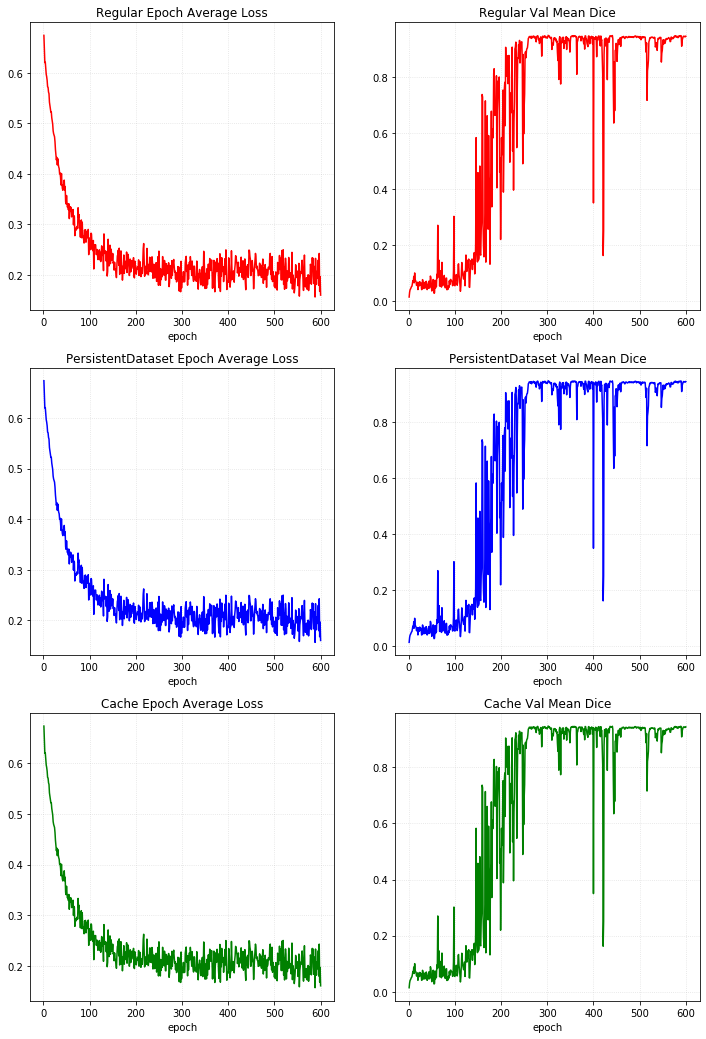

In [9]:
plt.figure('train', (12, 18))
plt.subplot(3, 2, 1)
plt.title('Regular Epoch Average Loss')
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel('epoch')
plt.grid(alpha=0.4, linestyle=':')
plt.plot(x, y, color='red')

plt.subplot(3, 2, 2)
plt.title('Regular Val Mean Dice')
x = [i + 1 for i in range(len(metric_values))]
y = cache_metric_values
plt.xlabel('epoch')
plt.grid(alpha=0.4, linestyle=':')
plt.plot(x, y, color='red')

plt.subplot(3, 2, 3)
plt.title('PersistentDataset Epoch Average Loss')
x = [i + 1 for i in range(len(epoch_loss_values))]
y = persistence_epoch_loss_values
plt.xlabel('epoch')
plt.grid(alpha=0.4, linestyle=':')
plt.plot(x, y, color='blue')

plt.subplot(3, 2, 4)
plt.title('PersistentDataset Val Mean Dice')
x = [i + 1 for i in range(len(metric_values))]
y = persistence_metric_values
plt.xlabel('epoch')
plt.grid(alpha=0.4, linestyle=':')
plt.plot(x, y, color='blue')

plt.subplot(3, 2, 5)
plt.title('Cache Epoch Average Loss')
x = [i + 1 for i in range(len(epoch_loss_values))]
y = cache_epoch_loss_values
plt.xlabel('epoch')
plt.grid(alpha=0.4, linestyle=':')
plt.plot(x, y, color='green')

plt.subplot(3, 2, 6)
plt.title('Cache Val Mean Dice')
x = [i + 1 for i in range(len(metric_values))]
y = cache_metric_values
plt.xlabel('epoch')
plt.grid(alpha=0.4, linestyle=':')
plt.plot(x, y, color='green')

plt.show()

## Plot total time and every epoch time

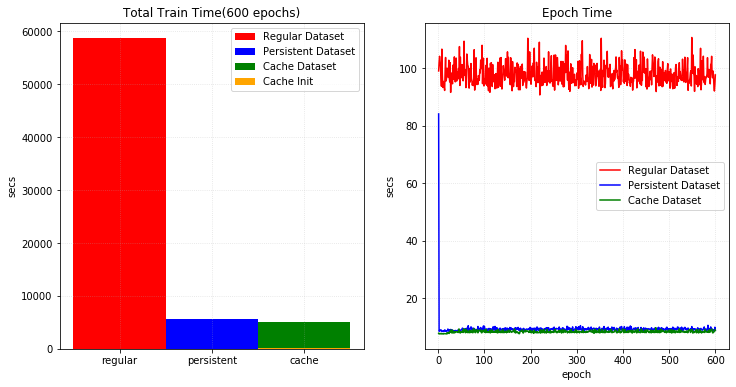

In [11]:
plt.figure('train', (12, 6))
plt.subplot(1, 2, 1)
plt.title('Total Train Time(600 epochs)')
plt.bar('regular', total_time, 1, label='Regular Dataset', color='red')
plt.bar('persistent', persistence_total_time, 1, label='Persistent Dataset', color='blue')
plt.bar('cache', cache_init_time + cache_total_time, 1, label='Cache Dataset', color='green')
plt.bar('cache', cache_init_time, 1, label='Cache Init', color='orange')
plt.ylabel('secs')
plt.grid(alpha=0.4, linestyle=':')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.title('Epoch Time')
x = [i + 1 for i in range(len(epoch_times))]
plt.xlabel('epoch')
plt.ylabel('secs')
plt.plot(x, epoch_times, label='Regular Dataset', color='red')
plt.plot(x, persistence_epoch_times, label='Persistent Dataset', color='blue')
plt.plot(x, cache_epoch_times, label='Cache Dataset', color='green')
plt.grid(alpha=0.4, linestyle=':')
plt.legend(loc='best')
plt.show()